# Introduction

The rapid spread of misinformation in the digital age has made fact-checking organizations essential in verifying claims and curbing false information. Platforms like PolitiFact and Snopes play a crucial role in this effort, yet their effectiveness and consistency in evaluating claims have come under scrutiny. With Meta’s decision to scale back its third-party fact-checking initiatives, concerns have emerged regarding the reliability, agreement, and methodologies used by these independent fact-checking platforms. While their ratings aim to provide clarity, inconsistencies often arise due to differences in rating systems, contextual interpretations, and linguistic nuances.
A key challenge in misinformation assessment is evaluating claims that contain high toxicity or strong sentiment, as emotionally charged language may influence how fact-checkers interpret and classify information. This study seeks to answer the main research question: 

“What are the factors affecting fact-checking evaluations between PolitiFact and Snopes, particularly focusing on toxicity, sentiment, and thematic patterns.”

To answer the research question, we will be looking into two sub-questions:

1.	How do toxicity and sentiment levels relate to the ratings assigned by PolitiFact and Snopes?
2.	What thematic patterns are common across "Fake" and “Real” claims as rated by PolitiFact and Snopes?

Through statistical analysis and linguistic evaluation, this study examines trends in misinformation assessment using a computational approach to fact-checking methodologies. Sentiment and toxicity analysis will be used to evaluate the role of emotionally charged content, and thematic patterns will highlight recurring themes and structures in misinformation. By integrating multiple methods, the study aims to clarify fact-checking transparency, consistency, and potential biases in claim appraisal.

# 1. Initializing Notebook and Libraries

In [1]:
# === Standard library ===
import os
import re
from collections import Counter

# === Third-party libraries ===

# Data handling
import pandas as pd
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
import time
import openpyxl

# NLP & text processing
import nltk
import torch
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.corpora import MmCorpus, Dictionary
from gensim.models import CoherenceModel, LdaModel
from transformers import AutoTokenizer
from detoxify import Detoxify
import spacy

# Vectorization & clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
from kneed import KneeLocator

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from wordcloud import WordCloud

# JSON
import json

# === NLTK setup ===
nltk.download('stopwords')
nltk.download('vader_lexicon')
stop_words = stopwords.words('english')

# === spaCy setup ===
nlp = spacy.load("en_core_web_sm")
nlp.disable_pipes("parser", "ner")  # keep only tagger/lemmatizer and disable unnecessary pipeline components for speed


# === Paths ===
path = r"C:\Users\phili\Documents\Vaulty\Notes\Career\Portfolio\Github\Repositories\fact-checking"
os.chdir(path)  # Change working directory


c:\Users\phili\anaconda3\envs\text-analysis-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
import torch
print(f'PyTorch: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')

if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    x = torch.tensor([1.0]).cuda()
    print('✅ GPU works!')

PyTorch: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
✅ GPU works!


## 1.1. Loading Data

In [227]:
# Load datasets
politifact = pd.read_csv('data/raw/politifact.csv')
snopes = pd.read_csv('data/raw/snopes.csv')

# 2. Exploratory Data Analysis (EDA)

In [228]:
display(snopes.info())
display(politifact.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11639 entries, 0 to 11638
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   link              11639 non-null  object
 1   title             11639 non-null  object
 2   claim             11639 non-null  object
 3   rating            11639 non-null  object
 4   content_owner     11639 non-null  object
 5   author_name       11639 non-null  object
 6   date_published    11639 non-null  object
 7   date_updated      943 non-null    object
 8   primary_category  11611 non-null  object
 9   tags              8131 non-null   object
 10  sourceid          11639 non-null  int64 
 11  sources_num       11639 non-null  int64 
 12  sources           11639 non-null  object
 13  bodyt             11638 non-null  object
 14  page_type         11639 non-null  object
dtypes: int64(2), object(13)
memory usage: 1.3+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10710 entries, 0 to 10709
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   claim        10710 non-null  object
 1   link         10710 non-null  object
 2   rating       10710 non-null  object
 3   fc_date      10710 non-null  object
 4   author       10709 non-null  object
 5   cdate        10710 non-null  object
 6   cwhere       10654 non-null  object
 7   fc_year      10710 non-null  int64 
 8   fc_month     10710 non-null  int64 
 9   fc_day       10710 non-null  int64 
 10  title        10710 non-null  object
 11  cstated_by   10710 non-null  object
 12  tags         10710 non-null  object
 13  summary      4776 non-null   object
 14  bodyt        10710 non-null  object
 15  sources_num  10710 non-null  int64 
 16  sources      10710 non-null  object
dtypes: int64(4), object(13)
memory usage: 1.4+ MB


None

In [229]:
format = "ISO8601"
format2 = "%m/%d/%y"
# Formatting datetime variables 
snopes['date_published'] = pd.to_datetime(snopes['date_published'], format=format)
snopes['fc_year'] = snopes['date_published'].dt.year
snopes['fc_month'] = snopes['date_published'].dt.month
snopes['fc_day'] = snopes['date_published'].dt.day

politifact['fc_date'] = pd.to_datetime(politifact['fc_date'], format=format2)
politifact['cdate'] = pd.to_datetime(politifact['cdate'], format=format2)

# Removing NAN values
politifact = politifact.dropna(subset=['bodyt'])
snopes = snopes.dropna(subset=['bodyt'])

### 2.1. **Attribute Summary**

Politifact contains two more attributes than Snopes, and their attributes are also more useful attributes in terms of information compared to Snopes. For example, Politifact includes the date when the original claim was made (`cdate`), the platform or medium the claim was shared on (`cwhere`), who made the claim (`cstated_by`), and a summary of the article (`summary`). Although Snopes also includes a useful attribute (`primary_category`) to categorize the subject type of the claim.

| **Politifact Attributes** | **Snopes Attributes** | **Explanation**                                                              |
| ------------------------- | --------------------- | ---------------------------------------------------------------------------- |
| 1. claim                  | 1. claim              | The text of the claim being fact-checked.                                    |
| 2. link                   | 2. link               | URL of the fact-check article.                                               |
| 3. rating                 | 3. rating             | Truthfulness rating assigned by the fact-checker (e.g., True, False, Mixed). |
| 4. author                 | 4. author_name        | Name of the author who wrote the fact-check article.                         |
| 5. title                  | 5. title              | Title or headline of the fact-check article.                                 |
| 6. tags                   | 6. tags               | Keywords or thematic tags associated with the claim.                         |
| 7. bodyt                  | 7. bodyt              | Full text or main body content of the fact-check article.                    |
| 8. sources_num            | 8. sources_num        | Number of sources cited in the fact-check.                                   |
| 9. sources                | 9. sources            | List or text of sources referenced.                                          |
| 10. fc_date               | 10. date_published    | Date when the fact-check was published.                                      |
| 11. fc_year               | 11. fc_year           | Year extracted from the publication date.                                    |
| 12. fc_month              | 12. fc_month          | Month extracted from the publication date.                                   |
| 13. fc_day                | 13. fc_day            | Day extracted from the publication date.                                     |
| 14. cdate                 | -                     | Date when the original claim was made.                                       |
| 15. cwhere                | -                     | Platform or medium where the claim originated (e.g., Twitter, TV interview). |
| 16. cstated_by            | -                     | Individual or organization who made the claim.                               |
| 17. summary               | -                     | Short summary of the fact-check findings.                                    |
| -                         | 14. date_updated      | Date when the Snopes article was last updated.                               |
| -                         | 15. primary_category  | Subject category of the claim (e.g., politics, science, fauxtography).       |
| -                         | 16. content_owner     | Organization or publication that owns the content (i.e. Snopes).                           |
| -                         | 17. sourceid          | NA                     |
| -                         | 18. page_type         | Type of Snopes page (e.g., "Fact Check" or other content types).             |


### 2.2. **Distribution of Articles Across Organizations**

The following graph displays the total count of articles extracted from the two organizations between January 1, 2016, to August 31, 2022. This noteably shows that, while Politifact has a more granular data on their articles, Snopes has reviewed 929 more articles in the same time frame. This could possible be due to the fact that Snopes has a more diverse rating system - not limited to ordinal scale between True and False - allowing them to cover more potential claims. See the following chapter `Distribution of Articles Across Ratings` on more information on the ratings used by both organizations.

organization
Snopes        11638
Politifact    10710
Name: count, dtype: int64


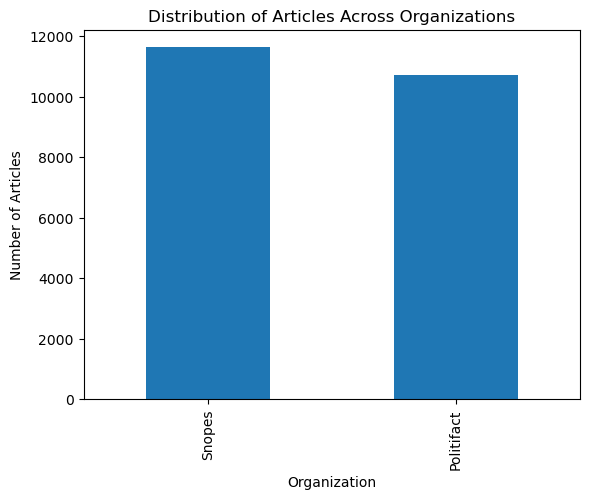

In [230]:
# Add attribute 'organization' before combining datasets
politifact['organization'] = 'Politifact'
snopes['organization'] = 'Snopes'

# Combine datasets for analysis
combined = pd.concat([politifact, snopes], ignore_index=True)

# Count of articles per organization
organization_counts = combined['organization'].value_counts()
print(organization_counts)

# Bar chart
organization_counts.plot(kind='bar', title='Distribution of Articles Across Organizations')
plt.xlabel('Organization')
plt.ylabel('Number of Articles')
plt.show()

### 2.3. **Distribution of Articles Across Ratings**

In the graph below, we can see the distribution of articles between the rating categories for both organizations. Clearly, Snopes has a much granular rating system - with 19 different ratings - compared to Politifact with 6 ratings. Snopes uses a mix of nominal and ordinal scales while Politifact sticks to a simple ordinal scale ranging between True and False. This difference reflects the varying scopes of the organizations: PolitiFact focuses simply on verifying the truth of a claim, while Snopes places greater emphasis on verifying truthful claims (e.g. whether it is a scam, outdated, miscaptioned, etc.).

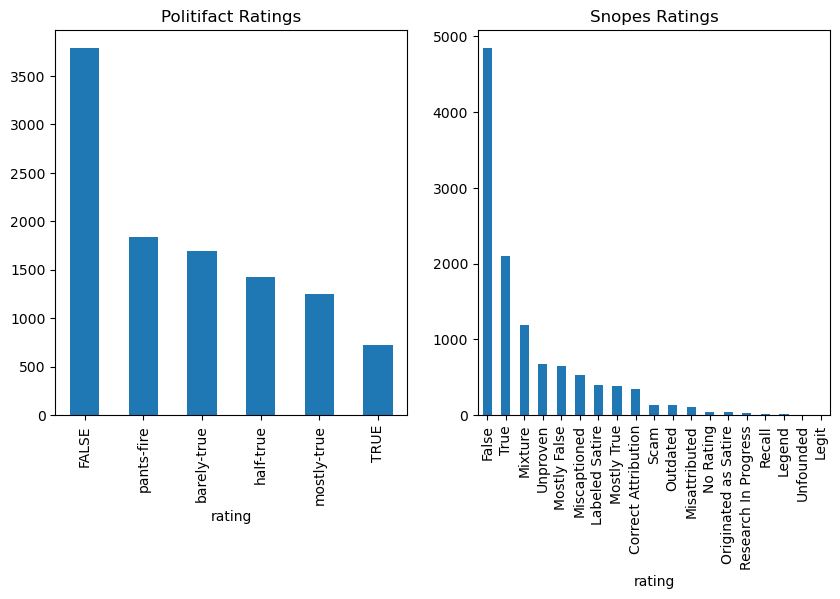

In [231]:
# Distribution across organizations
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
politifact['rating'].value_counts().plot(kind='bar', title='Politifact Ratings')
plt.subplot(1,2,2)
snopes['rating'].value_counts().plot(kind='bar', title='Snopes Ratings')
plt.show()

#### 2.3.1. **Snopes** Rating-System Summary ([Source](https://www.snopes.com/fact-check-ratings/))

| Rating | Explanation |
|--------|-------------|
| Research in Progress | This rating is used with pages that present items which we are currently investigating but have not yet reached any publishable conclusion about. |
| True | This rating indicates that the primary elements of a claim are demonstrably true. |
| Mostly True | This rating indicates that the primary elements of a claim are demonstrably true, but some of the ancillary details surrounding the claim may be inaccurate. |
| Mixture | This rating indicates that a claim has significant elements of both truth and falsity to it such that it could not fairly be described by any other rating. |
| Mostly False | This rating indicates that the primary elements of a claim are demonstrably false, but some of the ancillary details surrounding the claim may be accurate. |
| False | This rating indicates that the primary elements of a claim are demonstrably false. |
| Unproven | This rating applies to a claim for which we have examined the available evidence but could not arrive at a true or false determination, meaning the evidence is inconclusive or self-contradictory. |
| Unfounded | This rating applies to a claim that we have investigated but found no demonstrable evidence to support it. Such claims typically originate as hearsay, speculation, or groundless rumor. |
| Outdated | This rating applies to items for which subsequent events have rendered their original truth rating irrelevant (e.g., a condition that was the subject of protest has been rectified, or the passage of a controversial law has since been repealed). |
| Miscaptioned | This rating is used with photographs and videos that are "real" (i.e., not the product, partially or wholly, of digital manipulation) but are nonetheless misleading because they are accompanied by explanatory material that falsely describes their origin, context, and/or meaning. |
| Correct Attribution | This rating indicates that quoted material (speech or text) has been correctly attributed to the person who spoke or wrote it. |
| Misattributed | This rating indicates that quoted material (speech or text) has been incorrectly attributed to a person who didn't speak or write it. |
| Legend | This rating is most commonly associated with items that describe events so general or lacking in detail that they could have happened to someone, somewhere, at some time, and are therefore essentially unprovable. |
| Scam | This "rating" is not a truth rating but rather indicates pages that describe the details of verified scams. |
| Legit | This rating describes authentic, legitimate offers or initiatives available to consumers or members of the public. |
| Labeled Satire | This rating indicates that a claim is derived from content described by its creator and/or the wider audience as satire. Not all content described by its creator or audience as 'satire' necessarily constitutes satire, and this rating does not make a distinction between 'real' satire and content that may not be effectively recognized or understood as satire despite being labeled as such. |
| Originated as Satire | This rating refers to content that originally came from a site described as satire, but was later stripped of some of its satirical markings, repackaged, and posted elsewhere. The rating also applies to content not necessarily labeled as satire but that audiences perceived as satirical nonetheless, such as content from The Onion. |
| Recall | This rating is applied to genuine product recall notices. |
| Lost Legend | These legends aren't really lost — we've known where they were the whole time! We created The Repository of Lost Legends (TRoLL for short) for those of you who don't let the truth get in the way of a good story. If you have a taste for the unusual and arcane (and can suspend your disbelief just a little), sample some of these precious gems. |
| Fake | This rating applies to photographs and videos that were either manipulated via digital editing, or manufactured from scratch via CGI (computer-generated imagery) or AI (artificial intelligence) software, such that they convey a false or misleading message or an outright misrepresentation of reality. |

#### 2.3.2. **Poltifact** Rating-System Summary ([Source](https://www.politifact.com/article/2018/feb/12/principles-truth-o-meter-politifacts-methodology-i/#Truth-O-Meter%20ratings))

| Rating | Description |
|--------|-------------|
| TRUE | The statement is accurate and there's nothing significant missing. |
| MOSTLY TRUE | The statement is accurate but needs clarification or additional information. |
| HALF TRUE | The statement is partially accurate but leaves out important details or takes things out of context. |
| MOSTLY FALSE | The statement contains an element of truth but ignores critical facts that would give a different impression. |
| FALSE | The statement is not accurate. |
| PANTS ON FIRE | The statement is not accurate and makes a ridiculous claim. |

## 2.4. Text Exploration

### 2.4.1. **Word Cloud of the Claims**

From the wordcloud and barchart we can see that for both Snopes and Politifact, the most occuring words seem to be 'Trump', 'US', 'news', and 'claim'. I am ignoring 'President' as it is semantically tied to the word 'Trump' and won't provide much more meaning. We are probably seeing these words because of the timeframe boundaries that were used to extract Poltificat and Snopes articles which overlap with Trumps presidency between 2016 and 2020. The frequency of the word 'Trump' in conjunction with the total number of claims that have been rated as false for both Politifact and Snopes highlights that Trump seemed to be the center of many of these false claims during this time. 

In [232]:
# Functions to process, tokenize, clean, and display the text in a word cloud and word frequency bar chart

nltk.download('stopwords')

def preprocess_and_tokenize(text_data, model_name="bert-base-uncased", max_length=512, preserve_words=None):
    """
    Preprocesses text data by removing special characters, punctuation, and stopwords,
    then tokenizes the cleaned text in chunks to avoid exceeding the model's maximum 
    sequence length.
    """
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Add words to preserve as special tokens
    if preserve_words:
        # Convert to lowercase if using uncased model
        preserve_words_lower = [word.lower() for word in preserve_words]
        num_added = tokenizer.add_tokens(preserve_words_lower)
    
    # Define stopwords
    stop_words = set(stopwords.words('english'))
    
    # Remove preserve_words from stopwords if they're in there
    if preserve_words:
        stop_words = stop_words - set(w.lower() for w in preserve_words)
    
    if isinstance(text_data, str):
        text_combined = text_data
    else:
        text_combined = " ".join(str(row) for row in text_data)
    
    # Remove punctuation, special characters, and extra spaces
    text_cleaned = re.sub(r'[^a-zA-Z0-9\s]', '', text_combined)
    text_cleaned = re.sub(r'\s+', ' ', text_cleaned).strip()
    
    # Split text into smaller chunks
    text_chunks = [text_cleaned[i:i + max_length] for i in range(0, len(text_cleaned), max_length)]
    
    # Tokenize each chunk and filter stopwords
    tokens_filtered = []
    for chunk in text_chunks:
        tokens = tokenizer.tokenize(chunk)
        filtered = [token for token in tokens if token.isalnum() and token not in stop_words]
        tokens_filtered.extend(filtered)
    
    return tokens_filtered

def remove_stopwords(word_list, stopwords):
    """
    Removes custom stopwords from a list of words.
    """
    # Ensure stopwords is a set for efficient lookup
    stopwords_set = set(stopwords)
    return [word for word in word_list if word not in stopwords_set]
    
def word_cloud_frequency_plots(word_count=None, n_words=10):
    """
    Plot a word cloud and word frequency bar chart for Snopes and Politifact
    """
    # Create subplot layout
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    # Word Cloud Politifact
    wordcloud = WordCloud(width=800, height=400, 
                        background_color='white',
                        colormap='viridis',
                        max_words=100).generate_from_frequencies(word_count[0])
    ax1.imshow(wordcloud, interpolation='bilinear')
    ax1.set_title('Politifact Word Cloud', fontsize=14, fontweight='bold')
    ax1.axis('off')

    # Word Cloud Snopes
    wordcloud = WordCloud(width=800, height=400, 
                        background_color='white',
                        colormap='viridis',
                        max_words=100).generate_from_frequencies(word_count[1])
    ax2.imshow(wordcloud, interpolation='bilinear')
    ax2.set_title('Snopes Word Cloud', fontsize=14, fontweight='bold')
    ax2.axis('off')

    # Word frequency Politifact
    word_count[0].head(n_words).sort_values(ascending=True).plot(
        kind='barh', 
        ax=ax3,
        color='steelblue'
    )
    ax3.set_title(f'Politifact Word Frequency (Top {n_words})', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Frequency')
    ax3.set_ylabel('Words')
    ax3.grid(True, alpha=0.3, axis='x')

    # Word frequency Snopes
    word_count[1].head(n_words).sort_values(ascending=True).plot(
        kind='barh', 
        ax=ax4,
        color='steelblue'
    )
    ax4.set_title(f'Snopes Word Frequency (Top {n_words})', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Frequency')
    ax4.set_ylabel('Words')
    ax4.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()
    return

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [233]:
pf_text_data = politifact['bodyt']
sn_text_data = snopes['bodyt']

preserved_words = ['covid', 'biden']

# Tokenize the body text before removing stopwords
tokens_filtered_pf = preprocess_and_tokenize(pf_text_data, preserve_words=preserved_words)
tokens_filtered_sn = preprocess_and_tokenize(sn_text_data, preserve_words=preserved_words)

# Remove custom stopwords that obscure meaningful words in the wordcloud
custom_stopwords = ['would', '202', 'said', 'post', 'also', 'people', 'september', 'one', 'may', 'time']

# Remove stopwords
tokens_filtered_pf = remove_stopwords(tokens_filtered_pf, custom_stopwords)
tokens_filtered_sn = remove_stopwords(tokens_filtered_sn, custom_stopwords)

# Count frequency of each rating
pf_word_count = pd.Series(tokens_filtered_pf).value_counts()
sn_word_count = pd.Series(tokens_filtered_sn).value_counts()

word_count = [pf_word_count, sn_word_count]
word_cloud_frequency_plots(word_count)

KeyboardInterrupt: 

### 2.4.2. **Temporal Analysis of the Top 4 Words**

When modelling the distribution of the top 5 overlapping words between Snopes and Politifact across time, we can try to find associations between words and noteable events within the 6 year timeframe and, therefore, potentially why these words are so prevalent. 

The first thing we can note is that within Poltifact's articles, every word peaks around October, especially for the years 2016, 2018, and 2020. Without looking into the actual data, we can assume that, for the years 2016 and 2020, these words could be related to the United States upcoming presidential elections in the first week of November and the increasing coverage on the presidential campaigns of Donald Trump. Why these words peak around the same time in 2018 is a bit more obscure. However, when isolating the word 'claim', inspecting a 10-word window before and after the selected word for each document, and conducting some research on events that happened in the United States on October 2018, we can see that the data overlaps with a couple events. Most noteably: 
- The midterm elections, including a new period of campaigning for Donald Trump; 
- The confirmation of Brett Kavanaugh, Trump's Supreme Court nominee, who was accussed of sexual assault before being sworn in; 
- As well as mail bombs being sent to democrats and Trump critics. 
- [Source1](https://theweek.com/10things/797245/10-things-need-know-today-october-10-2018), [Source2](https://edition.cnn.com/2018/12/21/world/top-stories-of-2018/)

October 2018 has proven to be another eventful month for potentially specualtive claims centering around the words 'Trump', 'US', and 'claim' (with the exception for the word 'news' which is a less specific term that gets used more diversely).

Interestingly, Snopes does not seem to reflect the same level of interest in the presidential election periods. Instead, the more interesting trend seems to happen around the end of 2020 and the start of 2021 for the words 'US', 'claim', and 'news', judging by the similarity of their trends. A major global phenomenon that could be responsible for this trend is the COVID-19 pandemic. When comparing this to the word 'covid' graphed over time, the trends overlap on March of 2020 - which was around the same time that many countries around the world went into the first lockdown - possibly suggesting that the articles and the claims made were centered around COVID-19. This is further supported by another word cloud and word frequency bar chart showing the most common used words after January 2020, including 'covid' as the third highest used word behind to 'Trump', and 'US'. However, it is important to note taht this is a superficial analysis based on a simple visual inspection. No definitive conclusions can be made without conducting a more thorough inspection of the data which falls outside the scope of this reseach. 

#### 2.4.2.1. Plot Top Words Across Time

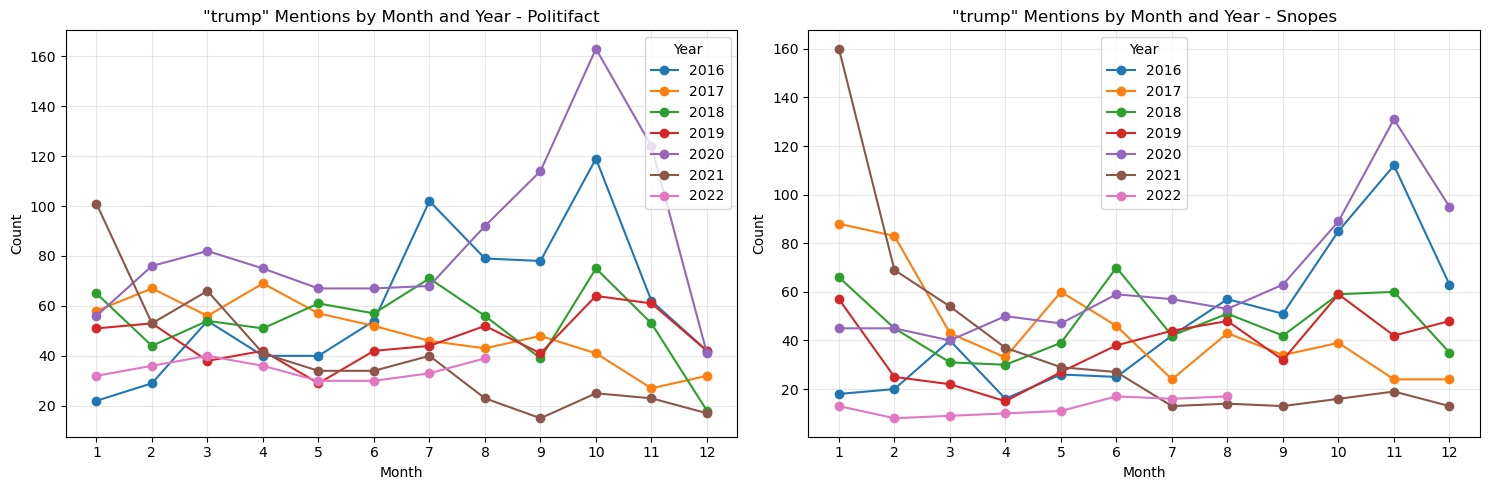

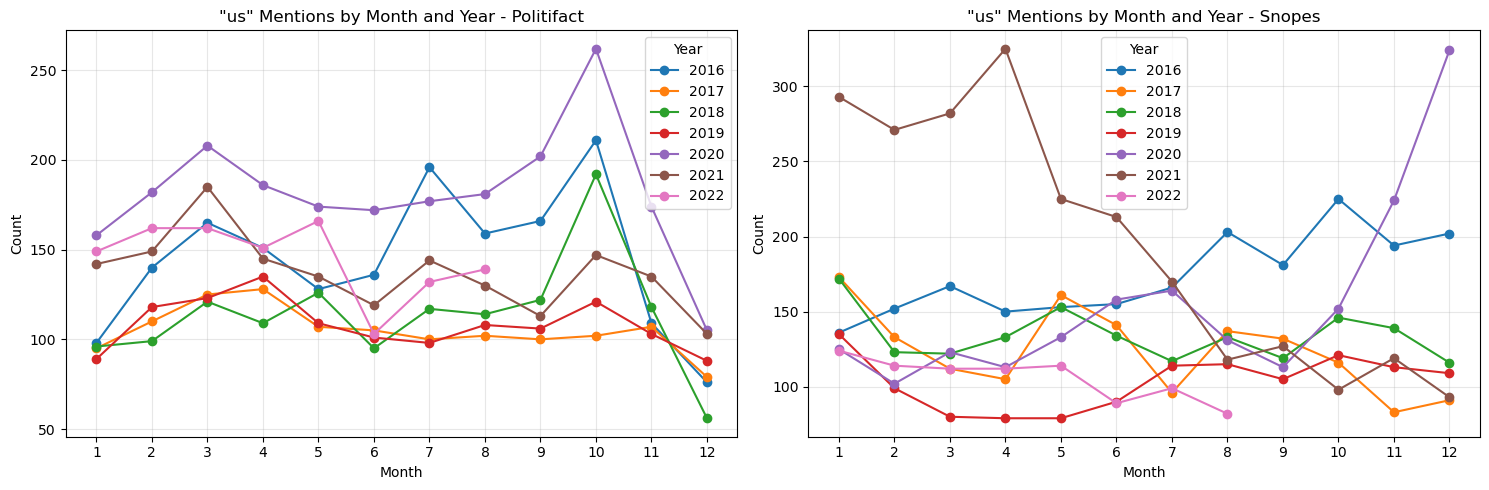

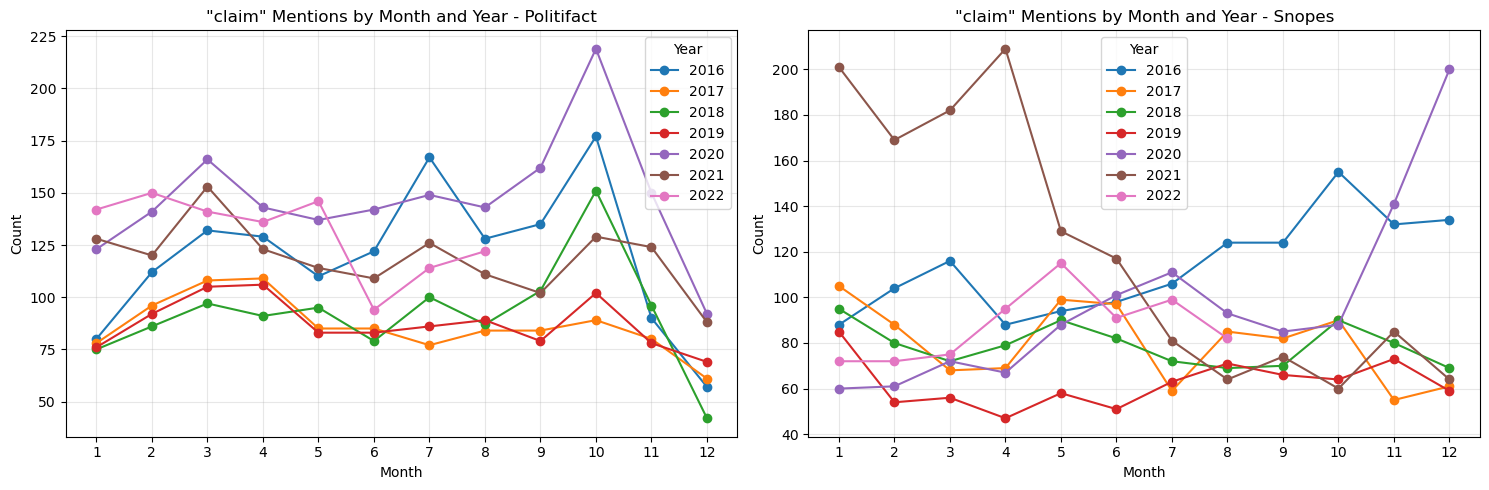

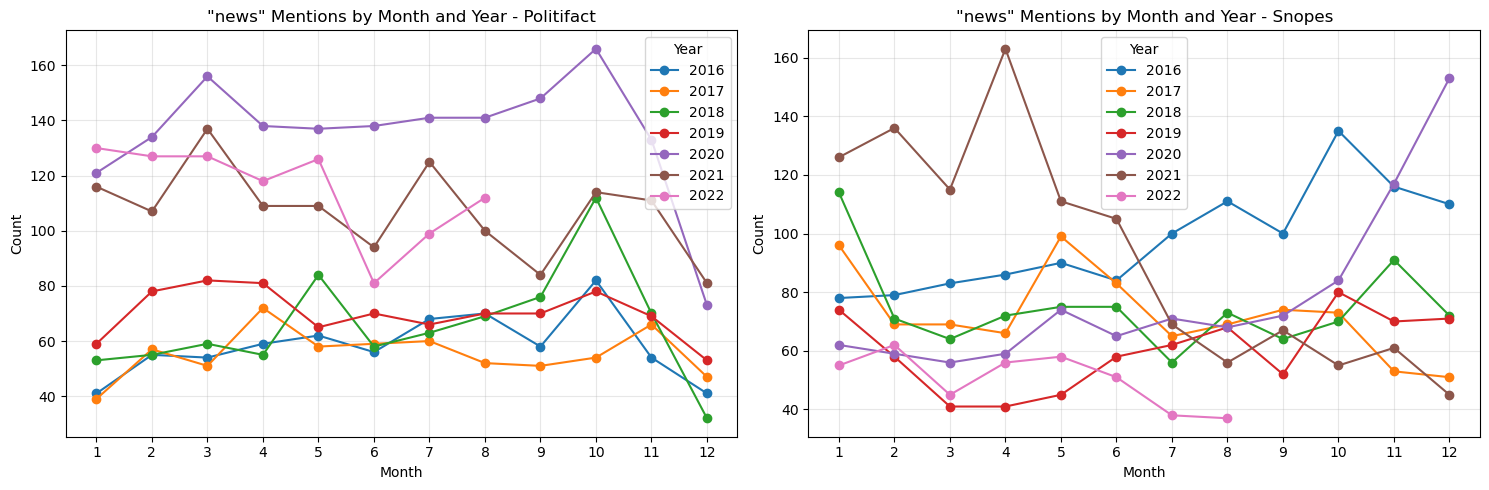

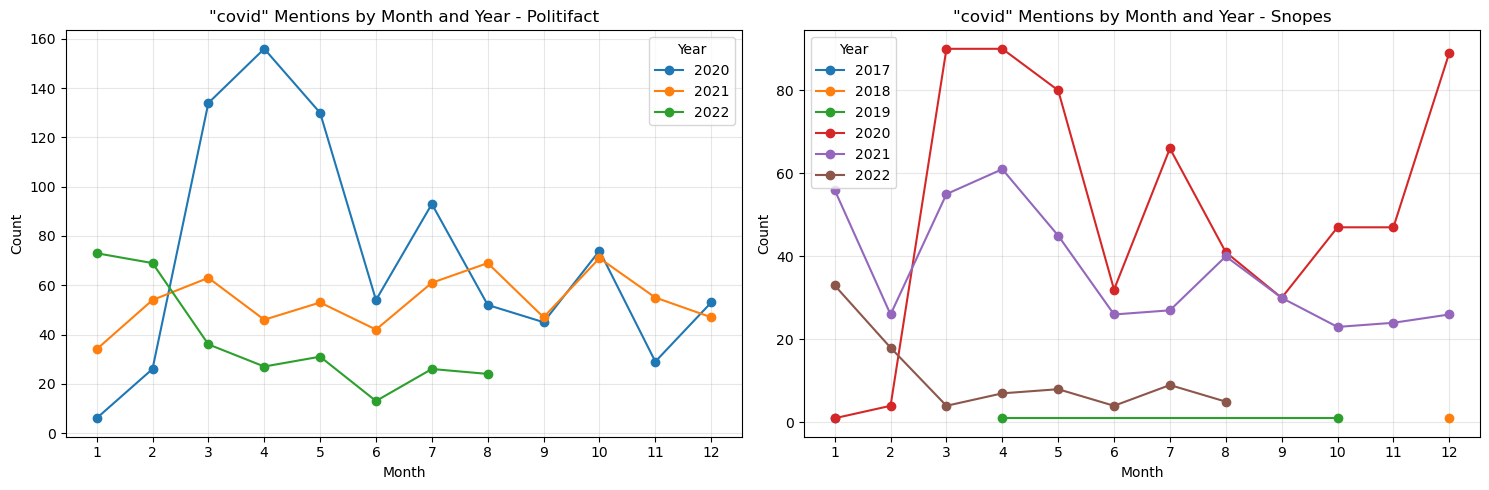

In [10]:
def plot_word_mentions_over_time(word, politifact_df, snopes_df):
    """
    Plot word mentions over time for both Politifact and Snopes datasets.
    """
    # Filter data for the word
    word_po = politifact_df[politifact_df['bodyt'].str.contains(word, case=False)]
    word_sn = snopes_df[snopes_df['bodyt'].str.contains(word, case=False)]
    
    # Group by year and month
    counts_po = word_po.groupby(['fc_year', 'fc_month']).size().reset_index(name='count')
    counts_sn = word_sn.groupby(['fc_year', 'fc_month']).size().reset_index(name='count')
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    # Plot Politifact data
    for year in counts_po['fc_year'].unique():
        year_data = counts_po[counts_po['fc_year'] == year]
        ax1.plot(year_data['fc_month'], year_data['count'], marker='o', label=year)
    
    # Plot Snopes data
    for year in counts_sn['fc_year'].unique():
        year_data = counts_sn[counts_sn['fc_year'] == year]
        ax2.plot(year_data['fc_month'], year_data['count'], marker='o', label=year)
    
    # Configure both axes
    for ax, title_suffix in [(ax1, 'Politifact'), (ax2, 'Snopes')]:
        ax.set_xlabel('Month')
        ax.set_ylabel('Count')
        ax.set_title(f'"{word}" Mentions by Month and Year - {title_suffix}')
        ax.set_xticks(range(1, 13))
        ax.legend(title='Year')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Usage
words = ["trump", "us", "claim", "news", "covid"]

for word in words:
    plot_word_mentions_over_time(word, politifact, snopes)

#### 2.4.2.1.1. Inspect 'Claim' in October 2018

In [28]:
# Filter for October 2018
filtered = politifact.loc[(politifact['fc_year']==2018) & (politifact['fc_month']==10), 'bodyt']

# matches: claim, claims, claimed, claiming
pattern1 = r'\bclaims?\b|\bclaimed\b|\bclaiming\b'

claims = filtered[filtered.str.contains(pattern1, case=False, na=False)]

def get_context_tokens_regex(text, pattern, n_words=20):
    if not isinstance(text, str) or not text:
        return []
    tokens = re.findall(r"\b\w+\b", text)
    hits = [i for i, t in enumerate(tokens) if re.fullmatch(pattern, t, flags=re.IGNORECASE)]
    return [' '.join(tokens[max(0, i-n_words): i+n_words+1]) for i in hits]

pattern2 = r'claim(?:s|ed)?|claiming'

contexts = [get_context_tokens_regex(claim, pattern2, n_words=10) for claim in claims]

display(contexts)


[['those conditions Insurance companies may also investigate a policyholder s claim of illness or injury and make a retroactive finding that',
  'largest newspaper the Billings Gazette took Rosendale to task for claiming to support protections for those with pre existing conditions while'],
 ['debate of the campaign Molinaro pushed back against Cuomo s claim that he has increased spending by only 2 percent per',
  'topic for New Yorkers we decided to check Molinaro s claim Cuomo has said that he would keep spending increases to',
  'state law In 2016 PolitiFact New York checked Cuomo s claim that he had kept spending increases to 2 percent and',
  'had kept spending increases to 2 percent and found his claim to be True Share The Facts Marc Molinaro Candidate for',
  'would rise by 3 7 percent despite the administration s claim that it would rise by only 2 percent The administration',
  'released in July stated that though the Cuomo administration had claimed that it stuck to a spending

# 3. Data Preprocessing

## 3.1. Calculating TFIDF scores

In [ ]:
# Combine 'claim' columns from the 'politifact' and 'snopes' DataFrames into a single Series
statements = pd.concat([politifact['bodyt'], snopes['bodyt']], ignore_index=True)

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the text into a sparse matrix
X = vectorizer.fit_transform(statements)

# Separate the dense matrix into two parts:
arr_pf = X[:len(politifact)] # 'arr_pf' corresponds to the TF-IDF vectors of the 'politifact' dataset
arr_sn = X[len(politifact):] # 'arr_sn' corresponds to the TF-IDF vectors of the 'snopes' dataset

# Check if the lengths match the lengths of the original DataFrames
assert arr_pf.shape[0] == len(politifact), "Length mismatch for Politifact"
assert arr_sn.shape[0] == len(snopes), "Length mismatch for Snopes"

# Define a function to compute similarity metrics between two datasets
def sim(arr1, arr2, thresh):
    tfidf_sim = cosine_similarity(arr1, arr2) # Compute the cosine similarity between all pairs of rows in 'arr1' and 'arr2'

    x = thresh # Set the similarity threshold for determining significant similarity

    # Check if any similarity score in each row of 'tfidf_sim' exceeds the threshold 'x'
    y1 = [any(y > x for y in tf) for tf in tfidf_sim] # y1 contains a boolean value for each row in 'arr1' indicating if it has a match in 'arr2'

    # Check if any similarity score in each column of 'tfidf_sim' exceeds the threshold 'x'
    y2 = [any(y > x for y in tf) for tf in tfidf_sim.T] # y2 contains a boolean value for each row in 'arr2' indicating if it has a match in 'arr1'

    return tfidf_sim, y1, y2, sum(y1), sum(y2), (sum(y1) / arr1.shape[0]) * 100, (sum(y2) / arr2.shape[0]) * 100

# Compute the similarity metrics between the Snopes and PolitiFact datasets using the function
tfidf_sim, y1, y2, sumy1, sumy2, y1p, y2p = sim(arr_sn, arr_pf, thresh=0.5)


## 3.2. Matching the Claims

In [ ]:
# Add a new column to label the content owner as either 'Politifact' or 'Snopes'
politifact['content_owner'] = "PolitiFact"
snopes['content_owner'] = "Snopes"

# Initialize a dictionary to store similarity results between Snopes and PolitiFact claims
sim_result = {
    'similarity_score': [],      # Similarity score between Snopes and PolitiFact claims
    'website_sn': [],
    'claim_sn': [],
    'rating_sn': [],
    'link_sn': [],
    'date_sn': [],
    'body_sn': [],
    'website_pf': [],
    'claim_pf': [],
    'rating_pf': [],           
    'link_pf': [],
    'date_pf': [],
    'body_pf': []
}

# Loop through each claim in the Snopes dataset to find matches in PolitiFact
for i in range(len(snopes)):
    # Check if the maximum similarity score for the current Snopes claim meets or exceeds 0.5
    if tfidf_sim[i].max() >= 0.5:
        # Append similarity-related data to the 'sim_result' dictionary
        sim_result['similarity_score'].append(round(tfidf_sim[i].max(), 3))
        sim_result['website_sn'].append(snopes['content_owner'][i])
        sim_result['claim_sn'].append(snopes['claim'][i])
        sim_result['rating_sn'].append(snopes['rating'][i])
        sim_result['link_sn'].append(snopes['link'][i])
        sim_result['date_sn'].append(snopes['date_published'][i])
        sim_result['body_sn'].append(snopes['bodyt'][i])

        # Append matching PolitiFact data using the index of the highest similarity score
        max_index = tfidf_sim[i].argmax()  # Index of the PolitiFact claim with the highest similarity
        sim_result['website_pf'].append(politifact['content_owner'][max_index])
        sim_result['claim_pf'].append(politifact['claim'][max_index])
        sim_result['rating_pf'].append(politifact['rating'][max_index])
        sim_result['link_pf'].append(politifact['link'][max_index]) 
        sim_result['date_pf'].append(politifact['fc_date'][max_index])
        sim_result['body_pf'].append(politifact['bodyt'][max_index])

# Verify that the number of matches equals the number of Snopes links in the results
sum(y1) == len(sim_result['link_sn'])

# Convert the similarity results dictionary into a DataFrame for further processing
match_df = pd.DataFrame(sim_result)

# Drop duplicates
match_df = match_df.drop_duplicates(subset=['claim_sn'], keep='first')

# Save to excel
match_df.to_csv('data/results/match_df.csv', index=False)

## 3.3. Removing irrelevant ratings

There are certian raitings that fall outside the ordinal scale of truthfulness, and since the limiting factor for comparison is Politifact - who only looks at the truthfulness of the claim - we must remove the documents in Snopes with ratings that don't adhere to this scale. By removing these ratings, the analysis can focus on clearer evaluations of truthfulness, avoiding ambiguity, and ensuring methodological consistency. This will also allow for a direct comparison of how the two organizations classify claims.

In [46]:
# Read dataframe
match_df = pd.read_csv('data/results/match_df.csv')

print("Length before removing irrelevant ratings:", len(match_df))

# Remove Snopes: ‘Legend’, ‘Unproven’, 'Labeled Satire', 'Research In Progress', 'No Rating'
irrelevant_ratings = ['Legend', 'Unproven', 'Labeled Satire', 'Research In Progress', 'No Rating', 'Correct Attribution']
match_df_relevant_ratings = match_df[~match_df['rating_sn'].isin(irrelevant_ratings)].reset_index(drop=True)

print("Length after removing irrelevant ratings:", len(match_df_relevant_ratings))

Length before removing irrelevant ratings: 2484
Length after removing irrelevant ratings: 2244


## 3.4. Normalize Ratings

The normalization into a 5-point ordinal scale (True, Mostly True, Half True, Mostly False, False) is designed to streamline comparisons between Politifact and Snopes ratings, which differ in granularity and focus. By grouping ratings with similar implications for truthfulness or factual reliability, the framework allows for consistent and interpretable analysis while preserving the essential distinctions between levels of truth.

| **Politifact rating** | **Snopes rating**                                                           | **Normalized Rating** |
| --------------------- | --------------------------------------------------------------------------- | --------------------- |
| `TRUE`                | `True`, `Correct Attribution`, `Legit`, `Recall`                            | `True`                |
| `mostly-true`         | `Mostly True`                                                               | `Mostly True`         |
| `half-true`           | `Mixture`                                                                   | `Half true`           |
| `barely-true`         | `Mostly False`, `Miscaptioned`, `Misattributed`, `Outdated`                 | `Mostly False`        |
| `FALSE`, `pants-fire` | `False`, `Scam`, `Originated as Satire`, `Unfounded`                        | `False`               |
| NaN                   | `Legend`, `Unproven`, `Labeled Satire`, `Research In Progress`, `No Rating` | REMOVED               |


In [48]:
# Function to normalize ratings
def normalize_rating(rating):
    if rating in ['TRUE', 'True', 'Legit', 'Recall']:
        return 'True'
    elif rating in ['mostly-true', 'Mostly True']:
        return 'Mostly True'
    elif rating in ['half-true', 'Mixture']:
        return 'Half True'
    elif rating in ['barely-true', 'Mostly False', 'Miscaptioned', 'Misattributed', 'Outdated']:
        return 'Mostly False'
    elif rating in ['FALSE', 'pants-fire', 'False', 'Scam', 'Originated as Satire', 'Unfounded']:
        return 'False'

# Apply normalization
match_df_final = match_df_relevant_ratings.copy()
match_df_final['normalized_rating_sn'] = match_df_relevant_ratings['rating_sn'].apply(normalize_rating)
match_df_final['normalized_rating_pf'] = match_df_relevant_ratings['rating_pf'].apply(normalize_rating)

#Check whether normalization is successful
normalized_rating_unique = match_df_final['normalized_rating_sn'].unique()
print(normalized_rating_unique)

['Mostly False' 'Half True' 'False' 'True' 'Mostly True']


### 3.4.1. Word Cloud of Only Matching Claims

A quick visual analysis of what kind of words are used in the articles for the overlapping claims can give insight into what each organization tends to focus on.

From the word cloud and word frequency bar chart below, we can see that most of the words overlap which isn't very surprising given that we are looking only at articles from both organizations that are talking about the same claim. Trump is mentioned the most in both organizations, with Biden being mention by Snopes almost as much as Trump. However, it's interesting to see that across a 6 year data window (between 2016 and 2022), one of the main subjects that both Politifact and Snopes seem to address is COVID - which gained the most mentions between 2020 and 2021 (1/3 of the entire timeframe) as is shown in the `Temporal Analysis of the Top 4 Words` - implying that there was a major influx of suspicious claims related to the global pandemic in a relatively 'short' period of time compared to the total timeframe (t least large enough to make the top 4 words for both Politifact and Snopes). 

NOTE: I've removed the words '19', 'joe' ,'donald', and 'president' because they are already words that are implied by 'covid', 'biden' and 'trump', which can obscure the prevalance of other potentially more insightful words.

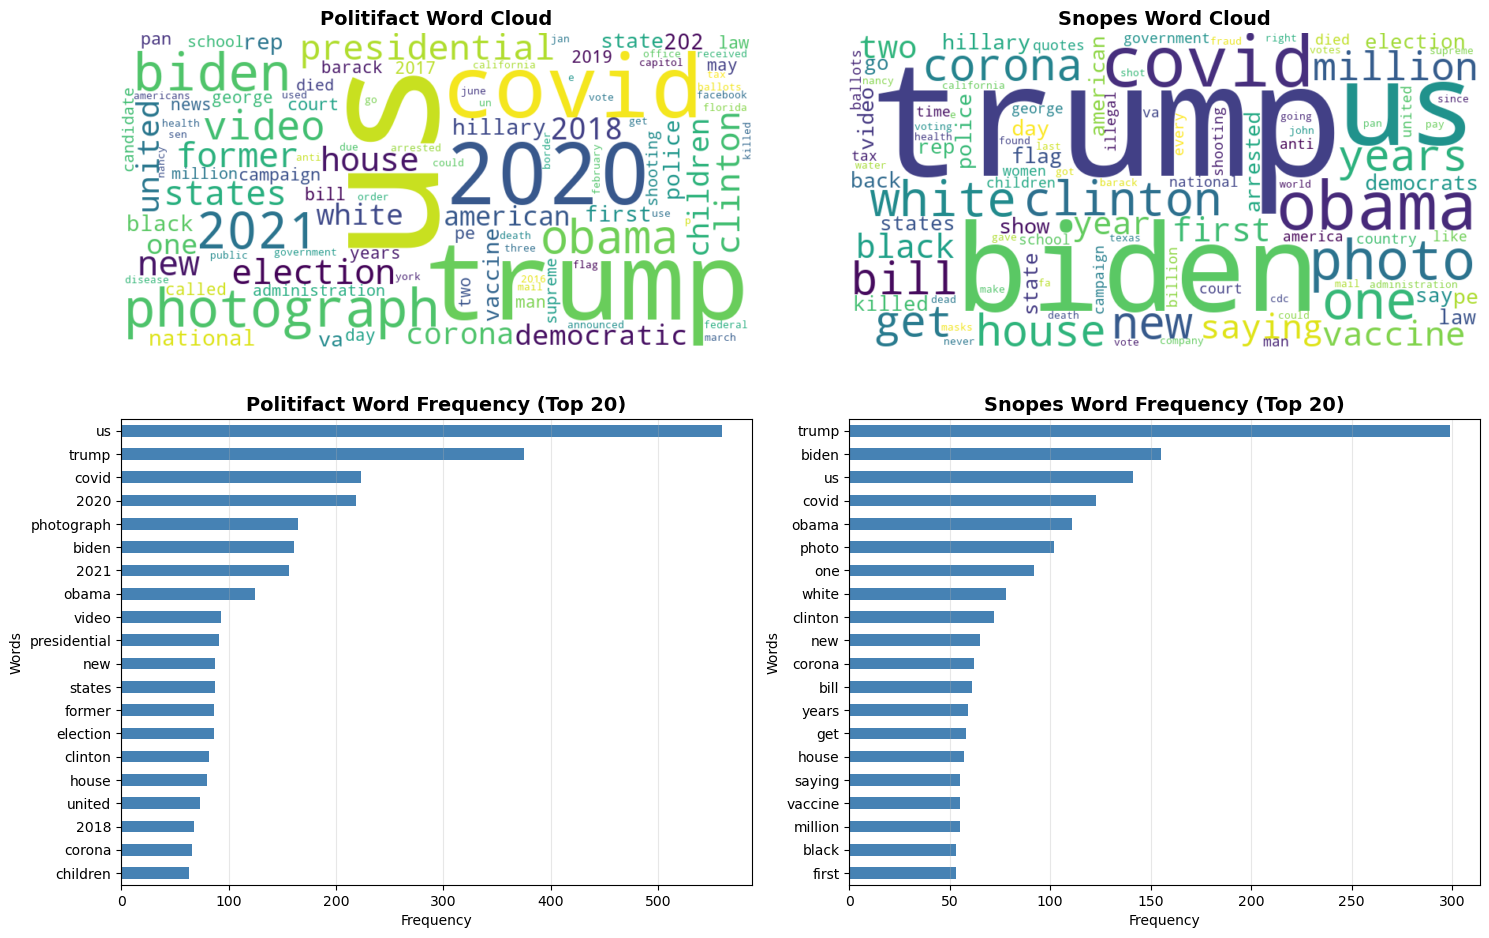

In [49]:
# Separate  matched claims by organization
sn_text_data_final = match_df_final['claim_sn']
pf_text_data_final = match_df_final['claim_pf']

# Preprocess and tokenize the text
preserve_words = ['covid', 'biden'] # Prevent Covid and Biden getting tokenized into 'co' and 'bi' 
tokens_filtered_sn = preprocess_and_tokenize(sn_text_data_final, preserve_words=preserve_words)
tokens_filtered_pf = preprocess_and_tokenize(pf_text_data_final, preserve_words=preserve_words)

# Remove custom stopwords that obscure meaningful words in the wordcloud
custom_stopwords = ['said', 'says', 'shows', '19', 'joe' ,'donald', 'president', 'people', 'would']

# Remove stopwords
tokens_filtered_pf = remove_stopwords(tokens_filtered_pf, custom_stopwords)
tokens_filtered_sn = remove_stopwords(tokens_filtered_sn, custom_stopwords)

# Count frequency of each rating
sn_word_count_final = pd.Series(tokens_filtered_sn).value_counts()
pf_word_count_final = pd.Series(tokens_filtered_pf).value_counts()

# Create a Word Cloud and Word Frequency Bar Chart
word_count = [sn_word_count_final, pf_word_count_final]
word_cloud_frequency_plots(word_count, n_words=20)

# 4. Feature Engineering

## 4.1. Create Veracity Score

To make a cross-source comparison, the rating scheme is converted into a binary system called a veracity score. This helps make interpretation of the information easier when comparing the alignment of Snopes and Politifact and conducting a confusion matrix. I've included 'Mixed' to show what percentage of the data contains a 'Half Truth' statement. Because of the nature of the a 'half truth', it isn't possible to assign it either a 'Real' or 'Fake' score without having to look at the documents individually and scoring them manually. Therefore, we will be ignoring 'Mixed' when analysing the data based on veracity scores and only including them in the Pie Chart for descriptive completeness.

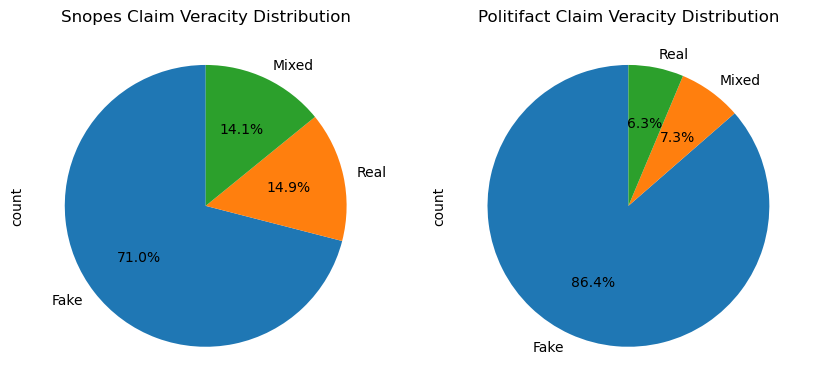

In [51]:
rating_map = {
    'True': 'Real',
    'Mostly True': 'Real',
    'Half True': 'Mixed',
    'Mostly False': 'Fake',
    'False': 'Fake',
}

match_df_final["veracity_sn"] = match_df_final["normalized_rating_sn"].map(rating_map)
match_df_final["veracity_pf"] = match_df_final["normalized_rating_pf"].map(rating_map)

# Pie chart for Snopes claim veracity
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
match_df_final['veracity_sn'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Snopes Claim Veracity Distribution')

# Pie chart for Politifact claim veracity
plt.subplot(1, 2, 2)
match_df_final['veracity_pf'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Politifact Claim Veracity Distribution')

plt.show()

match_df_final.to_csv('data/results/veracity.csv', index=False)

# 5. Data Analysis

## 5.1. Accuracy Check

To check the accuracy of the TF-IDF matching a random sample of size 50% was taken and manually assessed and the results were aggregated to the entire dataset of matched claims. Based on the manual assessment, 83.86% were true positives, 11.53% were false positives, and 4.61% were partial positives. Partial positives (PP) are matches that had some overlap but differed in some ways that made matching it to either TP or FP difficult. A table has been created below with some examples. Some claims were talking about the same claim but one of the claims missed a certain detail or had a slightly different value that changed the way the fact-checker would go about rating the claim (Row 0). Another example in Row 1 looks at the same claim except that the Snopes claim analyses a broader version of the same claim while PolitiFact looks at a specific aspect of the claim; i.e., black unemployment vs overall unemployment. A third example involves two claims that are talking about very similar events but at different periods and different contexts. Row 2 talks about a memorial that was vandalized during a black lives matter protest, except, when looking at the context of the article the claims are referring to different memorials and different black lives matter protests.

| # | Snopes Claim | PolitiFact Claim |
|---|---------------|------------------|
| 0 | The crew of the USS Constitution ("Old Ironsides") consumed more than 250,000 gallons of liquor and no water at all during a six-month voyage in 1798. | The crew of the U.S.S. Constitution consumed more than 252,000 gallons of alcohol and only 10,000 gallons of water on a seven-month trip. |
| 1 | Because of U.S. President Donald Trump, America recorded the lowest unemployment rate in 50 years. | "Because of my policies, Black Unemployment has just been reported to be at the LOWEST RATE EVER RECORDED!" |
| 2 | The 9/11 Memorial & Museum and the World War II Memorial, both in New York state, were vandalized during Black Lives Matter protests in the spring of 2020. | Says a photo shows a memorial vandalized by Black Lives Matter protesters. |

### 5.1.1. Analyze the Quality-Checked Sample Data

c:\Users\phili\anaconda3\envs\text-analysis-gpu\lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


T/F/P  count  percentage
0     T    291   83.861671
1     F     40   11.527378
2     P     16    4.610951

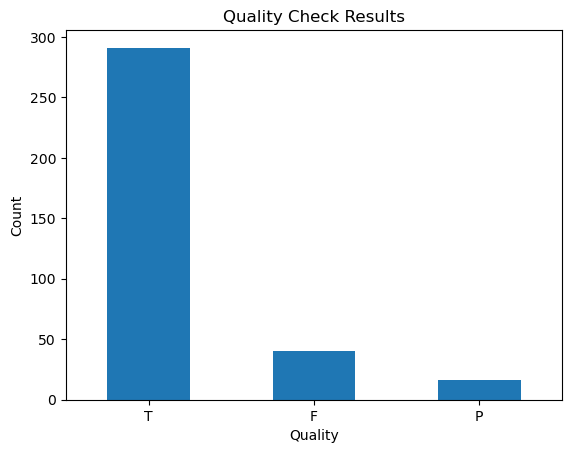

In [ ]:
match_df_final = pd.read_csv('data/results/veracity.csv')

match_df_final = match_df_final.drop_duplicates(subset=['claim_sn'], keep='first')

# ======= Randomly select 50% of the data and store it to allow for manually scoring ========= #

# sampled_df = match_df_final.sample(frac=0.50, random_state=42)

# sampled_df.to_excel('data/results/sampled_df.xlsx')

# ============================================================================================ #

# Reload the quality-checked sample data
qc_df = pd.read_excel('data/results/sampled_df_qc.xlsx')

quality_count = qc_df['T/F/P'].value_counts()

# Convert to DataFrame
quality_count_df = quality_count.reset_index()
quality_count_df.columns = ['T/F/P', 'count']

# Calculate percentages
quality_count_df['percentage'] = (quality_count_df['count'] / quality_count_df['count'].sum()) * 100

display(quality_count_df)

quality_count.plot(kind='bar', title='Qua' \
'lity Check Results')
plt.tick_params(axis='x', rotation=0)
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

### 5.1.2. Projecting Manual Checks Across all Matches

In the following section, I am taking the manual checks (ground truth; 50% of the data) and projecting them across all TF-IDF matches to see where the TF-IDF algorithm performed well or poorly. By binning similarity scores and computing cumulative accuracy distributions, we can visually and quantitatively justify what similarity threshold yields reliable matches and balancing match precision against the overall coverage of the dataset.

From the data and graph, we can see that, after aggregating the results of the manual check to the full dataset, at a threshold of 0.649 there are close to 1057 documents left with virtually no False Positives (FPs) and only a few Partial Positives (PPs). However, while a 0.649 cutoff yields near-zero FPs, it halves the matched set, which is already 2/10th of the total dataset. Therefore, the original threshold of 0.5 is kept as it maintains coverage and statistical power in downstream analyses, with an acceptable error rate. This error rate should be taken into account when considering the implications of the results for the research question.

C:\Users\phili\AppData\Local\Temp\ipykernel_20852\3887857887.py:33: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = qc.pivot_table(index='similarity_bin', columns='T/F/P', aggfunc='size', fill_value=0)


T/F/P            F  P   T  data_points  cumsum_F  inv_cumsum_F  perc_F  \
similarity_bin                                                           
0.525           12  7  27     1989.000        12            28   0.080   
0.549           10  3  35     1765.000        22            18   0.052   
0.574           11  2  17     1563.000        33             7   0.020   
0.599            2  2  19     1389.000        35             5   0.014   
0.624            4  1  22     1229.000        39             1   0.003   
0.649            1  0  26     1064.000        40             0   0.000   
0.673            0  0  19      916.000        40             0   0.000   
0.698            0  0  20      764.000        40             0   0.000   
0.723            0  0  18      636.000        40             0   0.000   
0.748            0  0  22      511.000        40             0   0.000   
0.772            0  0  12      417.000        40             0   0.000   
0.797            0  0   6      332.000        40             0   0.000   
0.822            0  0   8      249.000        40             0   0.000   
0.847            0  0   5      191.000        40             0   0.000   
0.871            0  1  11      133.000        40             0   0.000   
0.896            0  0   7       80.000        40             0   0.000   
0.921            0  0   5       44.000        40             0   0.000   
0.946            0  0   2       14.000        40             0   0.000   
0.970            0  0   4        1.000        40             0   0.000   
0.995            0  0   6        0.000        40             0   0.000   

T/F/P           Inv_Cum_F_Total  cumsum_P  inv_cumsum_P  perc_P  \
similarity_bin                                                    
0.525                   185.023         7             9   0.026   
0.549                   125.285        10             6   0.017   
0.574                    48.405        12             4   0.011   
0.599                    34.812        14             2   0.006   
0.624                     8.033        15             1   0.003   
0.649                     0.000        15             1   0.003   
0.673                     0.000        15             1   0.003   
0.698                     0.000        15             1   0.003   
0.723                     0.000        15             1   0.003   
0.748                     0.000        15             1   0.003   
0.772                     0.000        15             1   0.003   
0.797                     0.000        15             1   0.003   
0.822                     0.000        15             1   0.003   
0.847                     0.000        15             1   0.003   
0.871                     0.000        16             0   0.000   
0.896                     0.000        16             0   0.000   
0.921                     0.000        16             0   0.000   
0.946                     0.000        16             0   0.000   
0.970                     0.000        16             0   0.000   
0.995                     0.000        16             0   0.000   

T/F/P           Inv_Cum_P_Total  cumsum_T  inv_cumsum_T  perc_T  \
similarity_bin                                                    
0.525                    58.976        27           264   0.759   
0.549                    41.303        62           229   0.658   
0.574                    28.106        79           212   0.609   
0.599                    13.925        98           193   0.555   
0.624                     8.033       120           171   0.491   
0.649                     7.157       146           145   0.417   
0.673                     8.203       165           126   0.362   
0.698                     6.502       185           106   0.305   
0.723                     7.804       203            88   0.253   
0.748                     5.214       225            66   0.190   
0.772                     6.318       237            54   0.155   
0.797                    

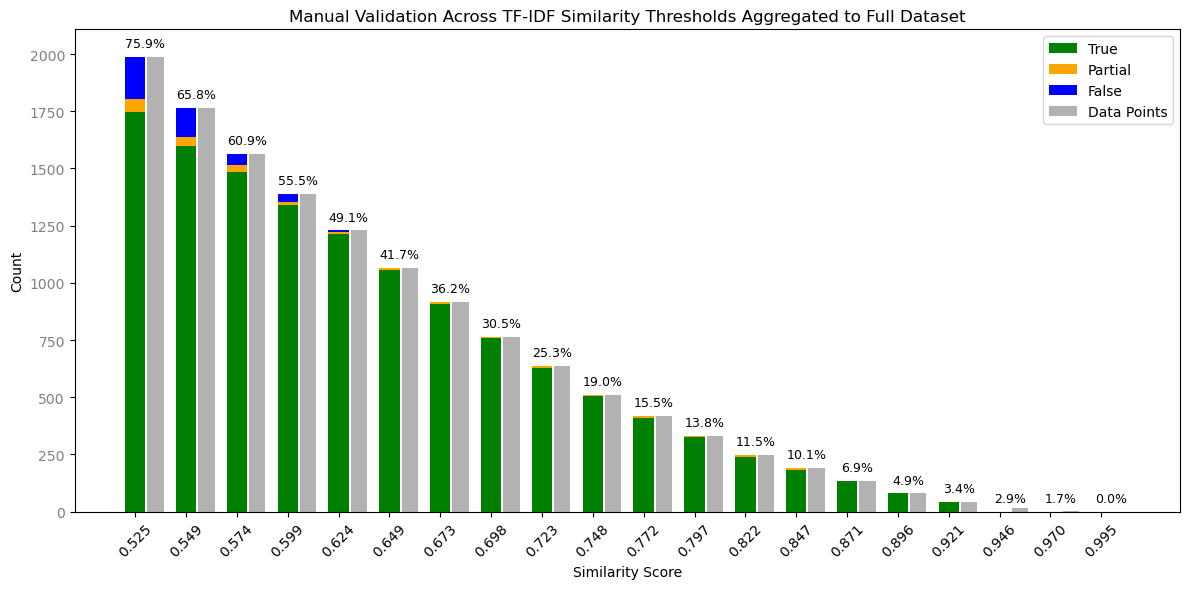

In [53]:
pd.set_option('display.float_format', '{:.3f}'.format)

# ======================== Helper Functions ======================== #
def similarity_bin(labels, sim_score: pd.Series, num_bins: int):
    """Convert continuous similarity scores into ordered bins."""
    bin_edges = np.linspace(sim_score.min(), sim_score.max(), num_bins+1)  
    return pd.cut(sim_score, bins=bin_edges, labels=labels, include_lowest=True, ordered=True)


def custom_pivot_table(df: pd.DataFrame, qc: pd.DataFrame, classes=['F', 'P', 'T']):
    """
    Function: Aggregate manual accuracy checks (T/F/P) by similarity score bin. 
    Purpose: Projects findings from the manually validated sample (qc) onto the
    full set of TF-IDF matches (df). Computes cumulative accuracy trends
    across similarity bins to evaluate model reliability at different
    thresholds.
    """

    # Count total matches per bin in the full dataset
    bin_counts = (
        df['similarity_bin']
        .value_counts()
        .sort_index()
        .to_frame('count')
        .reset_index()
        .rename(columns={'index': 'similarity_bin'})
    )
    bin_counts['cumulative_count'] = bin_counts['count'].cumsum()
    bin_counts['data_points'] = len(df) - bin_counts['cumulative_count']
    bin_counts.set_index('similarity_bin', inplace=True)
    
    # Count manually verified outcomes (T/F/P) per bin
    pivot = qc.pivot_table(index='similarity_bin', columns='T/F/P', aggfunc='size', fill_value=0)
    
    # Align with total dataset size by mapping remaining data points
    pivot['data_points'] = pivot.index.map(bin_counts['data_points']).astype(float)

    # Calculate cumulative and inverse-cumulative totals per class
    totals = pivot[classes].sum()       # total number of T/F/P across all bins
    cumsums = pivot[classes].cumsum()   # cumulative counts moving up similarity
    inv_cumsums = totals - cumsums      # remaining counts above current threshold
    percs = inv_cumsums / len(qc)       # relative share of remaining matches

    # Scale inverse-cumulative estimates to dataset size
    inv_totals = (percs.mul(pivot['data_points'], axis=0)).round()
    total_raw = inv_totals.sum(axis=1).replace(0, 1)  # avoid division by zero
    scale = pivot['data_points'] / total_raw
    inv_totals = inv_totals.mul(scale, axis=0)

    # Merge all metrics into one tidy DataFrame
    for c in classes:
        pivot[f'cumsum_{c}'] = cumsums[c]
        pivot[f'inv_cumsum_{c}'] = inv_cumsums[c]
        pivot[f'perc_{c}'] = percs[c]
        pivot[f'Inv_Cum_{c}_Total'] = inv_totals[c]

    pivot['Total_total'] = inv_totals.sum(axis=1)

    return pivot

# =================== Generalize manual sample findings to full dataset =================== #

num_bins = 20
bin_edges_sample = np.linspace(qc_df['similarity_score'].min(), qc_df['similarity_score'].max(), num_bins + 1)
range_labels = [f"{bin_edges_sample[i+1]:.3f}" for i in range(len(bin_edges_sample) - 1)]

match_df_final['similarity_bin'] = similarity_bin(labels=range_labels, 
                                                  sim_score=match_df_final['similarity_score'],
                                                  num_bins=num_bins)

qc_df['similarity_bin'] = similarity_bin(labels=range_labels, 
                                         sim_score=qc_df['similarity_score'],
                                         num_bins=num_bins)

pt_df = custom_pivot_table(match_df_final, qc_df)

display(pt_df)

# ============================ Plotting generalized findings ============================ #

x = np.arange(len(pt_df.index))     # Bin positions
width = 0.4                         # Width of each bar

fig, ax = plt.subplots(figsize=(12, 6))

# Stacked bars showing estimated number of T/P/F matches per similarity bin
bars1_T = ax.bar(x, pt_df['Inv_Cum_T_Total'], width=width, label='True', color='green')
bars1_P = ax.bar(x, pt_df['Inv_Cum_P_Total'], width=width, label='Partial', color='orange', bottom=pt_df['Inv_Cum_T_Total'])
bars1_F = ax.bar(x, pt_df['Inv_Cum_F_Total'], width=width, label='False', color='blue', bottom=pt_df['Inv_Cum_T_Total'] + pt_df['Inv_Cum_P_Total'])

# Gray overlay bars show total data points in each bin
bars2 = ax.bar(x + width, pt_df['data_points'], width=width * 0.8, color='gray', label='Data Points', alpha=0.6)

ax.set_xlabel('Similarity Score')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_title('Manual Validation Across TF-IDF Similarity Thresholds Aggregated to Full Dataset')
ax.tick_params(axis='y', labelcolor='gray')
ax.set_xticklabels(pt_df.index, rotation=45)
ax.legend(loc='upper right')

# --- Add percentage labels for True matches ---
y_top = (
    pt_df['Inv_Cum_T_Total'] +
    pt_df['Inv_Cum_P_Total'] +
    pt_df['Inv_Cum_F_Total']
)  # total stacked height (for text placement)

y_offset = 0.015 * y_top.max()  # small offset above bars

for xi, y, p in zip(x, y_top, pt_df['perc_T'] * 100):  # convert to %
    if not np.isnan(p):
        ax.text(
            xi+0.2, y + y_offset, f"{p:.1f}%", ha='center', va='bottom', fontsize=9, color='black'
        )

# Ensure text labels fit above the tallest bar
ax.set_ylim(0, y_top.max() + 4 * y_offset)

plt.tight_layout()
plt.show()

## 5.2. Check Consistency in Rating Between Organizations

In [55]:
# Compare Snopes vs. PolitiFact at two levels: veracity (binary) and normalized rating (granular)

# Match/mismatch indices
match_veracity_idx = match_df_final.index[match_df_final['veracity_sn'] == match_df_final['veracity_pf']]
mismatch_veracity_idx = match_df_final.index[match_df_final['veracity_sn'] != match_df_final['veracity_pf']]
match_rating_idx = match_df_final.index[match_df_final['normalized_rating_sn'] == match_df_final['normalized_rating_pf']]
mismatch_rating_idx = match_df_final.index[match_df_final['normalized_rating_sn'] != match_df_final['normalized_rating_pf']]

# Counts
n = len(match_df_final)
display(f"match_veracity_count: {len(match_veracity_idx)}")
display(f"mismatch_veracity_count: {n - len(match_veracity_idx)}")
display(f"match_rating_count: {len(match_rating_idx)}")
display(f"mismatch_rating_count: {n - len(match_rating_idx)}")

'match_veracity_count: 1630'

'mismatch_veracity_count: 614'

'match_rating_count: 1239'

'mismatch_rating_count: 1005'

### 5.2.1. Ratings - Find All Possible Matches

Using the function `classify()` and scale positioning (see table below), I've determined a certain logic for what is considered a Perfect Match, Complete Opposites, and Partial/Mixed matches.

| Category         | Meaning (approx.)                        | Scale position |
| ---------------- | ---------------------------------------- | -------------- |
| **True**         | Fully factual                            | +2             |
| **Mostly True**  | Largely factual, with small inaccuracies | +1             |
| **Half True**    | Equally factual and misleading           |  0             |
| **Mostly False** | Largely false, with small truths         | −1             |
| **False**        | Completely false                         | −2             |

The logic is as followed:

```python
if s1 == s2:
    return 'perfect'
```

e.g. 

T - T: 2 == 2, returns `perfect`

F - F: -2 == -2, returns `perfect`

HT - HT: 0 == 0, returns `perfect`

```python
elif s1 == -s2 and s1! 0:
    return 'opposite'
```

e.g.

T - F: 2 == -2, returns `opposite`

MT - MF: 1 == -1, returns `opposite`

`and st1! 0` is added to make sure HT-HT doesn't get assigned to opposite given that 0 == -0 will return True

```python
elif s1 * -s2 and abs(s1) != abs(s2):
    return 'mixed'
```

e.g.

MT - F: 1 * -2 = -2 `and` |1| != |-2|, returns `perfect`

---

From the graph, we can see that 55.2% - just over half - of the matches were perfect matches, and 33% partially agreed with each other. While 4.3% were mixed matches and 7.4% strongly disagreed with each other. Overall, Snopes and Politifact agreed with each other 88.2% of the time.

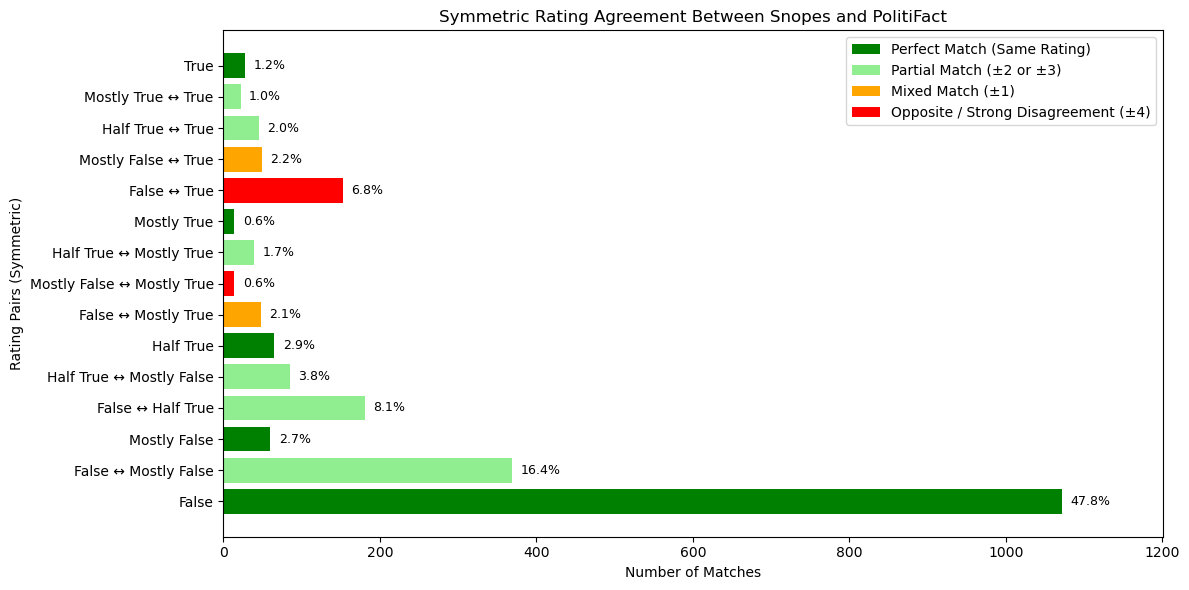

In [56]:
scale = {'True': 2, 'Mostly True': 1, 'Half True': 0, 'Mostly False': -1, 'False': -2}

def classify(a, b):
    s1, s2 = scale[a], scale[b]
    if s1 == s2:
        return 'perfect'
    if s1 == -s2 and s1 != 0:
        return 'opposite'
    if s1 * s2 < 0 and abs(s1) != abs(s2):
        return 'mixed'
    return 'partial'


ratings = list(scale.keys())
all_combinations = [(sn, pf) for sn in ratings for pf in ratings]

# Count matches directionally, merging symmetric pairs (A↔B)
pair_counts = Counter()
for sn, pf in all_combinations:
    count = len(match_df_final[
        (match_df_final['normalized_rating_sn'] == sn) &
        (match_df_final['normalized_rating_pf'] == pf)
    ])
    key = tuple(sorted([sn, pf]))
    pair_counts[key] += count

# Prepare data for plotting
rating_pairs = list(pair_counts.keys())
match_counts = list(pair_counts.values())
rating_labels = [f"{a} ↔ {b}" if a != b else f"{a}" for a, b in rating_pairs]

# Assign color based on rating distance
colors = []
for a, b in rating_pairs:
    if classify(a, b) == 'perfect':
        colors.append('green')
    elif classify(a, b) == 'opposite':
        colors.append('red')
    elif classify(a, b) == 'mixed':
        colors.append('orange')
    elif classify(a, b) == 'partial':
        colors.append('lightgreen')
    else:
        colors.append('gray')

# Compute percentages for bar labels 
total = sum(match_counts)
percs = [c / total * 100 for c in match_counts]

# Plot 
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(rating_labels, match_counts, color=colors)

ax.set_xlabel('Number of Matches')
ax.set_ylabel('Rating Pairs (Symmetric)')
ax.set_title('Symmetric Rating Agreement Between Snopes and PolitiFact')
ax.invert_yaxis()

# Legend consistent with logic 
legend_elements = [
    Patch(facecolor='green', label='Perfect Match (Same Rating)'),
    Patch(facecolor='lightgreen', label='Partial Match (±2 or ±3)'),
    Patch(facecolor='orange', label='Mixed Match (±1)'),
    Patch(facecolor='red', label='Opposite / Strong Disagreement (±4)')
]
ax.legend(handles=legend_elements, loc='upper right')

# Add % labels at bar ends 
pad = max(match_counts) * 0.01
for bar, p in zip(bars, percs):
    x = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(x + pad, y, f"{p:.1f}%", va='center', ha='left', fontsize=9)

ax.set_xlim(0, max(match_counts) * 1.12)
plt.tight_layout()
plt.show()


## 5.3. Toxicity Score and Sentiment Analysis

### 5.3.1. Sentiment Analysis

In [ ]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Apply sentiment analysis to snopes articles
match_df_final['sentiment_score_sn_body'] = match_df_final['body_sn'].apply(get_sentiment)

# Apply sentiment analysis to politifacts articles
match_df_final['sentiment_score_pf_body'] = match_df_final['body_pf'].apply(get_sentiment)

# Apply sentiment analysis to snopes claims
match_df_final['sentiment_score_sn_claim'] = match_df_final['claim_sn'].apply(get_sentiment)

# Apply sentiment analysis to politifacts claims
match_df_final['sentiment_score_pf_claim'] = match_df_final['claim_pf'].apply(get_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 5.3.2. Toxicity Score

This section is commented out due to the computational intensity. This is run once and the results are saved in a csv which is then reloaded later to avoid having to rerun everything everytime the runtime is disconnected.

In [ ]:
# Check if CUDA actually works
print('Checking GPU availability...')
print(f'CUDA available: {torch.cuda.is_available()}')

# Check if CUDA actually works
print('Checking GPU availability...')
print(f'CUDA available: {torch.cuda.is_available()}')

# Try to use GPU, fall back to CPU if it fails
try:
    # Test if CUDA actually works
    test_tensor = torch.tensor([1.0]).cuda()
    device = 'cuda'
    print('✅ GPU is working!')
except RuntimeError:
    device = 'cpu'
    print('⚠️  GPU error detected - using CPU instead')

print(f'Using device: {device}')

Checking GPU availability...
CUDA available: True
Checking GPU availability...
CUDA available: True
✅ GPU is working!
Using device: cuda


In [59]:
print('Loading Detoxify model...')

# Load model
model = Detoxify('original', device='cuda')  # Use CPU, not CUDA
print('Model loaded successfully!')

count = 0
def get_toxicity_score(text):
    global count
    if pd.isna(text):  # Handle missing values
        return None
    results = model.predict(text)
    count += 1
    if count % 10 == 0:  # Progress tracking
        print(f"Processed {count} texts...")
    return results['toxicity']

print('Computing toxicity scores for body...')
match_df_final['toxicity_score_sn_body'] = match_df_final['body_sn'].apply(get_toxicity_score)
match_df_final['toxicity_score_pf_body'] = match_df_final['body_pf'].apply(get_toxicity_score)
print(f'Done! Processed {count} texts total.')

print('Computing toxicity scores for claim...')
match_df_final['toxicity_score_sn_claim'] = match_df_final['claim_sn'].apply(get_toxicity_score)
match_df_final['toxicity_score_pf_claim'] = match_df_final['claim_pf'].apply(get_toxicity_score)
print(f'Done! Processed {count} texts total.')

match_df_final.to_csv('data/results/tox_and_sent_scores.csv', index=False)

Loading Detoxify model...
Model loaded successfully!
Computing toxicity scores for body...
Processed 10 texts...
Processed 20 texts...
Processed 30 texts...
Processed 40 texts...
Processed 50 texts...
Processed 60 texts...
Processed 70 texts...
Processed 80 texts...
Processed 90 texts...
Processed 100 texts...
Processed 110 texts...
Processed 120 texts...
Processed 130 texts...
Processed 140 texts...
Processed 150 texts...
Processed 160 texts...
Processed 170 texts...
Processed 180 texts...
Processed 190 texts...
Processed 200 texts...
Processed 210 texts...
Processed 220 texts...
Processed 230 texts...
Processed 240 texts...
Processed 250 texts...
Processed 260 texts...
Processed 270 texts...
Processed 280 texts...
Processed 290 texts...
Processed 300 texts...
Processed 310 texts...
Processed 320 texts...
Processed 330 texts...
Processed 340 texts...
Processed 350 texts...
Processed 360 texts...
Processed 370 texts...
Processed 380 texts...
Processed 390 texts...
Processed 400 texts..

# 6. Sub-question 1 - *How do toxicity and sentiment levels relate to the ratings assigned by PolitiFact and Snopes?*

## 6.1. Visualization of Toxicity and Sentiment

This section looks at both the toxicity and sentiment for both the claims made by people and the articles reviewing the claims. For both the claims and the articles it seems that toxic language is not evident and, therefore, does not play any significant role in how fact-checkers rate claims. Sentiment, on the other hand, differs in distribution between claims and articles.


### 6.1.1. Toxicity and Sentiment Analysis of Claims

When calculating the 25% quantiles for the sentiment score distribution, we can see that for both Snopes and Politifact have a median of 0.0 sentiment. However, Q1 and Q3 for Snopes is -0.42 and 0.08, which shows that the claims Snopes tend to review are generally slightly negative. Even more interestingly is that Politifact has a Q1 of -0.409 and a Q3 of 0.0. This revelas that 75% of Poltifact's claims have a negative sentiment, while only 25% have positive sentiment. This is interesting because the claims should be the same after having matched the claims from Snopes and Politifact using TF-IDF. This can be explained by the quality check done earlier, having used a threshold of 0.5, 8% of the data matches are estimated to be false. Regarding the medium of 0.0, the fact remains that the claims being analyzed usually have a neutral or factual tone, which is to be expected as claims are usually not opions but factual statements.

Snopes Sentiment Quantiles:
  Min (0%):    -0.965
  Q1 (25%):    -0.421 - 25% of claims more negative
  Median (50%): 0.000 - middle value
  Q3 (75%):    0.077 - 25% of claims more positive
  Max (100%):  0.929

PolitiFact Sentiment Quantiles:
  Min (0%):    -0.964
  Q1 (25%):    -0.409
  Median (50%): 0.000
  Q3 (75%):    0.000
  Max (100%):  0.898


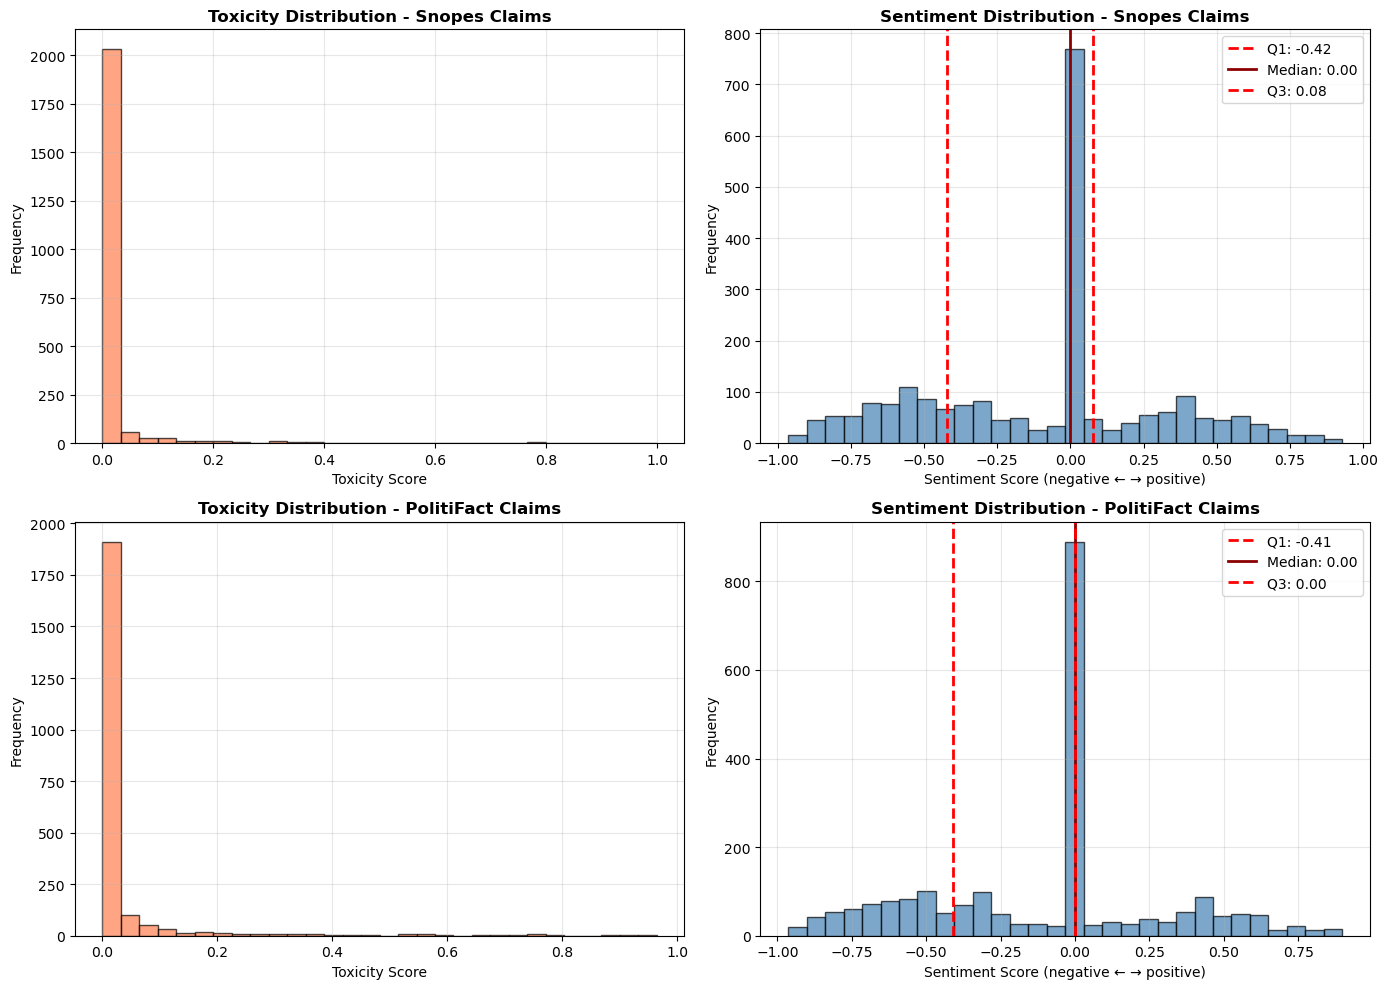

In [ ]:
tox_sen = pd.read_csv('data/results/tox_and_sent_scores.csv')

# Calculate quantiles
q_sn = np.quantile(tox_sen['sentiment_score_sn_claim'], q=[0, 0.25, 0.5, 0.75, 1])
q_pf = np.quantile(tox_sen['sentiment_score_pf_claim'], q=[0, 0.25, 0.5, 0.75, 1])

print("Snopes Sentiment Quantiles:")
print(f"  Min (0%):    {q_sn[0]:.3f}")
print(f"  Q1 (25%):    {q_sn[1]:.3f} - 25% of claims more negative")
print(f"  Median (50%): {q_sn[2]:.3f} - middle value")
print(f"  Q3 (75%):    {q_sn[3]:.3f} - 25% of claims more positive")
print(f"  Max (100%):  {q_sn[4]:.3f}")

print("\nPolitiFact Sentiment Quantiles:")
print(f"  Min (0%):    {q_pf[0]:.3f}")
print(f"  Q1 (25%):    {q_pf[1]:.3f}")
print(f"  Median (50%): {q_pf[2]:.3f}")
print(f"  Q3 (75%):    {q_pf[3]:.3f}")
print(f"  Max (100%):  {q_pf[4]:.3f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Toxicity - Snopes
axes[0, 0].hist(tox_sen['toxicity_score_sn_claim'], bins=30, 
                edgecolor='black', alpha=0.7, color='coral')
axes[0, 0].set_title('Toxicity Distribution - Snopes Claims', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Toxicity Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Toxicity - Politifact
axes[1, 0].hist(tox_sen['toxicity_score_pf_claim'], bins=30, 
                edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].set_title('Toxicity Distribution - PolitiFact Claims', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Toxicity Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Sentiment - Snopes with quantiles
axes[0, 1].hist(tox_sen['sentiment_score_sn_claim'], bins=30, 
                edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(x=q_sn[1], color='red', linestyle='--', linewidth=2, label=f'Q1: {q_sn[1]:.2f}')
axes[0, 1].axvline(x=q_sn[2], color='darkred', linestyle='-', linewidth=2, label=f'Median: {q_sn[2]:.2f}')
axes[0, 1].axvline(x=q_sn[3], color='red', linestyle='--', linewidth=2, label=f'Q3: {q_sn[3]:.2f}')
axes[0, 1].set_title('Sentiment Distribution - Snopes Claims', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Sentiment Score (negative ← → positive)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Sentiment - Politifact with quantiles
axes[1, 1].hist(tox_sen['sentiment_score_pf_claim'], bins=30, 
                edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 1].axvline(x=q_pf[1], color='red', linestyle='--', linewidth=2, label=f'Q1: {q_pf[1]:.2f}')
axes[1, 1].axvline(x=q_pf[2], color='darkred', linestyle='-', linewidth=2, label=f'Median: {q_pf[2]:.2f}')
axes[1, 1].axvline(x=q_pf[3], color='red', linestyle='--', linewidth=2, label=f'Q3: {q_pf[3]:.2f}')
axes[1, 1].set_title('Sentiment Distribution - PolitiFact Claims', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Sentiment Score (negative ← → positive)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_20852\3576596220.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([tox_sen['sentiment_score_sn_claim'],
C:\Users\phili\AppData\Local\Temp\ipykernel_20852\3576596220.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([tox_sen['toxicity_score_sn_claim'],


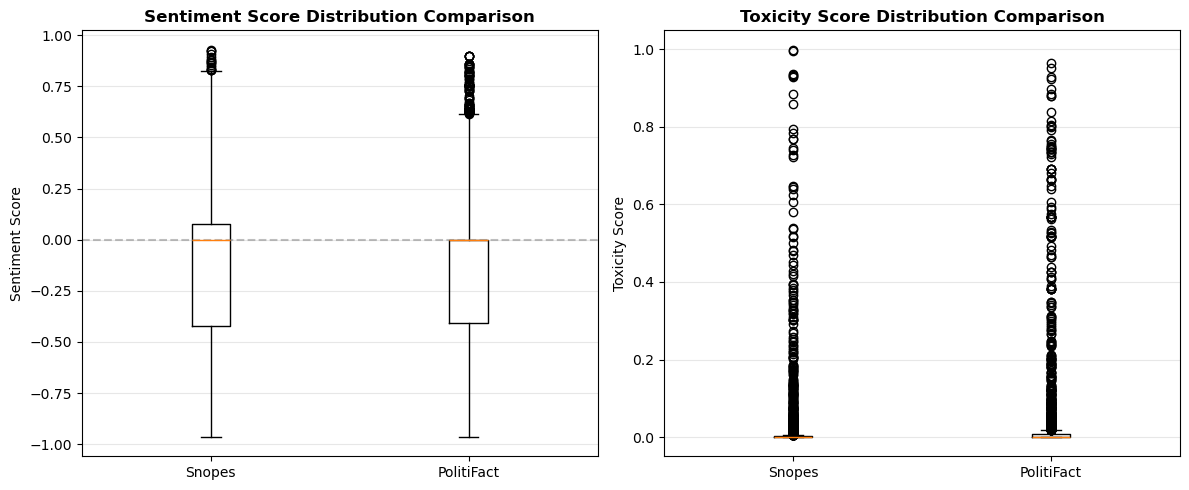

In [62]:
# Box plot shows quantiles perfectly
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Sentiment comparison
axes[0].boxplot([tox_sen['sentiment_score_sn_claim'], 
                 tox_sen['sentiment_score_pf_claim']],
                labels=['Snopes', 'PolitiFact'])
axes[0].set_title('Sentiment Score Distribution Comparison', fontweight='bold')
axes[0].set_ylabel('Sentiment Score')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Neutral')

# Toxicity comparison
axes[1].boxplot([tox_sen['toxicity_score_sn_claim'], 
                 tox_sen['toxicity_score_pf_claim']],
                labels=['Snopes', 'PolitiFact'])
axes[1].set_title('Toxicity Score Distribution Comparison', fontweight='bold')
axes[1].set_ylabel('Toxicity Score')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 6.1.2. Toxicity and Sentiment Analysis for Articles
The distribution of sentiment scores across articles shows a different trend compared to sentiment scores of the claims. Most of the articles either contian a positive sentiment score of 1 or a negative sentiment score of -1 with very few articles populating the rest of the graph. However, both articles have a median in the negative, meaning that the articles tend to have more of a negative sentiment rather than a positive sentiment. Another noteable finding is that the median for Politifact is heavily skewed to the negative, with a median score of -0.778. This may be caused by mismatched articles skewing the results (although mismatched articles only explain 8% of the data at a threshold of 0.5.) or the negative tone is inherent in the writers and culture of Politifact. We will test for the influence of mismatched articles on the median in the following section.

Snopes Sentiment Quantiles:
  Min (0%):    -1.000
  Q1 (25%):    -0.976 - 25% of claims more negative
  Median (50%): -0.181 - middle value
  Q3 (75%):    0.961 - 25% of claims more positive
  Max (100%):  1.000

PolitiFact Sentiment Quantiles:
  Min (0%):    -1.000
  Q1 (25%):    -0.985
  Median (50%): -0.778
  Q3 (75%):    0.923
  Max (100%):  1.000


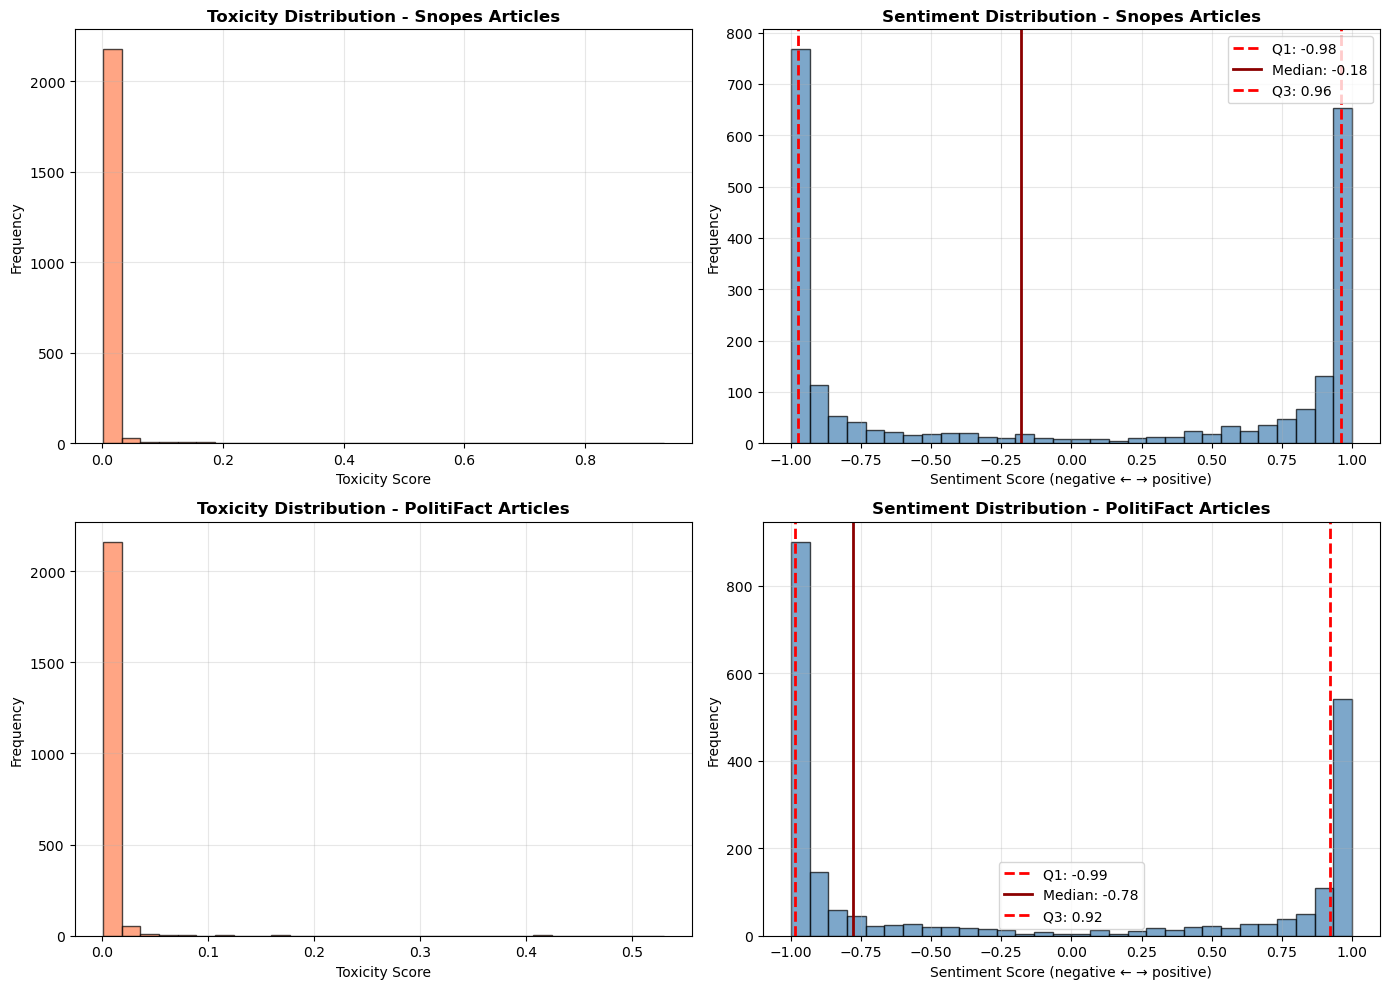

In [113]:
# Calculate quantiles
q_sn = np.quantile(tox_sen['sentiment_score_sn_body'], q=[0, 0.25, 0.5, 0.75, 1])
q_pf = np.quantile(tox_sen['sentiment_score_pf_body'], q=[0, 0.25, 0.5, 0.75, 1])

print("Snopes Sentiment Quantiles:")
print(f"  Min (0%):    {q_sn[0]:.3f}")
print(f"  Q1 (25%):    {q_sn[1]:.3f} - 25% of claims more negative")
print(f"  Median (50%): {q_sn[2]:.3f} - middle value")
print(f"  Q3 (75%):    {q_sn[3]:.3f} - 25% of claims more positive")
print(f"  Max (100%):  {q_sn[4]:.3f}")

print("\nPolitiFact Sentiment Quantiles:")
print(f"  Min (0%):    {q_pf[0]:.3f}")
print(f"  Q1 (25%):    {q_pf[1]:.3f}")
print(f"  Median (50%): {q_pf[2]:.3f}")
print(f"  Q3 (75%):    {q_pf[3]:.3f}")
print(f"  Max (100%):  {q_pf[4]:.3f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Toxicity - Snopes
axes[0, 0].hist(tox_sen['toxicity_score_sn_body'], bins=30, 
                edgecolor='black', alpha=0.7, color='coral')
axes[0, 0].set_title('Toxicity Distribution - Snopes Articles', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Toxicity Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Toxicity - Politifact
axes[1, 0].hist(tox_sen['toxicity_score_pf_body'], bins=30, 
                edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].set_title('Toxicity Distribution - PolitiFact Articles', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Toxicity Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Sentiment - Snopes with quantiles
axes[0, 1].hist(tox_sen['sentiment_score_sn_body'], bins=30, 
                edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(x=q_sn[1], color='red', linestyle='--', linewidth=2, label=f'Q1: {q_sn[1]:.2f}')
axes[0, 1].axvline(x=q_sn[2], color='darkred', linestyle='-', linewidth=2, label=f'Median: {q_sn[2]:.2f}')
axes[0, 1].axvline(x=q_sn[3], color='red', linestyle='--', linewidth=2, label=f'Q3: {q_sn[3]:.2f}')
axes[0, 1].set_title('Sentiment Distribution - Snopes Articles', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Sentiment Score (negative ← → positive)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Sentiment - Politifact with quantiles
axes[1, 1].hist(tox_sen['sentiment_score_pf_body'], bins=30, 
                edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 1].axvline(x=q_pf[1], color='red', linestyle='--', linewidth=2, label=f'Q1: {q_pf[1]:.2f}')
axes[1, 1].axvline(x=q_pf[2], color='darkred', linestyle='-', linewidth=2, label=f'Median: {q_pf[2]:.2f}')
axes[1, 1].axvline(x=q_pf[3], color='red', linestyle='--', linewidth=2, label=f'Q3: {q_pf[3]:.2f}')
axes[1, 1].set_title('Sentiment Distribution - PolitiFact Articles', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Sentiment Score (negative ← → positive)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_20852\2085023596.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([tox_sen['sentiment_score_sn_body'],
C:\Users\phili\AppData\Local\Temp\ipykernel_20852\2085023596.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([tox_sen['toxicity_score_sn_body'],


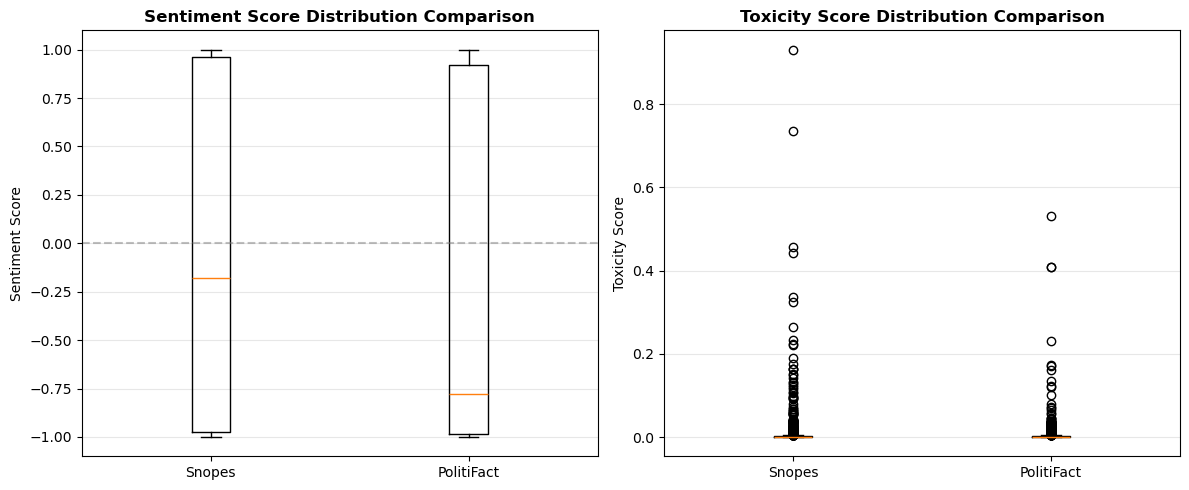

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Sentiment comparison
axes[0].boxplot([tox_sen['sentiment_score_sn_body'], 
                 tox_sen['sentiment_score_pf_body']],
                labels=['Snopes', 'PolitiFact'])
axes[0].set_title('Sentiment Score Distribution Comparison', fontweight='bold')
axes[0].set_ylabel('Sentiment Score')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Neutral')

# Toxicity comparison
axes[1].boxplot([tox_sen['toxicity_score_sn_body'], 
                 tox_sen['toxicity_score_pf_body']],
                labels=['Snopes', 'PolitiFact'])
axes[1].set_title('Toxicity Score Distribution Comparison', fontweight='bold')
axes[1].set_ylabel('Toxicity Score')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

#### 6.1.2.2. Filtering for a similarity threshold where almost no mismatches occur

To see whether this discrepency in the median occurs because of mismatched claims, we use the threshold 0.649 from section 5.1.2. where we projected the results from the manual quality check onto the entire dataset to see at which threshold false matches do not occur anymroe. False matches can cause matched Snopes and Politifact articles to have largely differing sentiment scores which can unintentionally skew the results for either Politifact or Snopes.

After filtering for matches with a similarity score of 0.649 and higher, and replotting the histogram, quantiles, and boxplots, only a small change in the medians for both Snopes and Politifact is visible. Both organizations now recieve a slightly more positive sentiment score, however, the difference is not very prominent and the medians are both still largely in the negative, especially for Politifact. This demonstrates that Politifact tends to incorporate a more negative tone in their articles compared to Snopes, which can not be attributed to the error margin from the tf-idf algorithm used to match the claims. 

Snopes Sentiment Quantiles:
  Min (0%):    -1.000
  Q1 (25%):    -0.978 - 25% of claims more negative
  Median (50%): -0.179 - middle value
  Q3 (75%):    0.966 - 25% of claims more positive
  Max (100%):  1.000

PolitiFact Sentiment Quantiles:
  Min (0%):    -1.000
  Q1 (25%):    -0.985
  Median (50%): -0.651
  Q3 (75%):    0.933
  Max (100%):  1.000


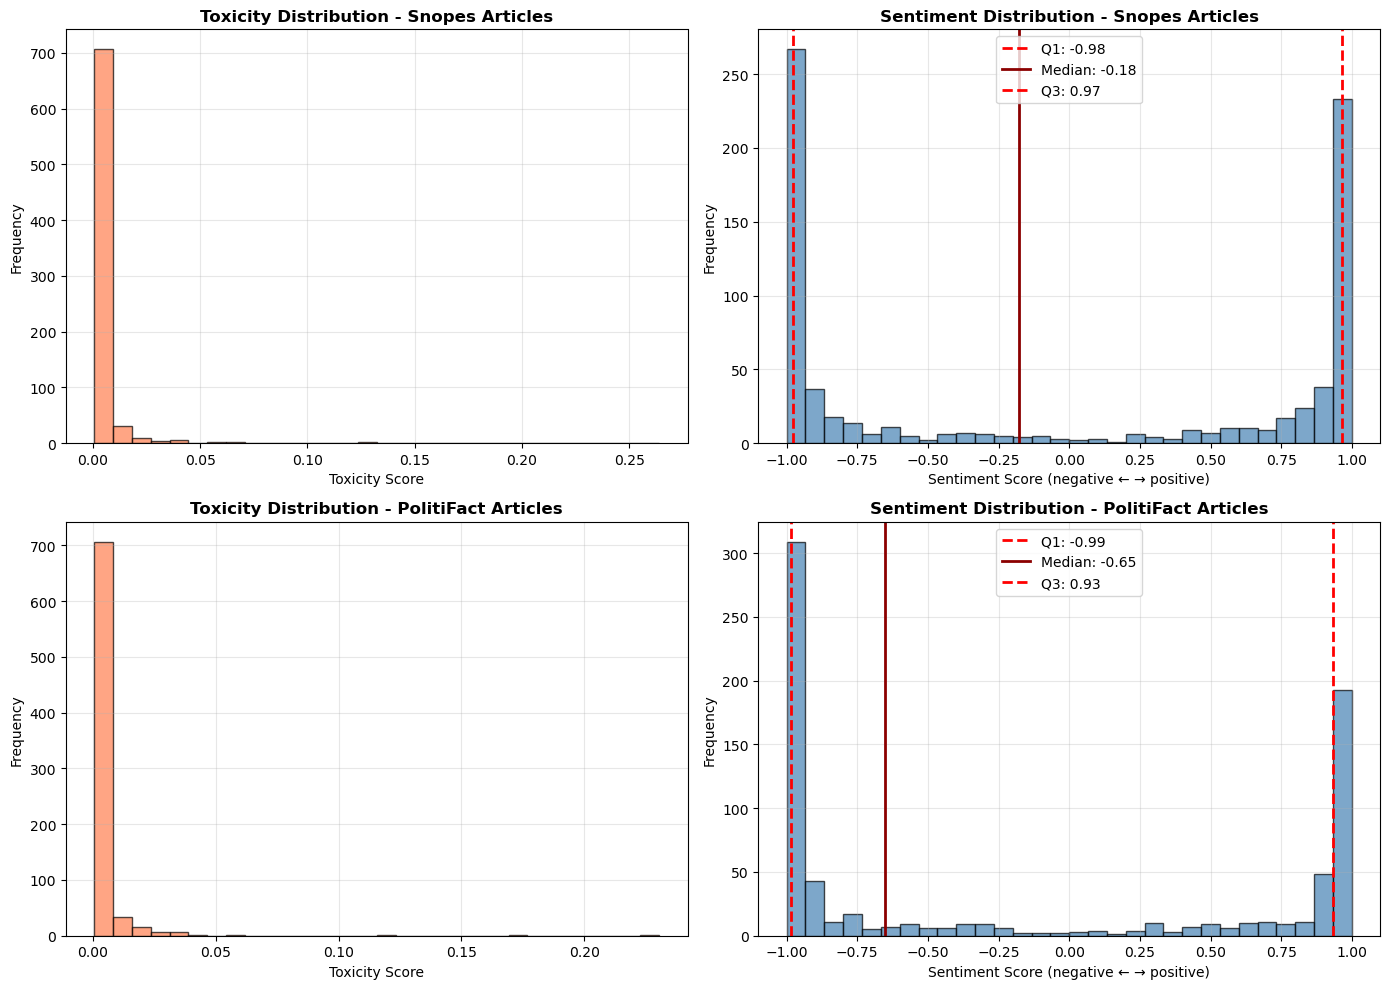

In [ ]:
# Filter for rows with a similarity_score of 0.649 and higher
tox_sen_filt = tox_sen[(tox_sen['similarity_score'] >= 0.649)]

# Calculate quantiles
q_sn = np.quantile(tox_sen_filt['sentiment_score_sn_body'], q=[0, 0.25, 0.5, 0.75, 1])
q_pf = np.quantile(tox_sen_filt['sentiment_score_pf_body'], q=[0, 0.25, 0.5, 0.75, 1])

print("Snopes Sentiment Quantiles:")
print(f"  Min (0%):    {q_sn[0]:.3f}")
print(f"  Q1 (25%):    {q_sn[1]:.3f} - 25% of claims more negative")
print(f"  Median (50%): {q_sn[2]:.3f} - middle value")
print(f"  Q3 (75%):    {q_sn[3]:.3f} - 25% of claims more positive")
print(f"  Max (100%):  {q_sn[4]:.3f}")

print("\nPolitiFact Sentiment Quantiles:")
print(f"  Min (0%):    {q_pf[0]:.3f}")
print(f"  Q1 (25%):    {q_pf[1]:.3f}")
print(f"  Median (50%): {q_pf[2]:.3f}")
print(f"  Q3 (75%):    {q_pf[3]:.3f}")
print(f"  Max (100%):  {q_pf[4]:.3f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Toxicity - Snopes
axes[0, 0].hist(tox_sen_filt['toxicity_score_sn_body'], bins=30, 
                edgecolor='black', alpha=0.7, color='coral')
axes[0, 0].set_title('Toxicity Distribution - Snopes Articles', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Toxicity Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Toxicity - Politifact
axes[1, 0].hist(tox_sen_filt['toxicity_score_pf_body'], bins=30, 
                edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].set_title('Toxicity Distribution - PolitiFact Articles', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Toxicity Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Sentiment - Snopes with quantiles
axes[0, 1].hist(tox_sen_filt['sentiment_score_sn_body'], bins=30, 
                edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(x=q_sn[1], color='red', linestyle='--', linewidth=2, label=f'Q1: {q_sn[1]:.2f}')
axes[0, 1].axvline(x=q_sn[2], color='darkred', linestyle='-', linewidth=2, label=f'Median: {q_sn[2]:.2f}')
axes[0, 1].axvline(x=q_sn[3], color='red', linestyle='--', linewidth=2, label=f'Q3: {q_sn[3]:.2f}')
axes[0, 1].set_title('Sentiment Distribution - Snopes Articles', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Sentiment Score (negative ← → positive)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Sentiment - Politifact with quantiles
axes[1, 1].hist(tox_sen_filt['sentiment_score_pf_body'], bins=30, 
                edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 1].axvline(x=q_pf[1], color='red', linestyle='--', linewidth=2, label=f'Q1: {q_pf[1]:.2f}')
axes[1, 1].axvline(x=q_pf[2], color='darkred', linestyle='-', linewidth=2, label=f'Median: {q_pf[2]:.2f}')
axes[1, 1].axvline(x=q_pf[3], color='red', linestyle='--', linewidth=2, label=f'Q3: {q_pf[3]:.2f}')
axes[1, 1].set_title('Sentiment Distribution - PolitiFact Articles', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Sentiment Score (negative ← → positive)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_20852\1664135296.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([tox_sen_filt['sentiment_score_sn_body'],
C:\Users\phili\AppData\Local\Temp\ipykernel_20852\1664135296.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([tox_sen_filt['toxicity_score_sn_body'],


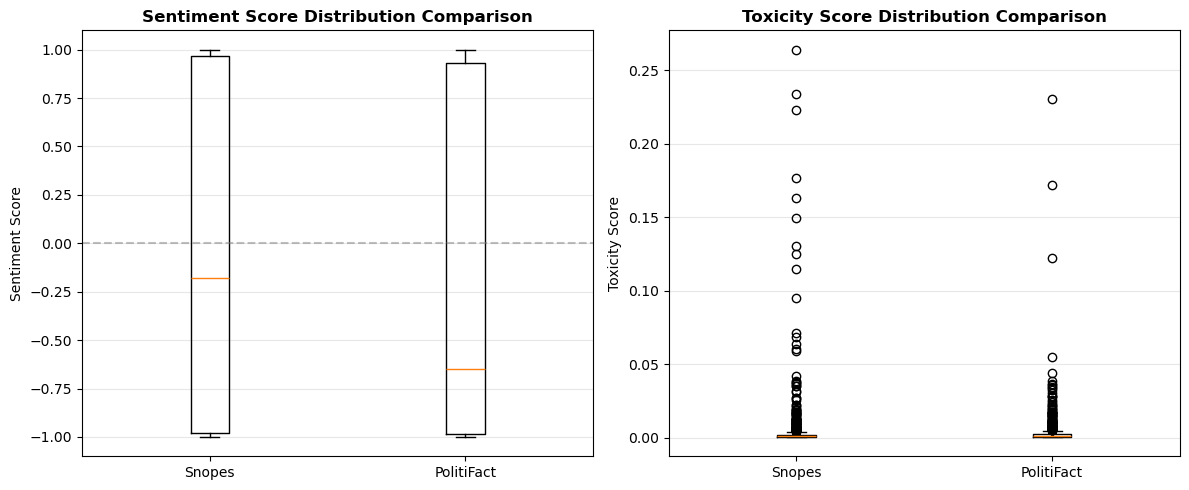

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Sentiment comparison
axes[0].boxplot([tox_sen_filt['sentiment_score_sn_body'], 
                 tox_sen_filt['sentiment_score_pf_body']],
                labels=['Snopes', 'PolitiFact'])
axes[0].set_title('Sentiment Score Distribution Comparison', fontweight='bold')
axes[0].set_ylabel('Sentiment Score')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Neutral')

# Toxicity comparison
axes[1].boxplot([tox_sen_filt['toxicity_score_sn_body'], 
                 tox_sen_filt['toxicity_score_pf_body']],
                labels=['Snopes', 'PolitiFact'])
axes[1].set_title('Toxicity Score Distribution Comparison', fontweight='bold')
axes[1].set_ylabel('Toxicity Score')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6.2. Toxicity and Sentiment Scores Controlled For Ratings

Here we look at a conditional distribution of sentiment and toxicity scores against different rating levels to see whether sentiment and toxicity scores are correlated with the truthfulness of a claim. 

The boxplot for toxicity shows that almost all articles have a toxicity score of 0.0. However, the outliers for both Politifact and Snopes reveal that toxicity score increases as truthfulness decreases. 

While the boxplots for sentiment scores show that sentiment for each category is very spread out between -1 and 1, the medians tell a different truth. The medians for Politifact has a very clear pattern where the median tends to become more positive the more truthful the claim is. Even the IQR shifts towards a positive sentiment. Their articles' sentiment serves as an additional signal of veracity: negative language reinforces false ratings, while positive language reinforces true ratings. While Snopes, on the other hand, has more 'random' medians, possibly suggesting that the sentiment of Snopes' articles aren't necessarily correlated with truthfulness as their articles may potentially maintain a more neutral and explanatory style. Their articles possibly focus more on presenting evidence and context rather than adopting an evaluative tone. 

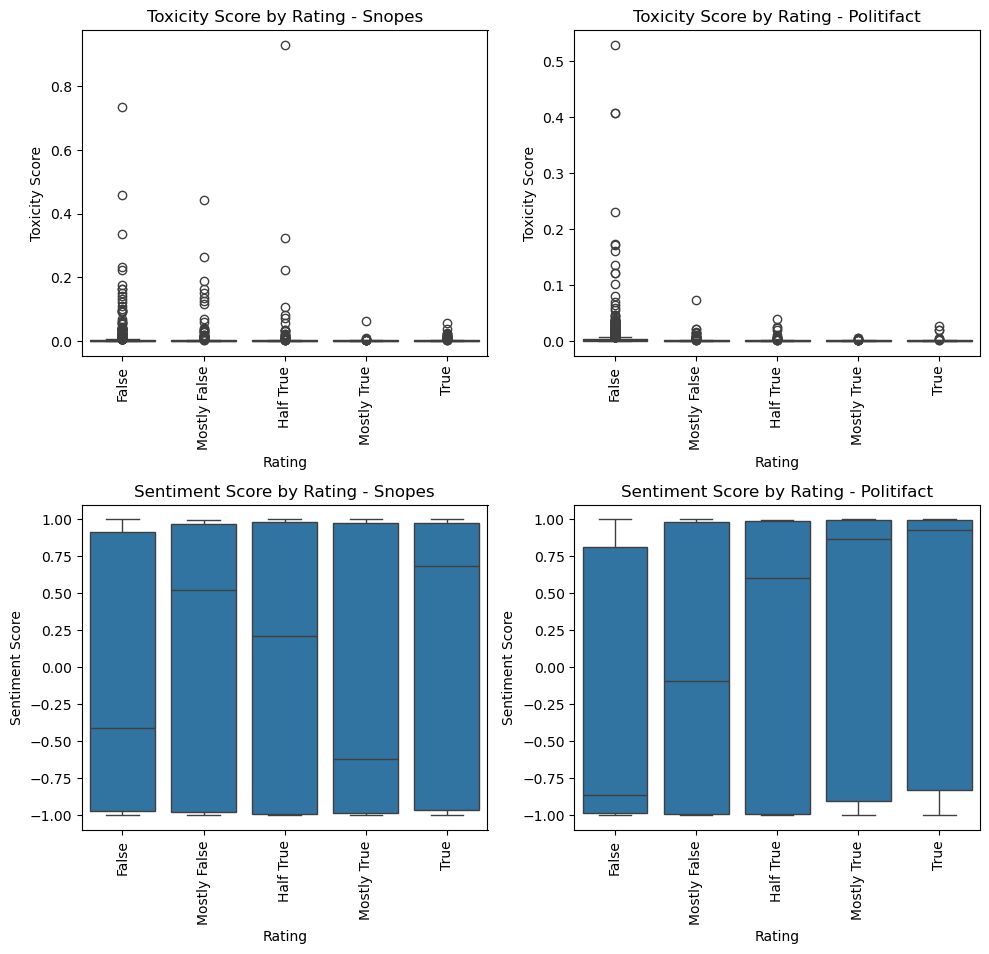

<Figure size 640x480 with 0 Axes>

In [115]:
plt.figure(figsize=(10, 18))

custom_order_rating = ['False', 'Mostly False', 'Half True', 'Mostly True', 'True']

tox_sen['normalized_rating_sn'] = pd.Categorical(
    tox_sen['normalized_rating_sn'], categories=custom_order_rating, ordered=True
)
tox_sen['normalized_rating_pf'] = pd.Categorical(
    tox_sen['normalized_rating_pf'], categories=custom_order_rating, ordered=True
)

# Box plot of toxicity scores by rating - Snopes
plt.subplot(4, 2, 1)
sns.boxplot(x='normalized_rating_sn', y='toxicity_score_sn_body', data=tox_sen)
plt.title('Toxicity Score by Rating - Snopes')
plt.xlabel('Rating')
plt.ylabel('Toxicity Score')
plt.xticks(rotation=90)

# Box plot of toxicity scores by rating - Politifact
plt.subplot(4, 2, 2)
sns.boxplot(x='normalized_rating_pf', y='toxicity_score_pf_body', data=tox_sen)
plt.title('Toxicity Score by Rating - Politifact')
plt.xlabel('Rating')
plt.ylabel('Toxicity Score')
plt.xticks(rotation=90)

# Box plot of sentiment scores by rating - Snopes
plt.subplot(4, 2, 3)
sns.boxplot(x='normalized_rating_sn', y='sentiment_score_sn_body', data=tox_sen)
plt.title('Sentiment Score by Rating - Snopes')
plt.xlabel('Rating')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=90)

# Box plot of sentiment scores by rating - Politifact
plt.subplot(4, 2, 4)
sns.boxplot(x='normalized_rating_pf', y='sentiment_score_pf_body', data=tox_sen)
plt.title('Sentiment Score by Rating - Politifact')
plt.xlabel('Rating')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### 6.2.1. Correlation Heat Map

Based on the correlation heatmap, both Politifact and Snopes generally agree on toxicty, sentiment, and (numerical) rating scores across matched claims, with most correlations having a p-value below 0.001. Except for the correlation between the sentiment and rating for Snopes which has a p-value of 0.0034.

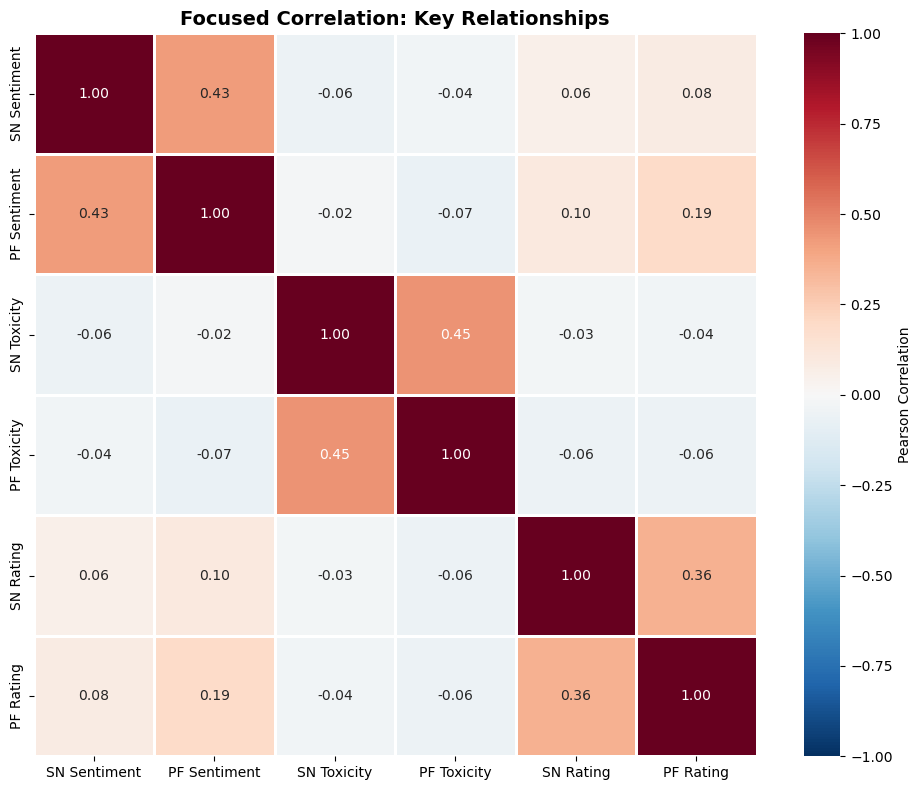


STATISTICAL SIGNIFICANCE TESTS

Sentiment → Rating:
  Snopes:     r=0.062, p=0.0032 **
  PolitiFact: r=0.189, p=0.0000 ***

Cross-site Agreement:
  Sentiment: r=0.426, p=0.0000 ***
  Toxicity:  r=0.452, p=0.0000 ***

Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


In [135]:
# Define the mapping
rating_mapping = {
    'False': 1,
    'Mostly False': 2,
    'Half True': 3,
    'Mostly True': 4,
    'True': 5
}

tox_sen['numeric_rating_sn'] = tox_sen['normalized_rating_sn'].map(rating_mapping)
tox_sen['numeric_rating_pf'] = tox_sen['normalized_rating_pf'].map(rating_mapping)

# Create a focused view on key relationships
focused_data = tox_sen[[
    'sentiment_score_sn_body',
    'numeric_rating_sn',
    'sentiment_score_pf_body',
    'numeric_rating_pf',
    'toxicity_score_sn_body',
    'toxicity_score_pf_body'
]]

focused_data.columns = [
    'SN Sentiment',
    'SN Rating',
    'PF Sentiment', 
    'PF Rating',
    'SN Toxicity',
    'PF Toxicity'
]

# Reorder for logical grouping
column_order = [
    'SN Sentiment', 'PF Sentiment',
    'SN Toxicity', 'PF Toxicity',
    'SN Rating', 'PF Rating'
]
focused_data = focused_data[column_order]

corr_focused = focused_data.corr()

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_focused, 
            annot=True, 
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            vmin=-1, vmax=1,
            square=True,
            linewidths=2,
            cbar_kws={'label': 'Pearson Correlation'})

plt.title('Focused Correlation: Key Relationships', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

from scipy.stats import pearsonr

def correlation_with_pvalue(x, y):
    """Calculate correlation and p-value"""
    corr, pval = pearsonr(x.dropna(), y.dropna())
    return corr, pval

# Test key relationships
print("\n" + "="*60)
print("STATISTICAL SIGNIFICANCE TESTS")
print("="*60)

# Sentiment → Rating
corr_sn, pval_sn = correlation_with_pvalue(
    tox_sen['sentiment_score_sn_body'], 
    tox_sen['numeric_rating_sn']
)
corr_pf, pval_pf = correlation_with_pvalue(
    tox_sen['sentiment_score_pf_body'], 
    tox_sen['numeric_rating_pf']
)

print("\nSentiment → Rating:")
print(f"  Snopes:     r={corr_sn:.3f}, p={pval_sn:.4f} {'***' if pval_sn < 0.001 else '**' if pval_sn < 0.01 else '*' if pval_sn < 0.05 else 'ns'}")
print(f"  PolitiFact: r={corr_pf:.3f}, p={pval_pf:.4f} {'***' if pval_pf < 0.001 else '**' if pval_pf < 0.01 else '*' if pval_pf < 0.05 else 'ns'}")

# Cross-site agreement
corr_sent, pval_sent = correlation_with_pvalue(
    tox_sen['sentiment_score_sn_body'], 
    tox_sen['sentiment_score_pf_body']
)
corr_tox, pval_tox = correlation_with_pvalue(
    tox_sen['toxicity_score_sn_body'], 
    tox_sen['toxicity_score_pf_body']
)

print("\nCross-site Agreement:")
print(f"  Sentiment: r={corr_sent:.3f}, p={pval_sent:.4f} {'***' if pval_sent < 0.001 else '**' if pval_sent < 0.01 else '*' if pval_sent < 0.05 else 'ns'}")
print(f"  Toxicity:  r={corr_tox:.3f}, p={pval_tox:.4f} {'***' if pval_tox < 0.001 else '**' if pval_tox < 0.01 else '*' if pval_tox < 0.05 else 'ns'}")

print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

# 7. Sub-question 2 - *What thematic patterns are common across "Fake" and “Real” claims as rated by PolitiFact and Snopes?*

## 7.1. Clean Text for Clustering and Topic Modelling

The following section has been commented out due to a long compute time. The data has been saved and reloaded in the following section.

In [2]:
# tox_sen = pd.read_csv('data/results/tox_and_sent_scores.csv')

# # Prepare data
# columns = ['claim_sn', 'claim_pf', 'body_sn', 'body_pf', 'veracity_sn', 'veracity_pf']
# cleaned_text = pd.DataFrame()
# cleaned_text[columns] = tox_sen[columns].astype(str)

# # Function to clean text
# def clean_text(doc):
#     """Clean spaCy doc object"""
#     tokens = [token.lemma_.lower() for token in doc 
#               if not token.is_stop 
#               and not token.is_punct 
#               and not token.is_space
#               and token.text.lower() not in stop_words]
#     return ' '.join(tokens)

# # For speed, process in batches using nlp.pipe()
# print("Processing Snopes articles...")
# docs_sn = list(tqdm(
#     nlp.pipe(cleaned_text['body_sn'], batch_size=50),
#     total=len(cleaned_text)
# ))

# print("Processing PolitiFact articles...")
# docs_pf = list(tqdm(
#     nlp.pipe(cleaned_text['body_pf'], batch_size=50),
#     total=len(cleaned_text)
# ))

# # Store results
# cleaned_text['nlp_sn'] = docs_sn
# cleaned_text['nlp_pf'] = docs_pf

# # Clean the docs
# print("Cleaning text...")
# cleaned_text['clean_sn'] = [clean_text(doc) for doc in tqdm(docs_sn)]
# cleaned_text['clean_pf'] = [clean_text(doc) for doc in tqdm(docs_pf)]

# # Save cleaned_text to csv
# cleaned_text.to_csv('data/results/cleaned_text.csv')

# print("✅ Done!")

## 7.2 K-means Clustering

### 7.2.1. TF-IDF Calculation

In [75]:
# Load cleaned & lemmatized text
cleaned_text = pd.read_csv('data/results/cleaned_text.csv')

# Rebuild the TF-IDF vectorizer
vectorizer = TfidfVectorizer(min_df=2, max_df=0.4, norm='l2')

# Fit on all Snopes + PolitiFact cleaned text
all_text = pd.concat([cleaned_text['clean_sn'], cleaned_text['clean_pf']])
vectorizer.fit(all_text)

# Categories and sources
veracity = ['Real', 'Mixed', 'Fake']
orgs = ['sn', 'pf']

# Storage dicts
cleaned_data = {}
X_data = {}
tfidf_data = {}

for v in veracity:
    for org in orgs:
        subset = cleaned_text[cleaned_text[f'veracity_{org}'] == v]
        subset = subset.copy()
        subset[f'date'] = tox_sen[tox_sen[f'veracity_{org}'] == v][f'date_{org}']
        cleaned_data[f'{v.lower()}_{org}'] = subset

        # Transform Snopes
        X = vectorizer.transform(subset[f'clean_{org}'])
        X_data[f'{v.lower()}_{org}'] = X
        tfidf_data[f'{v.lower()}_{org}'] = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Print TF-IDF matrix sizes
for key, df in tfidf_data.items():
    print(key, df.shape)


real_sn (334, 22577)
real_pf (142, 22577)
mixed_sn (317, 22577)
mixed_pf (163, 22577)
fake_sn (1593, 22577)
fake_pf (1939, 22577)


### 7.2.2. Dimensionality Reduction

In [76]:
# Choose number of components (tweak if needed)
n_components = 100

datasets = {}

# Separate SVD per dataset (fine because we cluster them separately)
for key, data in X_data.items():
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    datasets[key] = svd.fit_transform(data)

### 7.2.3. Best K-Means Cluster Size (K)

To measure the optimal number of clusters to separate Real, Mixed, and Fake claims, we use three metrics: The Silhouette Score, the Calinski-Harabasz Index, and the Davies-Bouldin Index.

- The Silhouette Score quantifies how well-separated the clusters are and how internally cohesive they are.
- The Calinski-Harabasz (CH) Index shows the ratio between-cluster dispersion to within-cluster dispersion. A higher value means the clusters are more dense and better separated.
- The Davies-Bouldin (DB) Index measures the compactness of clusters and the separation between them. A lower DB index score indicates better clustering.

Each metric reveals a different aspect of the clusters, and by using all three of these metrics, we can make informed decisions on the optimal k value.

**Real Claims**: Both Snopes and PolitiFact show high k values of 13 and 14, respectively. For both organizations, the Silhouette Score increases consistently while the DB index decreases in the same manner. The trend strongly suggests that the increase in the silhouette score would continue steadily till the number of clusters reaches the same value of documents available. This likely occurs because there are only 64 documents available for Real claims from each organization, and each fact-checked claim tends to correspond to a new unique real-world issue. In other words, there is not enough data for the clustering algorithm to find higher-level thematic structure, leading to the algorithm essentially classifying each document as its own topic.

**Mixed Claims**: Mixed claims reveal notable differences between the two organizations. Snopes shows an optimal k value of 3, suggesting relatively few distinct thematic clusters. In contrast, PolitiFact exhibits a higher k value of 10, indicating more diverse topical coverage within mixed claims. This difference may reflect organizational variations in how mixed-veracity claims are categorized or the types of claims each organization tends to fact-check in this category.

**Fake Claims**: Both organizations show similar clustering patterns for Fake claims, with optimal k values around 4 for Snopes and 4 for PolitiFact. At these k values, the CH index peaks while maintaining relatively low DB values and moderate Silhouette scores. Compared to Real and Mixed claims, Fake claims from both organizations appear to be more focused around specific recurring topics, which we will explore in the next section.

### 7.2.4. Analyzing Clustering Results with SVD Dimensionality Reduction (n=100)

The clustering results reveal strong structural differences between Real, Mixed, and Fake claims across both fact-checking organizations. Both Snopes and PolitiFact show similar patterns where Real claims fragment into many small clusters while Fake claims cluster into only 4 coherent groups. This aligns with expected linguistic and narrative behaviour where truth is specific and falsehood generalizes.

### 7.2.4.1. Cluster Size Distribution

The cluster size distributions reveal significant patterns about how different types of claims organize thematically across both fact-checking organizations.

**Real Claims**: Both Snopes and PolitiFact exhibit highly fragmented clustering patterns with 12 and 14 clusters respectively. The distribution is notably uneven - for Snopes, cluster 5 (COVID-19 pandemic response) dominates with 182 documents while most other clusters contain fewer than 13 documents each, covering diverse topics from gun violence to corporate taxation. PolitiFact shows a similar pattern with clusters 2 (Legislative bills & trafficking, 45 documents) and 3 (Police shootings & Capitol riots, 52 documents) being largest, while many clusters contain only 2-9 documents covering topics like international trade, cultural symbols, and veterans' issues. This fragmentation reflects the nature of real claims: each tends to address a distinct, specific real-world issue or event, making it difficult for the clustering algorithm to identify broader thematic patterns with only 64 documents available per organization.

**Mixed Claims**: The two organizations show markedly different clustering behaviors for mixed-veracity claims. Snopes produces only 4 clusters with an extremely imbalanced distribution - cluster 0 (Youth activism & education) contains 235 of the 317 documents (74%), suggesting that most mixed claims revolve around contentious topics involving Sandmann, Thunberg, and educational controversies. In contrast, PolitiFact generates 10 more evenly distributed clusters, with the largest being cluster 4 (Mail voting procedures, 50 documents) and cluster 1 (Water infrastructure crises, 37 documents). Other substantial clusters cover topics like jobs & border policy (cluster 2), minimum wage & labor rights (cluster 8), and legislative votes & bankruptcy (cluster 7). This difference may indicate that PolitiFact's mixed claims cover more diverse policy areas and political issues, while Snopes' mixed claims tend to converge around youth-related controversies and educational debates.

**Fake Claims**: Both organizations show extreme cluster imbalance in their fake claim datasets, but the dominant clusters differ meaningfully. Snopes' cluster 1 (Fabricated quotes & memes) contains 1,314 of 1,508 documents (87%), encompassing misattributed statements to Clinton, Pelosi, Soros, and various tax hoaxes. PolitiFact's cluster 0 (Viral photos & videos) contains 1,510 of 1,939 documents (78%), dominated by manipulated images of Biden, flag hoaxes, and police footage. The remaining smaller clusters represent more specialized misinformation categories: election fraud narratives (cluster 0 for Snopes with 89 documents, cluster 3 for PolitiFact with 109 documents) and COVID anti-vaccine conspiracy theories (cluster 2 for both organizations with 5 and 208 documents respectively). These massive dominant clusters suggest that the vast majority of fake claims follow predictable patterns - fabricated quotes and viral manipulated media represent the primary vehicles for misinformation spread.

Overall, the cluster size distributions support the hypothesis that truth is diverse and specific while falsehood tends toward repetitive patterns and common narratives. The fragmentation in real claims versus the concentration in fake claims reflects fundamental differences in how factual information versus misinformation propagates and manifests linguistically.

<u>Real Claims - Snopes (k = 12)</u>

| Cluster | Size | Topic label                           | Short description                                          |
| ------: | ---: | ------------------------------------- | ---------------------------------------------------------- |
|       0 |   13 | Rittenhouse & Floyd protests          | Kyle Rittenhouse, George Floyd, Kenosha, police shootings  |
|       1 |   30 | Supreme Court & electoral politics    | Senate nominations, Barrett confirmation, Gaetz, voting    |
|       2 |   30 | COVID-19 pandemic response            | Vaccines, CDC, testing, death counts, coronavirus cases    |
|       3 |   22 | Tax policy & unemployment benefits    | Income tax, IRS, veterans, stimulus, Amazon deductions     |
|       4 |    8 | Capitol riot & monuments              | Capitol guards, slavery memorials, Pence, Lincoln, troops  |
|       5 |  182 | General political narratives          | Moon landing, photos, Clinton, Obama, Epstein, campaigns   |
|       6 |    5 | Currency & trade symbolism            | Reagan coins, Tubman, pledge of allegiance, foundation     |
|       7 |   10 | School shootings & gun laws           | AR-15, Boulder shooting, elementary schools, backgrounds   |
|       8 |    8 | NASA & space exploration              | Mars rover, asteroids, Hubble telescope, prayer proclamations |
|       9 |    2 | Domain redirects & websites           | Antifa URLs, Biden domains, whitehouse.gov registrations   |
|      10 |   12 | Election administration               | Mail ballots, absentee voting, Georgia recounts, officials |
|      11 |   12 | Border security & immigration         | Migrant children, asylum, Mexico wall, El Paso, caravans   |

<u>Real Claims - PolitiFact (k = 14)</u>

| Cluster | Size | Topic label                           | Short description                                          |
| ------: | ---: | ------------------------------------- | ---------------------------------------------------------- |
|       0 |    2 | China PPE donations                   | Protective equipment, masks, gowns, Pompeo, WHO director   |
|       1 |    6 | Police protests & Blue Lives Matter   | Flag controversies, thin blue line, Capitol, rally deaths  |
|       2 |   45 | Criminal justice & governors          | Gun laws, marijuana, school policies, arrests, Ryan Moore  |
|       3 |   52 | Federal legislation & taxation        | Bills, Obama administration, Gaetz, testing, income tax    |
|       4 |    4 | Mass shooting weapons                 | AR-15 rifles, synagogue attacks, Orlando, Poway shootings  |
|       5 |    2 | Veterans parade funding               | Event organizers, city contributions, misstatements        |
|       6 |    2 | Slavery & White House construction    | Enslaved laborers, Michelle Obama's ancestors, quarries    |
|       7 |    2 | Rally interruptions                   | Ted Cruz hecklers, Bernie protesters, town hall yelling    |
|       8 |    2 | Georgia voter ID laws                 | Food/water bans, voter registration, gender requirements   |
|       9 |    2 | Cabinet approval ratings              | Betsy DeVos polls, unfavorability, YouGov polling data     |
|      10 |    5 | Impeachment proceedings               | Clinton, Trump trials, House votes, witness testimony      |
|      11 |    9 | Electoral College margins             | Popular vote, county results, McConnell, close victories   |
|      12 |    2 | Border tear gas incidents             | Obama administration, DHS, pepper spray, migrant crossings |
|      13 |    7 | Veterans & military service           | Blumenthal, Gabbard, deportations, Vietnam, suicide rates  |

<u>Mixed Claims - Snopes (k = 4)</u>

| Cluster | Size | Topic label                           | Short description                                          |
| ------: | ---: | ------------------------------------- | ---------------------------------------------------------- |
|       0 |  235 | General political & legal claims      | Court cases, bills, police, Obama, Biden, abortion laws    |
|       1 |   22 | Election procedures                   | Mail ballots, electoral counts, California voting laws     |
|       2 |   53 | COVID-19 health measures              | Vaccines, CDC guidelines, masks, testing, patient care     |
|       3 |    7 | Mass shootings                        | El Paso, police incidents, victims, suspect definitions    |

<u>Mixed Claims - PolitiFact (k = 10)</u>

| Cluster | Size | Topic label                           | Short description                                          |
| ------: | ---: | ------------------------------------- | ---------------------------------------------------------- |
|       0 |    4 | Tech privacy & contact tracing        | Apple/Google scanning, iOS updates, child safety, health   |
|       1 |   37 | Abortion & education policy           | School laws, Pence conversion therapy, court votes, bans   |
|       2 |    6 | Keystone Pipeline & gas prices        | XL pipeline jobs, Biden, energy costs, oil industry        |
|       3 |    2 | Marijuana legalization                | Colorado surveys, school use increases, recreational pot   |
|       4 |   50 | Border & political figures            | Harris, Kavanaugh, Mexico caravans, flags, flu comparisons |
|       5 |    9 | Mail ballot procedures                | Postal deadlines, absentee voting, service delays          |
|       6 |    3 | Rittenhouse shooting                  | Kenosha incident, Blake shooting, white supremacy claims   |
|       7 |    3 | COVID hospital payments               | Medicare ventilator reimbursements, patient deaths, golf   |
|       8 |   43 | Labor & international policy          | Minimum wage, Saudi Arabia, Taliban, Carrier, Iran deals   |
|       9 |    6 | Flint water crisis                    | Lead pipes, Sanders, drinking safety, arsenic levels       |

<u>Fake Claims - Snopes (k = 4)</u>

| Cluster | Size | Topic label                           | Short description                                          |
| ------: | ---: | ------------------------------------- | ---------------------------------------------------------- |
|       0 |   89 | Election fraud narratives             | Ballot fraud, voter counts, 2020 election, Biden polls     |
|       1 | 1314 | General viral misinformation          | Photos, videos, fake quotes, memes, Clinton, Obama, Biden  |
|       2 |    5 | Disney urban legends                  | Cinderella castle, park rumors, princess costumes, boxes   |
|       3 |  185 | COVID-19 conspiracy theories          | Vaccine misinformation, CDC distrust, mask myths, health   |

<u>Fake Claims - PolitiFact (k = 4)</u>

| Cluster | Size | Topic label                           | Short description                                          |
| ------: | ---: | ------------------------------------- | ---------------------------------------------------------- |
|       0 | 1610 | General viral misinformation          | Photos, fake stories, quotes, flags, Clinton, Obama, Biden |
|       1 |   12 | Ilhan Omar conspiracies               | CAIR, terrorist accusations, Minnesota, Somalia, arrests   |
|       2 |  208 | COVID-19 conspiracy theories          | Vaccine death claims, CDC tweets, mask mandates, flu       |
|       3 |  109 | Election fraud narratives             | Mail ballot fraud, Georgia registration, absentee voting   |

### 7.2.3. 

To measure the optimal number of clusters to separate Real, Mixed, and Fake claims, we use three metrics: The Silhouette Score, the Calinski-Harabasz Index, and the Davies-Bouldin Index.

- The Silhouette Score quantifies how well-separated the clusters are and how internally cohesive they are.
- The Calinski-Harabasz (CH) Index shows the ratio between-cluster dispersion to within-cluster dispersion. A higher value means the clusters are more dense and better separated.
- The Davies-Bouldin (DB) Index measures the compactness of clusters and the separation between them. A lower DB index score indicates better clustering.

Each metric reveals a different aspect of the clusters, and by using all three of these metrics, we can make informed decisions on the optimal k value.

Using the optimal k value, we can then inspect the top words per cluster to evaluate what topics the k-means clustering method discovers within the data. We can also assign each document a topic number to evaluate the proportion of claims per topic cluster.

#### **Results**

##### <u> Metric Results </u>
Snopes:
- real_sn (k=12)
    - Silhouette increases steadily until ~12; CH peaks around 12; DB decreases → clear monotonic improvement with larger k.
    - Shape suggests heterogeneous topics that separate cleanly when many clusters are used.
- mixed_sn (k=4)
    - Metrics flatten or drop quickly after k=4.
    - Data is more homogeneous; only a few stable themes.
- fake_sn (k=4)
    - Similar to mixed_sn: high early performance, then plateaus → four dominant themes.

Snopes' real claims span many distinct topic domains, while mixed and fake claims favour smaller numbers of large thematic groups

Politifact:
- real_pf (k=14)
    - Silhouette improves slowly; CH has multiple local peaks; DB falls gradually.
    - Patterns less smooth than Snopes but still favour high k → many granular themes.
- mixed_pf (k=10)
    - Varying curves but no improvement past ~10 → moderately diverse topics.
- fake_pf (k=4)
    - Curves drop and plateau, again favouring small k → similar thematic compression as Snopes’ fake set.

Real and mixed claims show more detailed topic distributions for Politifact, but fake content again cluster ideally into only a few broad themes.

Snopes vs Politifact:
- Real claims:
    - Both rich in topic diversity with PF slightly more fragmented (k=14) than SN (k=12)
- Mixed: 
    - PF shows more topic variation (k=10) than SN (k=4). 
- Fake:
    - Both dominated by a small number of topics (k=4) highlighting that fake claims tend to revolve around limited narratives.

##### <u> Topic Results </u>
Snopes - Real: 
- Very imbalanced - more than half of documents in cluster 5 (54%).
- Cluster 5 mixes political and general rumours.
- Documents are more spread out amongst its clusters compared to Politifact.

Politifact - Real:
- Also imbalanced with most documents in cluster 2 and 3 (68% combined)
- Many more nice clusters with only a few documents.
- Seems to be more political-institutional centric.



In [166]:
def select_optimal_k(k_values, silhouette_scores, ch_scores, db_scores):
    """
    Select optimal k by ranking each metric and summing ranks.
    
    Parameters:
    -----------
    k_values : list
        List of k values tested
    silhouette_scores : list
        Silhouette scores (higher is better)
    ch_scores : list
        Calinski-Harabasz scores (higher is better)
    db_scores : list
        Davies-Bouldin scores (lower is better)
    
    Returns:
    --------
    tuple: (optimal_k, total_ranks)
    """
    sil_rank = np.argsort(np.argsort(silhouette_scores))      # larger better
    ch_rank = np.argsort(np.argsort(ch_scores))               # larger better
    db_rank = np.argsort(np.argsort([-d for d in db_scores])) # smaller better (inverted)
    total_ranks = sil_rank + ch_rank + db_rank
    best_idx = np.argmax(total_ranks)
    return k_values[best_idx], total_ranks


def evaluate_clustering_metrics(svd_datasets, k_values):
    """
    Calculate clustering quality metrics for multiple k values across datasets.
    
    Parameters:
    -----------
    svd_datasets : dict
        Dictionary of SVD-reduced data matrices
    k_values : range or list
        Range of k values to test
    
    Returns:
    --------
    tuple: (metric_scores, optimal_k_values)
        - metric_scores: dict with silhouette, CH, and DB scores for each dataset
        - optimal_k_values: dict mapping dataset names to optimal k values
    """
    metric_scores = {}
    optimal_k_values = {}

    for dataset_name, reduced_data in svd_datasets.items():
        silhouette_scores = []
        ch_scores = []
        db_scores = []

        for k in tqdm(k_values, desc=f"Processing {dataset_name}", total=len(k_values)):
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(reduced_data)

            silhouette_scores.append(silhouette_score(reduced_data, labels))
            ch_scores.append(calinski_harabasz_score(reduced_data, labels))
            db_scores.append(davies_bouldin_score(reduced_data, labels))

        # Store all scores
        metric_scores[f'{dataset_name}_silhouette'] = silhouette_scores
        metric_scores[f'{dataset_name}_ch'] = ch_scores
        metric_scores[f'{dataset_name}_db'] = db_scores
        
        # Determine optimal k
        optimal_k, ranks = select_optimal_k(list(k_values), silhouette_scores, ch_scores, db_scores)
        optimal_k_values[dataset_name] = optimal_k
        print(f"{dataset_name}: Best k = {optimal_k}")

    return metric_scores, optimal_k_values


def plot_clustering_metrics(svd_datasets, metric_scores, k_values, optimal_k_values):
    """
    Visualize clustering quality metrics across multiple k values.
    
    Parameters:
    -----------
    svd_datasets : dict
        Dictionary of dataset names
    metric_scores : dict
        Dictionary containing metric scores for each dataset
    k_values : range or list
        Range of k values tested
    optimal_k_values : dict
        Dictionary mapping dataset names to optimal k values
    """
    n_datasets = len(svd_datasets)
    fig, axes = plt.subplots(nrows=n_datasets, ncols=3, figsize=(15, 4 * n_datasets))
    fig.suptitle("Cluster Quality Metrics Across Datasets (TF-IDF + SVD)", fontsize=18)

    cmap = plt.colormaps.get_cmap("tab10")

    for row_idx, dataset_name in enumerate(svd_datasets.keys()):
        # Retrieve stored scores
        silhouette_scores = metric_scores[f'{dataset_name}_silhouette']
        ch_scores = metric_scores[f'{dataset_name}_ch']
        db_scores = metric_scores[f'{dataset_name}_db']
        optimal_k = optimal_k_values[dataset_name]
        
        color = cmap(row_idx % 10)

        # Plot 1: Silhouette Score
        ax = axes[row_idx, 0]
        ax.plot(k_values, silhouette_scores, marker='o', color=color)
        ax.set_title(f"{dataset_name} — Silhouette")
        ax.set_xlabel("k")
        ax.set_ylabel("Score")
        ax.axvline(optimal_k, color=color, linestyle='--')

        # Plot 2: Calinski-Harabasz Index
        ax = axes[row_idx, 1]
        ax.plot(k_values, ch_scores, marker='o', color=color)
        ax.set_title(f"{dataset_name} — CH Index")
        ax.set_xlabel("k")
        ax.axvline(optimal_k, color=color, linestyle='--')

        # Plot 3: Davies-Bouldin Index
        ax = axes[row_idx, 2]
        ax.plot(k_values, db_scores, marker='o', color=color)
        ax.set_title(f"{dataset_name} — DB Index")
        ax.set_xlabel("k")
        ax.axvline(optimal_k, color=color, linestyle='--')

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


def apply_optimal_clustering(svd_datasets, tfidf_data, cleaned_data, optimal_k_values, data_slice=None):
    """
    Apply K-means clustering with optimal k values and extract top terms.
    
    Parameters:
    -----------
    svd_datasets : dict
        Dictionary of SVD-reduced data matrices
    tfidf_data : dict
        Dictionary of original TF-IDF data (for term extraction)
    cleaned_data : dict
        Dictionary of cleaned DataFrames (to store cluster labels)
    optimal_k_values : dict
        Dictionary mapping dataset names to optimal k values
    
    Returns:
    --------
    dict: Clustering results including sizes, models, and optimal k
    """
    clustering_results = {}
    cluster_labels_dict = {}

    for dataset_name, reduced_data in svd_datasets.items():
        print(f"\n{'='*60}")
        print(f"Clustering {dataset_name}")
        print('='*60)
        
        print(f"Matrix shape: {reduced_data.shape}")
        
        # Apply K-means with optimal k
        optimal_k = optimal_k_values[dataset_name]
        kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        labels = kmeans.fit_predict(reduced_data)
        
        # Store cluster labels
        cluster_labels_dict[dataset_name] = labels
        cleaned_data[dataset_name] = cleaned_data[dataset_name].copy()
        if data_slice == None:
            cleaned_data[dataset_name][f'k_means_{dataset_name}'] = labels
        else:
            cleaned_data[dataset_name].loc[data_slice[dataset_name], f'sub_cluster_{dataset_name}'] = labels
        # Calculate cluster sizes
        unique_labels, counts = np.unique(labels, return_counts=True)
        cluster_sizes = pd.DataFrame({'cluster': unique_labels, 'size': counts})
        print(f"\nCluster sizes:")
        print(cluster_sizes)
        
        # Extract top terms for each cluster
        print(f"\nTop 15 terms per cluster:")
        top_terms_summary = pd.DataFrame()
        for cluster_id in range(optimal_k):
            cluster_mask = labels == cluster_id
            a = tfidf_data[dataset_name]
            cluster_tfidf = a[cluster_mask]
            
            # Calculate mean TF-IDF scores
            mean_tfidf = np.asarray(cluster_tfidf.mean(axis=0)).flatten()
            top_indices = mean_tfidf.argsort()[-15:][::-1]
            top_terms = [tfidf_data[dataset_name].columns[idx] for idx in top_indices]
            top_means = [mean_tfidf[idx] for idx in top_indices]
            
            top_terms_summary[f'terms_{cluster_id}'] = pd.Series(top_terms)
            top_terms_summary[f'mean_{cluster_id}'] = pd.Series(top_means)

        print(top_terms_summary)
        
        clustering_results[dataset_name] = {
            'sizes': cluster_sizes,
            'kmeans_model': kmeans,
            'optimal_k': optimal_k
        }

    print("\n" + "="*60)
    print("Clustering complete!")
    print(f"Optimal k values: {optimal_k_values}")
    print("="*60)
    
    return clustering_results

Processing real_sn: 100%|██████████| 12/12 [00:00<00:00, 17.06it/s]


real_sn: Best k = 12


Processing real_pf: 100%|██████████| 12/12 [00:00<00:00, 17.89it/s]


real_pf: Best k = 14


Processing mixed_sn: 100%|██████████| 12/12 [00:00<00:00, 12.88it/s]


mixed_sn: Best k = 4


Processing mixed_pf: 100%|██████████| 12/12 [00:00<00:00, 20.71it/s]


mixed_pf: Best k = 10


Processing fake_sn: 100%|██████████| 12/12 [00:04<00:00,  2.88it/s]


fake_sn: Best k = 4


Processing fake_pf: 100%|██████████| 12/12 [00:03<00:00,  3.07it/s]


fake_pf: Best k = 4

Clustering real_sn
Matrix shape: (334, 100)

Cluster sizes:
    cluster  size
0         0    13
1         1    30
2         2    30
3         3    22
4         4     8
5         5   182
6         6     5
7         7    10
8         8     8
9         9     2
10       10    12
11       11    12

Top 15 terms per cluster:
        terms_0    mean_0       terms_1    mean_1      terms_2    mean_2  \
0   rittenhouse  0.314987          vote  0.067225        covid  0.187377   
1        police  0.155376         court  0.059783           19  0.165756   
2       officer  0.110666        senate  0.053850          cdc  0.088739   
3         floyd  0.094500    nomination  0.047467      vaccine  0.088241   
4       chauvin  0.084260         gaetz  0.044897        death  0.066802   
5       kenosha  0.082490       supreme  0.043884     pandemic  0.065611   
6         shoot  0.081239  confirmation  0.038228         case  0.062480   
7   minneapolis  0.068390          king  0.037825 

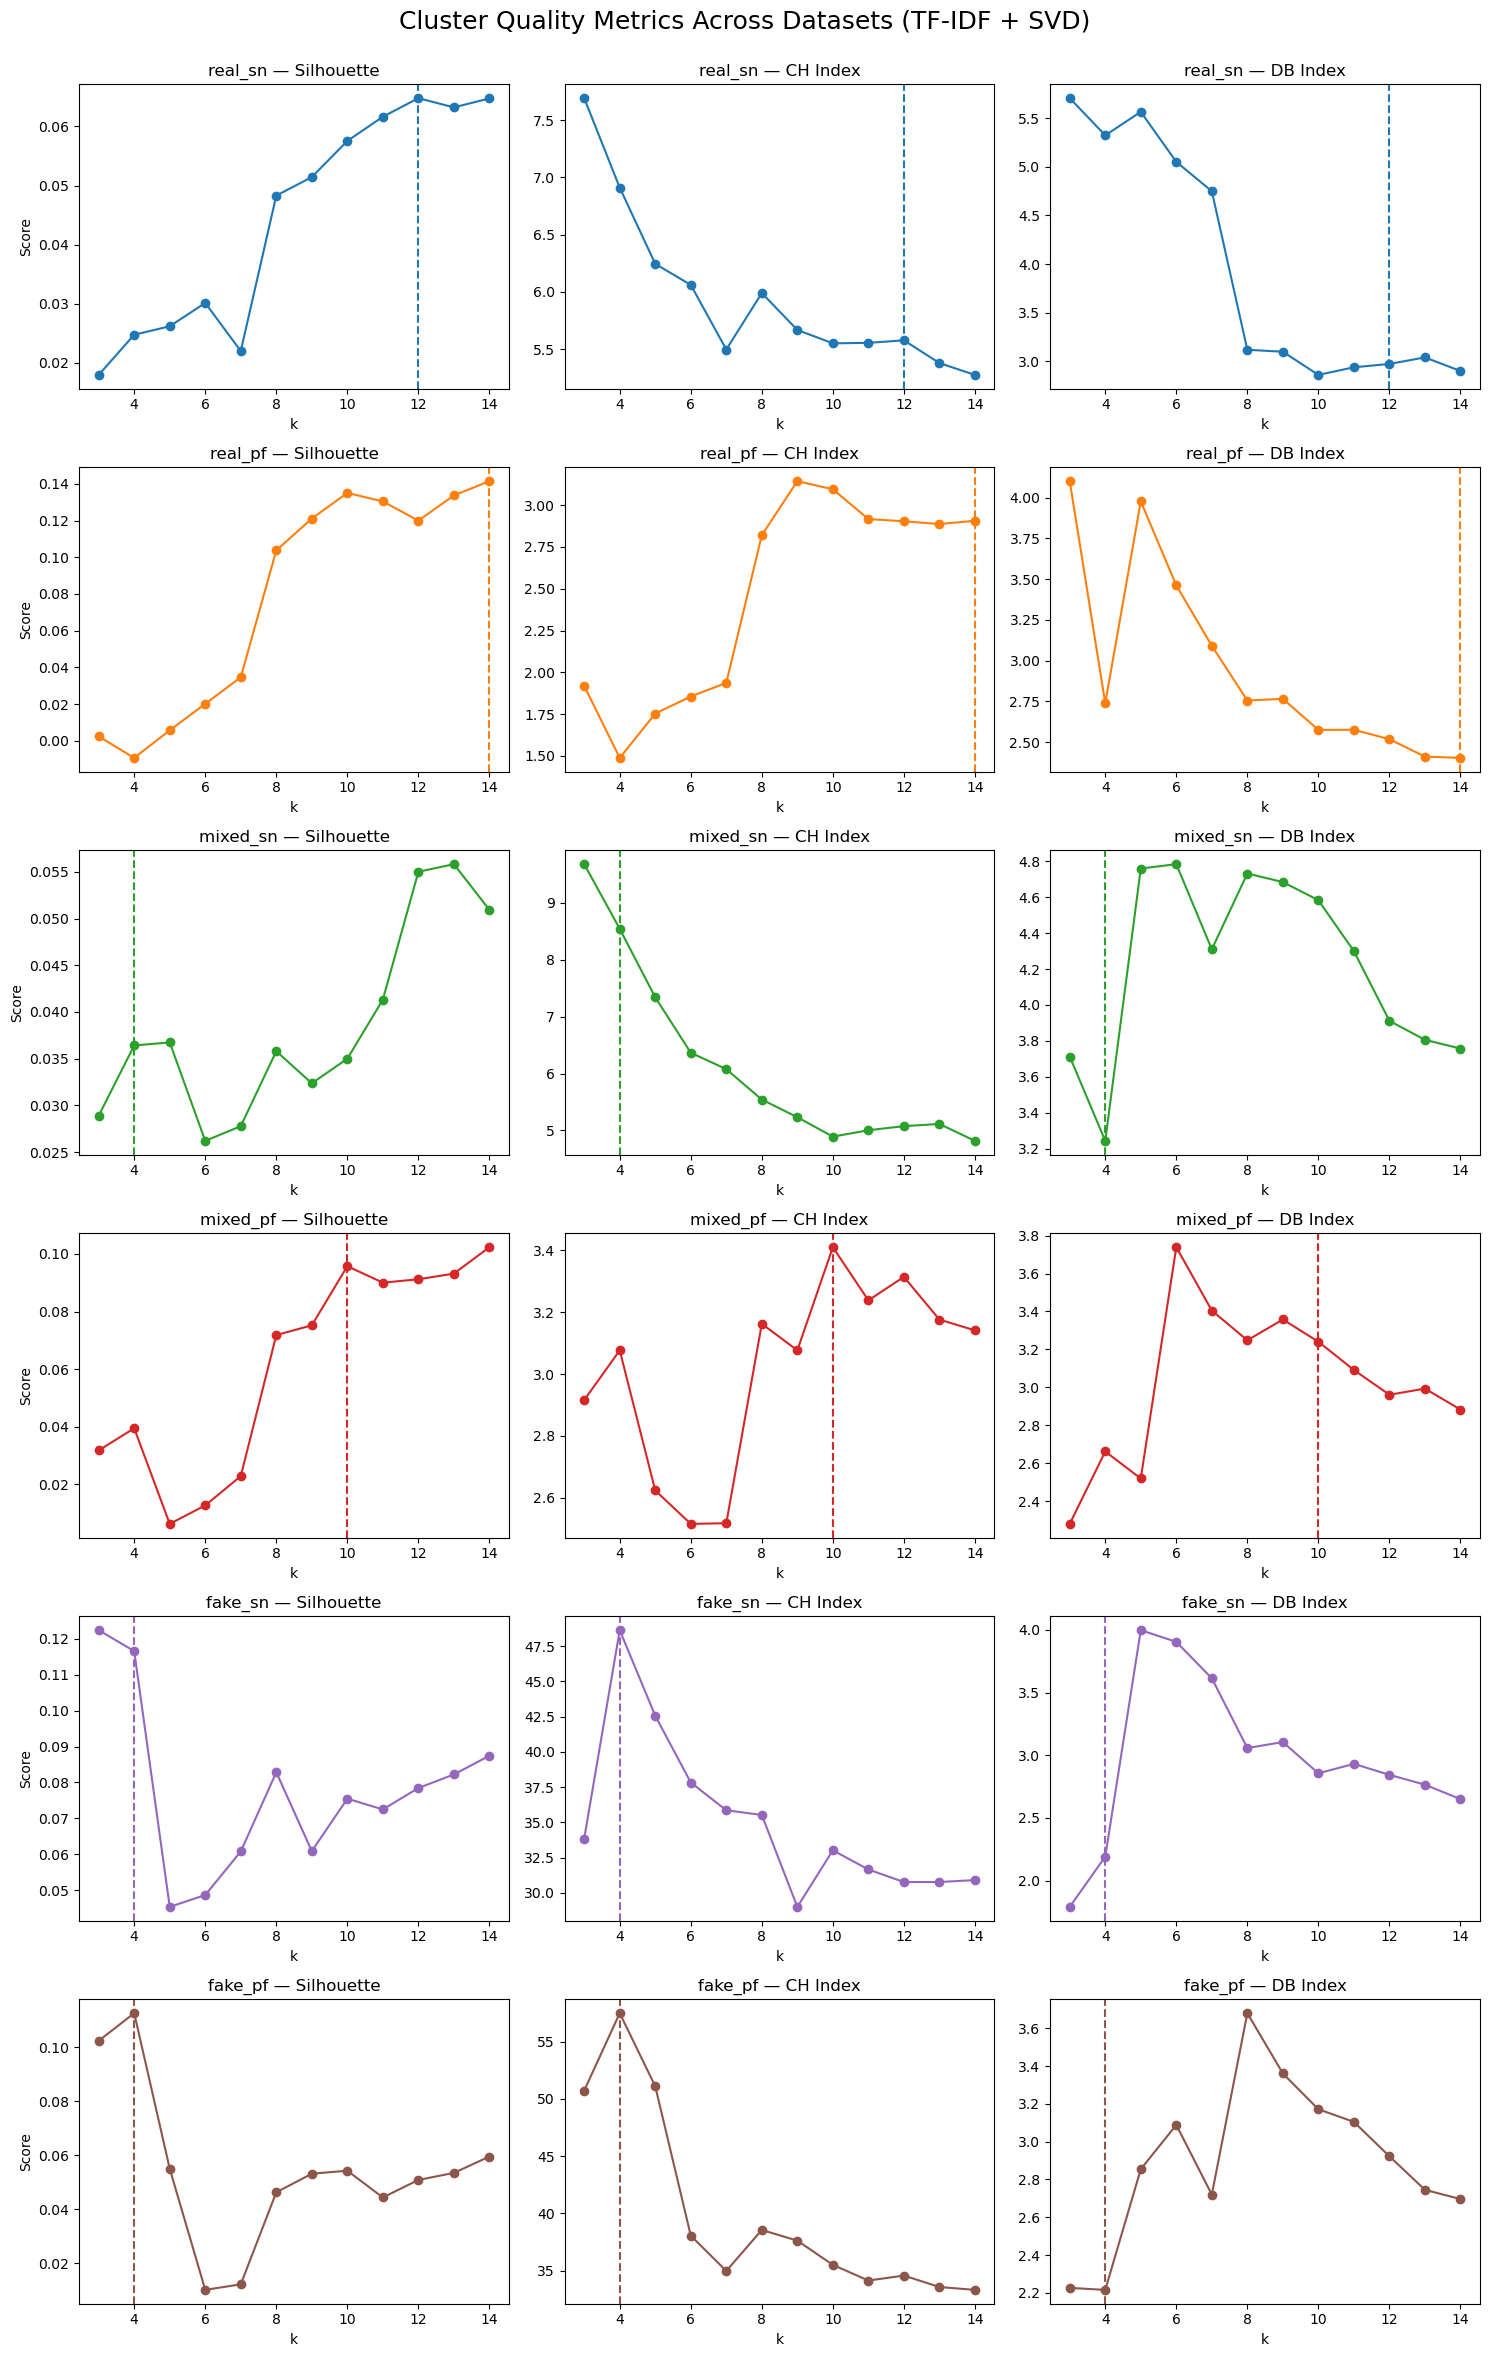

{'real_sn': 12,
 'real_pf': 14,
 'mixed_sn': 4,
 'mixed_pf': 10,
 'fake_sn': 4,
 'fake_pf': 4}

In [167]:
k_values = range(3, 15)

k_map, best_k_map = evaluate_clustering_metrics(svd_datasets=datasets, k_values=k_values)

apply_optimal_clustering(svd_datasets=datasets,
                         tfidf_data=tfidf_data,
                         cleaned_data=cleaned_data, 
                         optimal_k_values=best_k_map)

plot_clustering_metrics(svd_datasets=datasets,
                        metric_scores=k_map,
                        k_values=k_values,
                        optimal_k_values=best_k_map)

display(best_k_map)

#### 7.2.4.1.1. Sub-Clustering Results: Dominant Fake Claim Clusters

<u>Fake Claims - Snopes (k = 16)</u>  
**Sub-clusters of dominant cluster 1 (N = 1,314)**

| Cluster | Size | Topic label                               | Short description                                          |
| ------: | ---: | ----------------------------------------- | ---------------------------------------------------------- |
|       0 |   26 | School curriculum controversies           | David Hogg, gender education, teaching, gun safety         |
|       1 |  233 | Fake news websites & satire               | Satirical sites, fabricated Obama/Clinton/McCain articles  |
|       2 |   10 | Gas price misinformation                  | Gasoline costs, Biden price memes, fuel station photos     |
|       3 |  553 | General political rumors                  | Clinton, taxes, tweets, border claims, company ads         |
|       4 |   67 | Biden/Harris campaign fabrications        | Joe Biden videos, Hunter Biden laptop, inauguration photos |
|       5 |   14 | Antifa & extremism hoaxes                 | Anti-fascist flyers, Thunberg, white supremacists, protests|
|       6 |   17 | Soros & deep state conspiracies           | George Soros, Schiff, Parler, Russian indictments, Gaetz   |
|       7 |  119 | Viral celebrity photographs               | Manipulated images, Obama, protest photos, caption hoaxes  |
|       8 |   70 | Ukraine war misinformation                | Russia/Ukraine footage, Zelenskyy, missiles, fake videos   |
|       9 |    7 | Chick-fil-A promotional scams             | Free meal hoaxes, restaurant promotions, fake offers       |
|      10 |   13 | Epstein & Maxwell conspiracies            | Jeffrey Epstein photos, sex trafficking, Clinton, pardons  |
|      11 |   27 | Moon landing & marijuana hoaxes           | NASA conspiracies, Apollo, asteroids, legalization rumors  |
|      12 |   16 | AOC misinformation                        | Alexandria Ocasio-Cortez tweets, arrest rumors, memes      |
|      13 |   26 | Kaepernick & NFL protests                 | Colin Kaepernick, Nike, anthem kneeling, football boycotts |
|      14 |   82 | Police violence narratives                | George Floyd, shootings, Capitol, Black Lives Matter       |
|      15 |   34 | Kavanaugh & abortion conspiracies         | Brett Kavanaugh, Ford allegations, Roe v. Wade, Barrett    |

<u>Fake Claims - PolitiFact (k = 14)</u>  
**Sub-clusters of dominant cluster 0 (N = 1,610)**

| Cluster | Size | Topic label                               | Short description                                          |
| ------: | ---: | ----------------------------------------- | ---------------------------------------------------------- |
|       0 |   21 | Epstein & Maxwell photos                  | Jeffrey Epstein island, sex trafficking images, jail video |
|       1 |   95 | Immigration & border wall claims          | Migrant children, Mexico wall, abortion, Planned Parenthood|
|       2 | 1133 | General viral content                     | Biden photos, flags, tweets, O'Rourke, fire images, quotes |
|       3 |   35 | Nancy Pelosi conspiracies                 | Impeachment, Capitol, Paul Pelosi, Speaker hoaxes          |
|       4 |   16 | AOC arrest rumors                         | Alexandria Ocasio-Cortez Instagram, fake arrest stories    |
|       5 |   24 | Tax policy fabrications                   | Income tax returns, Disney, Ford, Biden proposals, payroll |
|       6 |    6 | Joel Osteen prayer hoaxes                 | Ministries, school prayer, church, Capitol, proclamations  |
|       7 |   30 | NFL protest controversies                 | Kaepernick kneeling, national anthem, football, Elway      |
|       8 |    4 | Einstein fake quotes                      | Physicist misattributions, technology, science quotes      |
|       9 |    7 | John McCain conspiracy theories           | Treason pardons, POW, Vietnam War, Navy, herd immunity     |
|      10 |  217 | Fake news websites & Clinton              | Hillary Clinton, Soros, moon landing, Obama, fake headlines|
|      11 |    6 | Taco Bell ownership hoaxes                | Franchisee rumors, restaurant threats, animal ownership    |
|      12 |    7 | Nike boycott misinformation               | $76 billion loss claims, Kaepernick, company revenue       |
|      13 |    9 | Chick-fil-A police support                | Police shirts, football team, local protests, employees    |

Processing fake_sn: 100%|██████████| 16/16 [00:02<00:00,  6.87it/s]


fake_sn: Best k = 16


Processing fake_pf: 100%|██████████| 16/16 [00:02<00:00,  5.47it/s]


fake_pf: Best k = 14

Clustering fake_sn
Matrix shape: (1314, 100)

Cluster sizes:
    cluster  size
0         0    26
1         1   233
2         2    10
3         3   553
4         4    67
5         5    14
6         6    17
7         7   119
8         8    70
9         9     7
10       10    13
11       11    27
12       12    16
13       13    26
14       14    82
15       15    34

Top 15 terms per cluster:

Cluster 0 (n=26): school, student, hogg, education, teach, shooting, book, gender, district, grade, teacher, child, curriculum, high, gun

Cluster 1 (n=233): site, web, quote, article, obama, fake, publish, story, 2017, 2016, satirical, satire, donald, clinton, mccain

Cluster 2 (n=10): gas, price, gasoline, gallon, oil, average, energy, unleaded, picture, fuel, high, biden, 2021, meme, station

Cluster 3 (n=553): child, clinton, house, tax, tweet, ad, company, page, united, border, rumor, 2018, states, twitter, message

Cluster 4 (n=67): biden, joe, video, harris, 2020, hunte

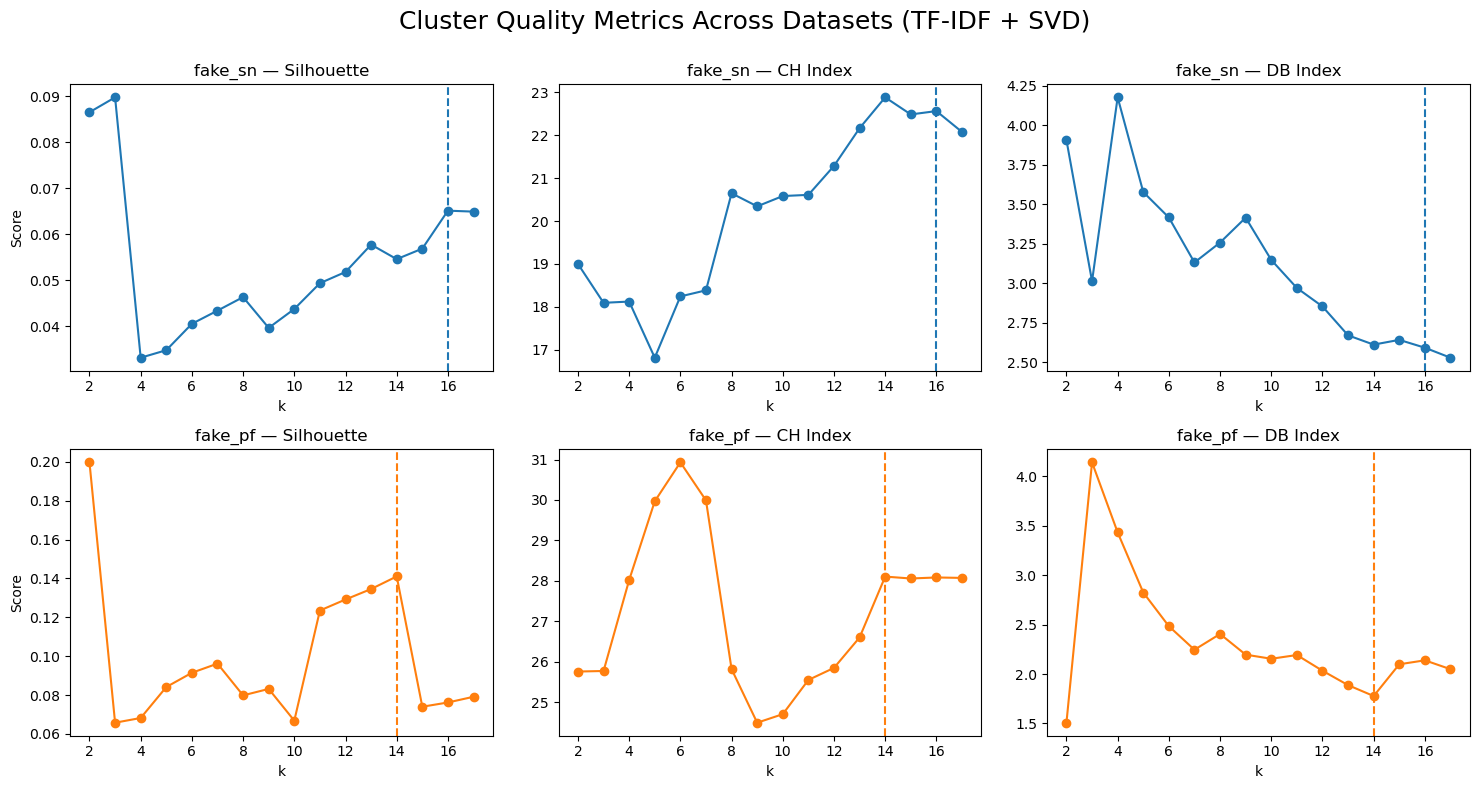

In [33]:
# Define which clusters to sub-cluster (the dominant ones)
subclustering_targets = {
    'fake_sn': 1,  # Cluster 1 has 1,314 documents
    'fake_pf': 0   # Cluster 0 has 1,510 documents
}

# Test range for sub-clustering
sub_k_values = range(2, 18)

# Extract data for dominant clusters only
dominant_mask_data = {}
sub_svd_data = {}
sub_tfidf_data = {}
for name, cluster_id in subclustering_targets.items():
    cluster_col = f'k_means_{name}'
    # Get boolean mask for dominant cluster
    dominant_mask = cleaned_data[name][cluster_col] == cluster_id
    dominant_mask_data[name] = dominant_mask
    # Subset SVD and TF-IDF data using mask
    sub_svd_data[name] = datasets[name][dominant_mask.values]
    sub_tfidf_data[name] = tfidf_data[name][dominant_mask.values]

# Evaluate clustering metrics for sub-clusters
sub_k_map, sub_best_k_map = evaluate_clustering_metrics(svd_datasets=sub_svd_data, 
                                                         k_values=sub_k_values)

# Apply optimal k-means to sub-clusters and assign labels
apply_optimal_clustering(svd_datasets=sub_svd_data,
                         data_slice=dominant_mask_data,
                         tfidf_data=sub_tfidf_data,
                         cleaned_data=cleaned_data, 
                         optimal_k_values=sub_best_k_map)

# Plot sub-clustering metrics
sub_df = {key: datasets[key] for key in ['fake_sn', 'fake_pf']}
plot_clustering_metrics(svd_datasets=sub_df,
                        metric_scores=sub_k_map,
                        k_values=sub_k_values,
                        optimal_k_values=sub_best_k_map)

## 7.3. Linear Discriminant Analysis (LDA)

In [51]:
def train_single_lda(num_topics, dictionary, corpus, texts, passes, chunksize, random_state):
    """Train a single LDA model and return results"""
    from gensim.models import LdaModel
    from gensim.models.coherencemodel import CoherenceModel
    
    start_time = time.time()
    
    model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=random_state,
        chunksize=chunksize,
        passes=passes,
        per_word_topics=True
    )
    
    lda_time = time.time() - start_time
    
    start_time = time.time()
    cm = CoherenceModel(
        model=model,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v',
        processes=1  # CRITICAL: Prevents nested multiprocessing
    )
    coherence = cm.get_coherence()
    coherence_time = time.time() - start_time
    
    perplexity = model.log_perplexity(corpus)
    
    return num_topics, model, coherence, perplexity, lda_time, coherence_time

def lda_model_parallel(dictionary, corpus, texts, start, limit, step, 
                       random_state=42, passes=10, chunksize=100, n_jobs=-1):
    """
    Train multiple LDA models in parallel with progress bar
    """
    topic_range = list(range(start, limit, step))
    
    print(f"Training {len(topic_range)} models for topics: {topic_range}")
    
    # Use loky backend for true parallelization
    results = Parallel(n_jobs=n_jobs, backend='loky', verbose=0)(
        delayed(train_single_lda)(
            num_topics, dictionary, corpus, texts, passes, chunksize, random_state
        )
        for num_topics in tqdm(topic_range, total=len(topic_range), desc="Training LDA models")
    )
    
    # Unpack and display results
    models = []
    coherences = []
    perplexities = []
    
    print("\n" + "="*60)
    print("Results:")
    print("="*60)
    for num_topics, model, coherence, perplexity, lda_time, coh_time in sorted(results):
        print(f"Topics={num_topics:2d}: Coherence={coherence:.3f}, Perplexitity={perplexity:.3f}, "
              f"LDATime={lda_time:5.1f}s, CoherenceTime={coh_time:5.1f}s")
        models.append(model)
        coherences.append(coherence)
        perplexities.append(perplexity)
    
    total_lda = sum(r[4] for r in results)
    total_coh = sum(r[5] for r in results)
    print("="*60)
    print(f"Total LDA time: {total_lda:.1f}s")
    print(f"Total Coherence time: {total_coh:.1f}s")
    print(f"Total time: {total_lda + total_coh:.1f}s")
    
    return models, coherences, perplexities

def pick_best_k_lda(ks, coh, perp):
    """
    Combine coherence (higher better) and perplexity (lower better)
    into a single rank-based score and pick the best k.
    """
    coh_rank  = np.argsort(np.argsort(coh))
    perp_rank = np.argsort(np.argsort([-p for p in perp]))
    total = coh_rank + perp_rank
    best_idx = np.argmax(total)
    return ks[best_idx], coh[best_idx], perp[best_idx]


Due to a long computing time of around 7 minutes for the LDA models and to maintain consistent results, I have decided to store the results and comment out the following code block. In the proceding code block I reload the saved data for further analysis.

In [ ]:
# id2word = {}        # gensim Dictionary object for each dataset
# corpora_bow = {}    # bag of words

# no_below = 10       # min docs
# no_above = 0.4      # max proportion of docs

# # Create dictionary and bag of words for LDA models
# for name, texts in cleaned_data.items():
#     # Create dictionary
#     org = name[-2:]
#     docs = texts[f"clean_{org}"].astype(str).str.split().tolist()

#     dictionary = corpora.Dictionary(docs)
#     dictionary.filter_extremes(no_below=no_below, no_above=no_above)
#     id2word[name] = dictionary

#     # Create corpus (BoW)
#     corp = [dictionary.doc2bow(doc) for doc in docs]
#     corpora_bow[name] = corp

# print('id2word and corpora_bow completed')

# # Prepare containers for LDA results
# lda_models = {}
# coh_scores = {}
# perp_scores = {}
# topic_grids = {} 

# for name, k in best_k_map.items():
#     # define smart topic range around best k
#     start = 2
#     limit = 16
#     step = 1

#     topic_range = list(range(start, limit, step))
#     print(f"\n=== {name} ===")

#     org = name[-2:]
#     texts = cleaned_data[name][f'clean_{org}'].astype(str).str.split().tolist()

#     if __name__ == '__main__':
#         models, coherences, perplexities = lda_model_parallel(
#             dictionary=id2word[name],
#             corpus=corpora_bow[name],
#             texts=texts,
#             start=start,
#             limit=limit,
#             step=step,
#             passes=5,
#             chunksize=200,
#             n_jobs=-1
#         )

#     lda_models[name] = models
#     coh_scores[name] = coherences
#     perp_scores[name] = perplexities
#     topic_grids[name] = list(range(start, limit))

#     coh = list(coherences)
#     perp = list(perplexities)

#     best_k, best_coh, best_perp = pick_best_k_lda(list(topic_range), coh, perp)

#     print(f"Best num_topics for {name}: {best_k} (coherence={best_coh:.3f}, perplexity={best_perp:.3f})")

# print("Saving data")

# # Save coherence scores
# with open("data/results/models/coherence_scores/coh_scores.json", "w") as f:
#     json.dump(coh_scores, f)
# # Save perplexity scores
# with open("data/results/models/perplexity_scores/perp_scores.json", "w") as f:
#     json.dump(perp_scores, f)
# # Save topic grids
# with open("data/results/models/topic_grids/topic_grids.json", "w") as f:
#     json.dump(topic_grids, f)
# # Save word dictionary
# for name, dictionary in id2word.items():
#     dictionary.save(f"data/results/models/id2word/{name}_dictionary.gensim")
# # Save bag of word corpus
# for name, corpus in corpora_bow.items():
#     MmCorpus.serialize(f"data/results/models/corpora_bow/{name}_bow.mm", corpus)
# # Save LDA models
# for (name, models), (name, topic_nums) in zip(lda_models.items(), topic_grids.items()):
#     for (_, model), (_, topic) in zip(enumerate(models), enumerate(topic_nums)):
#         model.save(f"data/results/models/lda_models/{name}_lda_{topic}.model")

# print("Data saved")


=== real_sn ===
Training 14 models for topics: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


Training LDA models: 100%|██████████| 14/14 [00:00<00:00, 1114.93it/s]



Results:
Topics= 2: Coherence=0.333, Perplexitity=-7.032,LDA Time=  6.2s, Coherence Time=  5.1s
Topics= 3: Coherence=0.337, Perplexitity=-7.010,LDA Time=  6.7s, Coherence Time=  5.9s
Topics= 4: Coherence=0.399, Perplexitity=-6.993,LDA Time=  6.1s, Coherence Time=  6.3s
Topics= 5: Coherence=0.400, Perplexitity=-6.986,LDA Time= 12.0s, Coherence Time=  5.4s
Topics= 6: Coherence=0.358, Perplexitity=-6.980,LDA Time=  6.7s, Coherence Time=  7.3s
Topics= 7: Coherence=0.415, Perplexitity=-6.973,LDA Time=  6.2s, Coherence Time=  8.0s
Topics= 8: Coherence=0.440, Perplexitity=-6.978,LDA Time=  6.9s, Coherence Time=  8.5s
Topics= 9: Coherence=0.457, Perplexitity=-6.978,LDA Time=  6.5s, Coherence Time=  8.8s
Topics=10: Coherence=0.482, Perplexitity=-6.979,LDA Time=  6.3s, Coherence Time=  9.7s
Topics=11: Coherence=0.465, Perplexitity=-6.982,LDA Time=  6.9s, Coherence Time=  9.8s
Topics=12: Coherence=0.448, Perplexitity=-7.005,LDA Time=  7.0s, Coherence Time= 10.1s
Topics=13: Coherence=0.420, Perpl

Training LDA models: 100%|██████████| 14/14 [00:00<00:00, 5576.47it/s]



Results:
Topics= 2: Coherence=0.315, Perplexitity=-6.453,LDA Time=  3.7s, Coherence Time=  1.2s
Topics= 3: Coherence=0.291, Perplexitity=-6.417,LDA Time=  3.5s, Coherence Time=  1.3s
Topics= 4: Coherence=0.367, Perplexitity=-6.376,LDA Time=  3.9s, Coherence Time=  4.4s
Topics= 5: Coherence=0.378, Perplexitity=-6.374,LDA Time=  4.1s, Coherence Time=  3.9s
Topics= 6: Coherence=0.378, Perplexitity=-6.356,LDA Time=  4.1s, Coherence Time=  5.2s
Topics= 7: Coherence=0.358, Perplexitity=-6.370,LDA Time=  4.5s, Coherence Time=  5.6s
Topics= 8: Coherence=0.367, Perplexitity=-6.391,LDA Time=  4.2s, Coherence Time=  5.7s
Topics= 9: Coherence=0.363, Perplexitity=-6.391,LDA Time=  4.0s, Coherence Time=  5.7s
Topics=10: Coherence=0.333, Perplexitity=-6.383,LDA Time=  4.5s, Coherence Time=  6.3s
Topics=11: Coherence=0.364, Perplexitity=-6.400,LDA Time=  4.2s, Coherence Time=  6.5s
Topics=12: Coherence=0.355, Perplexitity=-6.418,LDA Time=  4.7s, Coherence Time=  6.5s
Topics=13: Coherence=0.321, Perpl

Training LDA models: 100%|██████████| 14/14 [00:00<00:00, 3256.09it/s]



Results:
Topics= 2: Coherence=0.358, Perplexitity=-7.160,LDA Time=  5.6s, Coherence Time=  8.1s
Topics= 3: Coherence=0.285, Perplexitity=-7.132,LDA Time=  5.9s, Coherence Time=  9.4s
Topics= 4: Coherence=0.405, Perplexitity=-7.097,LDA Time=  6.4s, Coherence Time=  8.4s
Topics= 5: Coherence=0.419, Perplexitity=-7.100,LDA Time=  6.4s, Coherence Time=  9.7s
Topics= 6: Coherence=0.483, Perplexitity=-7.071,LDA Time=  6.3s, Coherence Time= 10.9s
Topics= 7: Coherence=0.453, Perplexitity=-7.083,LDA Time=  7.2s, Coherence Time= 11.7s
Topics= 8: Coherence=0.450, Perplexitity=-7.077,LDA Time=  6.6s, Coherence Time= 11.8s
Topics= 9: Coherence=0.475, Perplexitity=-7.083,LDA Time=  7.2s, Coherence Time= 13.7s
Topics=10: Coherence=0.456, Perplexitity=-7.087,LDA Time=  7.4s, Coherence Time= 14.4s
Topics=11: Coherence=0.434, Perplexitity=-7.107,LDA Time=  7.9s, Coherence Time= 13.5s
Topics=12: Coherence=0.436, Perplexitity=-7.091,LDA Time=  7.3s, Coherence Time= 14.6s
Topics=13: Coherence=0.446, Perpl

Training LDA models: 100%|██████████| 14/14 [00:00<00:00, 13984.34it/s]



Results:
Topics= 2: Coherence=0.208, Perplexitity=-6.625,LDA Time=  5.3s, Coherence Time=  4.3s
Topics= 3: Coherence=0.225, Perplexitity=-6.608,LDA Time=  5.4s, Coherence Time=  8.0s
Topics= 4: Coherence=0.254, Perplexitity=-6.584,LDA Time=  5.4s, Coherence Time=  5.5s
Topics= 5: Coherence=0.262, Perplexitity=-6.571,LDA Time=  5.5s, Coherence Time=  7.9s
Topics= 6: Coherence=0.267, Perplexitity=-6.570,LDA Time=  5.6s, Coherence Time= 10.0s
Topics= 7: Coherence=0.282, Perplexitity=-6.554,LDA Time=  5.0s, Coherence Time=  8.8s
Topics= 8: Coherence=0.291, Perplexitity=-6.560,LDA Time=  5.2s, Coherence Time=  9.4s
Topics= 9: Coherence=0.316, Perplexitity=-6.546,LDA Time=  6.5s, Coherence Time=  9.3s
Topics=10: Coherence=0.292, Perplexitity=-6.559,LDA Time=  6.1s, Coherence Time= 10.0s
Topics=11: Coherence=0.300, Perplexitity=-6.568,LDA Time=  6.4s, Coherence Time=  9.9s
Topics=12: Coherence=0.316, Perplexitity=-6.586,LDA Time=  6.5s, Coherence Time= 10.4s
Topics=13: Coherence=0.318, Perpl

Training LDA models: 100%|██████████| 14/14 [00:00<00:00, 5892.65it/s]



Results:
Topics= 2: Coherence=0.399, Perplexitity=-7.662,LDA Time= 15.4s, Coherence Time= 20.9s
Topics= 3: Coherence=0.475, Perplexitity=-7.615,LDA Time= 17.1s, Coherence Time= 23.5s
Topics= 4: Coherence=0.459, Perplexitity=-7.598,LDA Time= 19.3s, Coherence Time= 26.6s
Topics= 5: Coherence=0.493, Perplexitity=-7.565,LDA Time= 20.1s, Coherence Time= 27.1s
Topics= 6: Coherence=0.506, Perplexitity=-7.552,LDA Time= 19.6s, Coherence Time= 27.6s
Topics= 7: Coherence=0.467, Perplexitity=-7.563,LDA Time= 22.2s, Coherence Time= 28.2s
Topics= 8: Coherence=0.508, Perplexitity=-7.547,LDA Time= 22.1s, Coherence Time= 30.5s
Topics= 9: Coherence=0.509, Perplexitity=-7.539,LDA Time= 23.1s, Coherence Time= 31.4s
Topics=10: Coherence=0.499, Perplexitity=-7.538,LDA Time= 22.9s, Coherence Time= 33.3s
Topics=11: Coherence=0.497, Perplexitity=-7.545,LDA Time= 23.6s, Coherence Time= 34.5s
Topics=12: Coherence=0.480, Perplexitity=-7.645,LDA Time= 24.0s, Coherence Time= 34.0s
Topics=13: Coherence=0.493, Perpl

Training LDA models: 100%|██████████| 14/14 [00:00<00:00, 7014.72it/s]



Results:
Topics= 2: Coherence=0.481, Perplexitity=-7.620,LDA Time= 17.4s, Coherence Time= 24.9s
Topics= 3: Coherence=0.506, Perplexitity=-7.539,LDA Time= 18.3s, Coherence Time= 28.4s
Topics= 4: Coherence=0.513, Perplexitity=-7.513,LDA Time= 19.7s, Coherence Time= 30.9s
Topics= 5: Coherence=0.525, Perplexitity=-7.490,LDA Time= 20.6s, Coherence Time= 33.3s
Topics= 6: Coherence=0.470, Perplexitity=-7.492,LDA Time= 21.7s, Coherence Time= 35.8s
Topics= 7: Coherence=0.473, Perplexitity=-7.478,LDA Time= 21.9s, Coherence Time= 37.8s
Topics= 8: Coherence=0.484, Perplexitity=-7.460,LDA Time= 23.7s, Coherence Time= 38.7s
Topics= 9: Coherence=0.459, Perplexitity=-7.460,LDA Time= 22.9s, Coherence Time= 40.1s
Topics=10: Coherence=0.439, Perplexitity=-7.447,LDA Time= 22.0s, Coherence Time= 41.0s
Topics=11: Coherence=0.469, Perplexitity=-7.462,LDA Time= 25.0s, Coherence Time= 42.2s
Topics=12: Coherence=0.458, Perplexitity=-7.576,LDA Time= 24.5s, Coherence Time= 43.8s
Topics=13: Coherence=0.445, Perpl

### 7.3.1. Reload Data

In [31]:
# Reload topic grids
with open('data/results/models/topic_grids/topic_grids.json', 'r') as f:
    topic_grids = json.load(f)

# Reload coherence scores
with open('data/results/models/coherence_scores/coh_scores.json', 'r') as f:
    coh_scores = json.load(f)

# Reload coherence scores
with open('data/results/models/perplexity_scores/perp_scores.json', 'r') as f:
    perp_scores = json.load(f)

# Reload copora_bow
corpora_bow = {}
for name, data in datasets.items():
    corpora_bow[name] = MmCorpus(f"data/results/models/corpora_bow/{name}_bow.mm")

# Reload id2word
id2word = {}
for name, _ in datasets.items():
    id2word[name] = Dictionary.load(f"data/results/models/id2word/{name}_dictionary.gensim")

# Reload only the best models
models = {}
for name in cleaned_data.keys():
    for k in range(2, 16):
        models[f'{name}_{k}'] = LdaModel.load(f"data/results/models/lda_models/{name}_lda_{k}.model")

display(corpora_bow.keys())

dict_keys(['real_sn', 'real_pf', 'mixed_sn', 'mixed_pf', 'fake_sn', 'fake_pf'])

### 7.3.2. Best LDA Cluster Size (K) 

For LDA, we use Coherence and Perplexity scores to make an informed decision about the best cluster size (K):
- Coherence - A measure of how semantically related the top words within a single topic are (Higher = Better).
- Perplexity- A measure of how well the model can predict unseen data. It is derived from the log-likelihood of a held-out test set (Lower = Better).

The LDA perfomance metrics show similar results for 'Real' and 'Mixed' claims compared to the K-Means clustering method. The trend in coherence and perplexity is monotonic, with coherence increasing steadily and perplexity decreasing steadily. This means that the topic model is easily overfitting to individual documents so adding more topics will always improve the fit. The model is not discovering meaningful, generalizable topics, and therefore, we cannot use the LDA to justify the high topic counts. Instead, we will manually assign k=5 to see if we can still gather some meaningful insights. 

On the other hand, the cluster size (k) for 'Fake' claims seems to differ between the LDA and K-Means, strongly favouring 3 clusters instead of 6. After k=11, overfitting becomes very apparent in both Coherence and Perplexity which is why we won't choose a value beyond k=11. However k=3 is still too oversimplified and makes the topics harder to identify. Therefore, k=9 is chosen as next best cluster size as it has the second highest coherence score and propensity doesn't increase significantly. This was further confirmed after inspecting the top 20 words per cluster where k=3 and k=9, 9 clusters has proven to be more distinctive and interpretable.


Best num_topics for real_sn: 12 (coherence=0.448, perplexity=-7.005)
Best num_topics for real_pf: 8 (coherence=0.367, perplexity=-6.391)
Best num_topics for mixed_sn: 13 (coherence=0.446, perplexity=-7.101)
Best num_topics for mixed_pf: 15 (coherence=0.337, perplexity=-6.596)
Best num_topics for fake_sn: 14 (coherence=0.520, perplexity=-7.948)
Best num_topics for fake_pf: 14 (coherence=0.483, perplexity=-7.951)


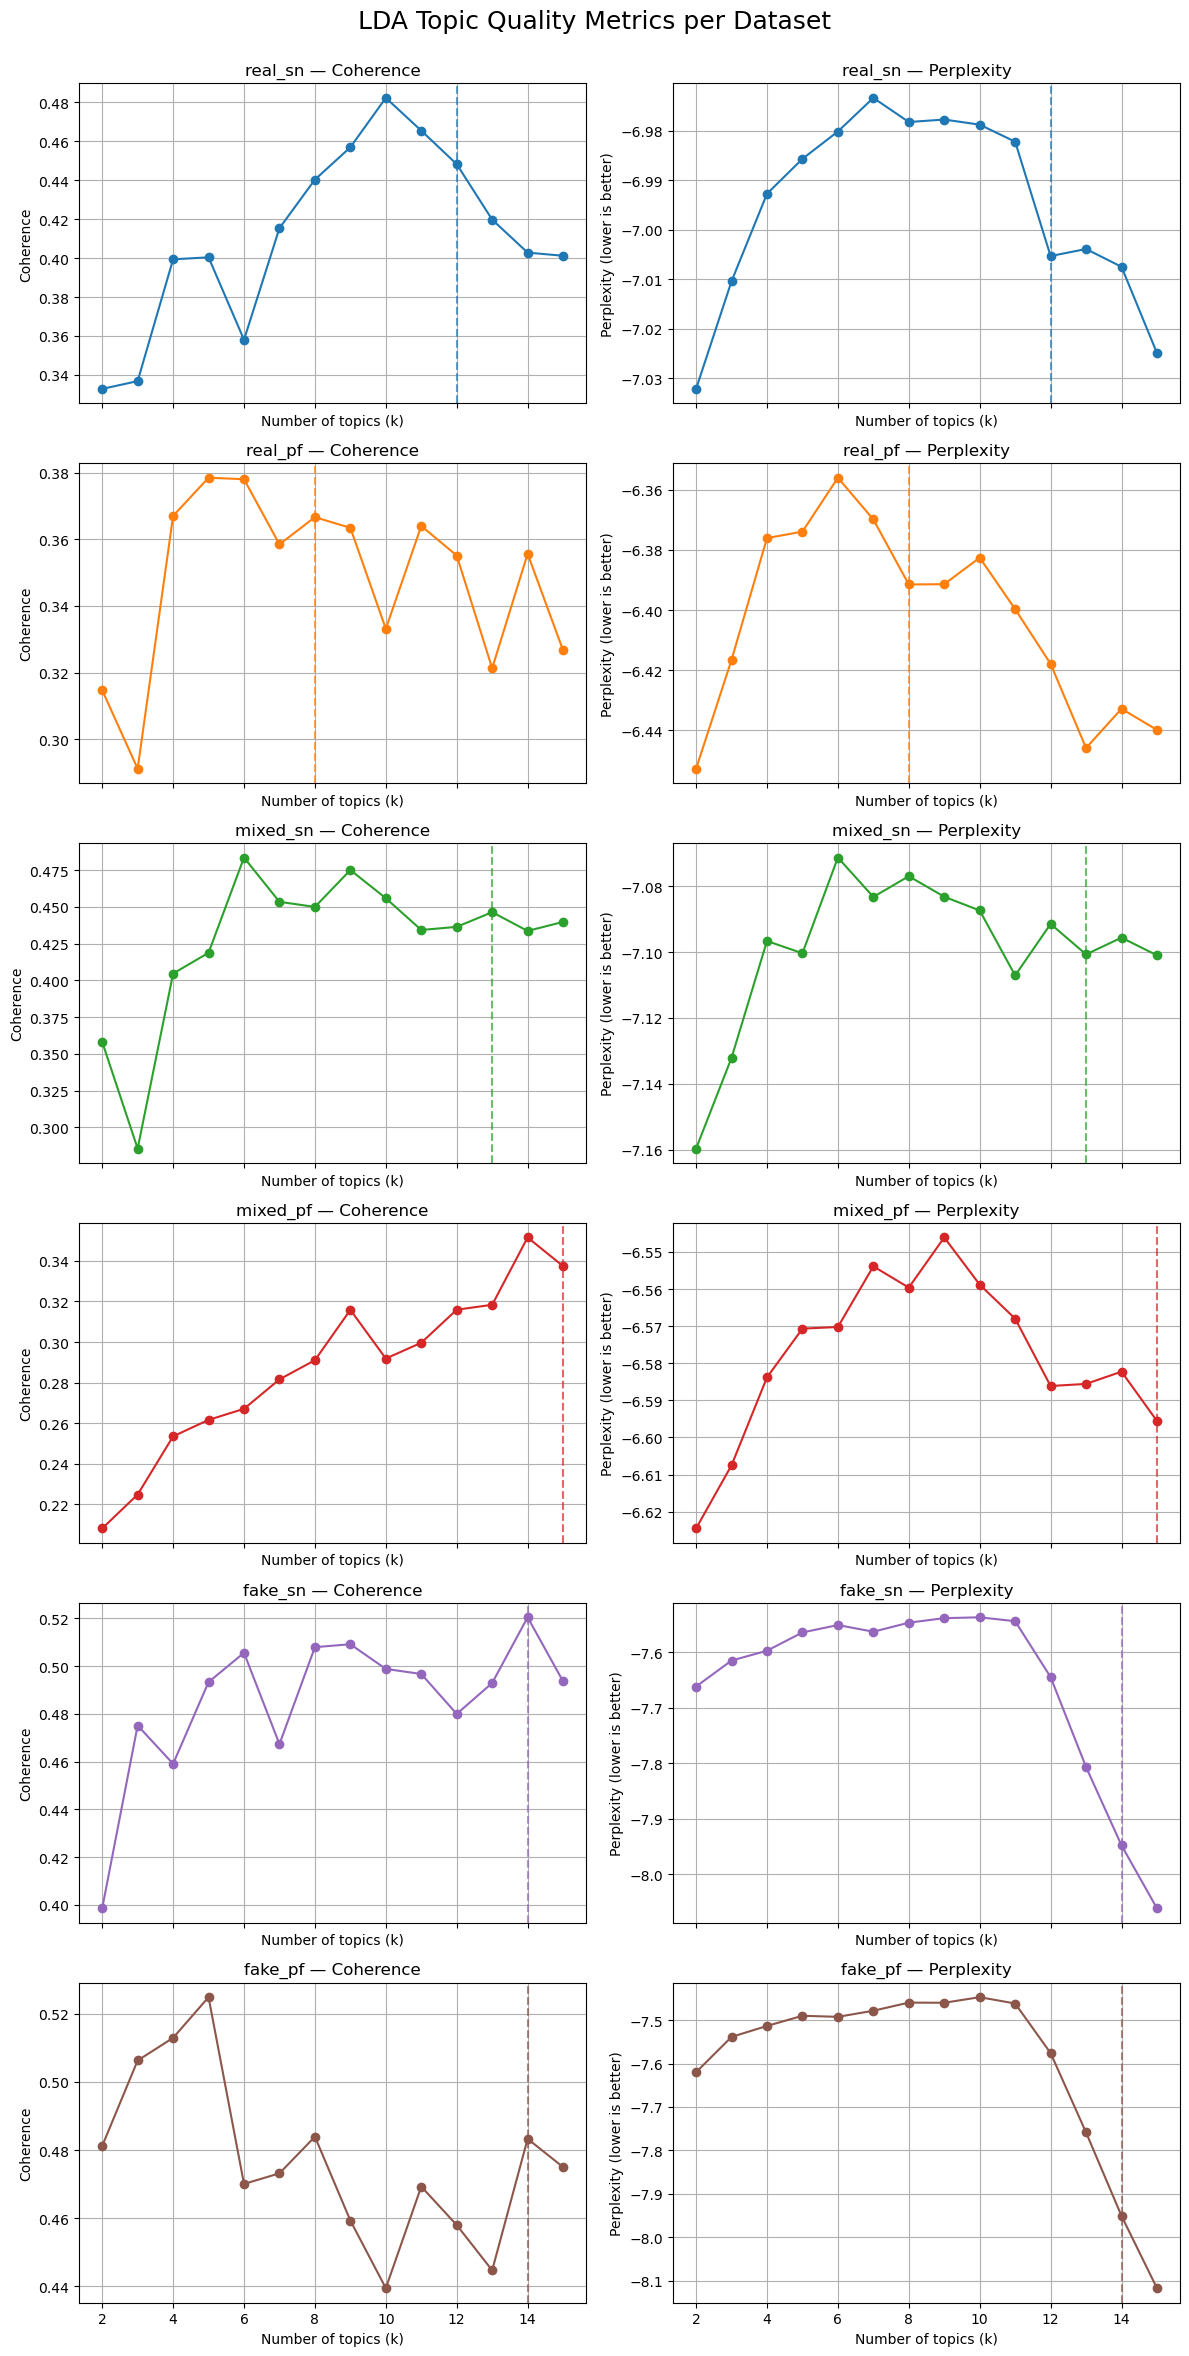

In [52]:
topic_range = range(2, 16)

n_datasets = len(list(coh_scores.keys()))

fig, axes = plt.subplots(
    nrows=n_datasets, ncols=2,
    figsize=(12, 4 * n_datasets),
    sharex=True
)
fig.suptitle("LDA Topic Quality Metrics per Dataset", fontsize=18)

cmap = plt.colormaps.get_cmap("tab10")
best_k_map_lda = {}

# Handle the case n_datasets == 1 so axes is 2D
axes = np.atleast_2d(axes)

for row_idx, name in enumerate(coh_scores.keys()):
    coh = list(coh_scores[name])
    perp = list(perp_scores[name])

    best_k, best_coh, best_perp = pick_best_k_lda(list(topic_range), coh, perp)
    best_k_map_lda[name] = best_k
    print(f"Best num_topics for {name}: {best_k} (coherence={best_coh:.3f}, perplexity={best_perp:.3f})")

    color = cmap(row_idx % 10)

    # Coherence plot 
    ax = axes[row_idx, 0]
    ax.plot(topic_range, coh, marker='o', color=color, label='Coherence (Cv)')
    ax.set_title(f"{name} — Coherence")
    ax.set_xlabel("Number of topics (k)")
    ax.set_ylabel("Coherence")
    ax.axvline(best_k, color=color, linestyle='--', alpha=0.7)
    ax.grid(True)

    # Perplexity plot
    ax = axes[row_idx, 1]
    ax.plot(topic_range, perp, marker='o', color=color, label='Perplexity')
    ax.set_title(f"{name} — Perplexity")
    ax.set_xlabel("Number of topics (k)")
    ax.set_ylabel("Perplexity (lower is better)")
    ax.axvline(best_k, color=color, linestyle='--', alpha=0.7)
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### 7.3.3. Complete LDA Analysis

#### 7.3.3.1. Helper Functions

In [93]:
def analyze_topics(model, dictionary, topn=15):
    """Get interpretable topic summaries"""
    topics_summary = []
    
    for topic_id in range(model.num_topics):
        # Get top words with probabilities
        top_words = model.show_topic(topic_id, topn=topn)
        words = [word for word, prob in top_words]
        probs = [prob for word, prob in top_words]
        
        topics_summary.append({
            'topic_id': topic_id,
            'top_words': ', '.join(words[:10]),
            'coherence': probs[0]  # Highest word probability
        })
    
    return pd.DataFrame(topics_summary)

def get_dominant_topics(model, corpus):
    """For each document, find the topic with highest probability"""
    dominant_topics = []
    
    for doc_bow in corpus:
        topic_dist = model.get_document_topics(doc_bow, minimum_probability=0.0)
        # Sort by probability and get top topic
        dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
        max_prob = max(topic_dist, key=lambda x: x[1])[1]
        
        # dominant_topics.append(dominant_topic)
        dominant_topics.append({
            'dominant_topic': dominant_topic,
            'probability': max_prob
        })
    
    dominant_topics = pd.DataFrame(dominant_topics)
    
    return dominant_topics

def calculate_topic_similarity(model1, model2, n_words=100):
    """Calculate similarity between topics from two models using word overlap"""
    from itertools import product
    
    similarities = []
    
    for t1 in range(model1.num_topics):
        for t2 in range(model2.num_topics):
            # Get top words
            words1 = set([w for w, p in model1.show_topic(t1, topn=n_words)])
            words2 = set([w for w, p in model2.show_topic(t2, topn=n_words)])
            
            # Jaccard similarity
            intersection = len(words1 & words2)
            union = len(words1 | words2)
            similarity = intersection / union if union > 0 else 0
            
            similarities.append({
                'sn_topic': t1,
                'pf_topic': t2,
                'similarity': similarity
            })
    
    return pd.DataFrame(similarities)

def calculate_topic_entropy(model, corpus):
    """Higher entropy = more distributed across topics (fake claims?)
       Lower entropy = concentrated in few topics (real claims?)"""
    from scipy.stats import entropy
    
    entropies = []
    
    for doc_bow in corpus:
        topic_dist = dict(model.get_document_topics(doc_bow, minimum_probability=0.0))
        probs = [topic_dist.get(i, 0.0) for i in range(model.num_topics)]
        
        # Calculate entropy
        ent = entropy(probs) if sum(probs) > 0 else 0
        entropies.append(ent)
    
    return np.array(entropies)

def analyze_topic_concentration(model, corpus):
    """How concentrated are documents in their dominant topic?"""
    concentrations = []
    
    for doc_bow in corpus:
        topic_dist = dict(model.get_document_topics(doc_bow, minimum_probability=0))
        probs = [topic_dist.get(i, 0.0) for i in range(model.num_topics)]
        
        # Get max probability (how strongly is it associated with dominant topic?)
        max_prob = max(probs) if probs else 0
        concentrations.append(max_prob)
    
    return np.array(concentrations)

#### 7.3.3.2. LDA Pipeline

In [73]:
def complete_lda_analysis(models_dict, corpora_dict, data_dict, dataset_name):
    """Run all analyses for a dataset"""
    
    print(f"\n{'='*60}")
    print(f"ANALYSIS FOR: {dataset_name}")
    print(f"{'='*60}\n")
    
    model = models_dict[dataset_name]
    corpus = corpora_dict[dataset_name.rsplit('_', 1)[0]]
    
    # 1. Topic summaries
    print("1. TOP WORDS PER TOPIC:")
    topics_df = analyze_topics(model, id2word[dataset_name.rsplit('_', 1)[0]])
    display(topics_df)
    
    # 2. Document statistics
    print("\n2. DOCUMENT-LEVEL STATISTICS:")
    dominant_df = get_dominant_topics(model, corpus)
    print(f"   Average max probability: {dominant_df['probability'].mean():.3f}")
    print(f"   Topic distribution:")
    print(dominant_df['dominant_topic'].value_counts().sort_index())
    
    # 3. Entropy analysis
    print("\n3. TOPIC ENTROPY:")
    entropies = calculate_topic_entropy(model, corpus)
    print(f"   Mean: {entropies.mean():.3f} (±{entropies.std():.3f})")
    
    # 4. Concentration
    print("\n4. TOPIC CONCENTRATION:")
    conc = analyze_topic_concentration(model, corpus)
    print(f"   Mean: {conc.mean():.3f} (±{conc.std():.3f})")
    
    print(f"\n{'='*60}\n")

# Run for all datasets
for name, k in best_k_map_lda.items():
    complete_lda_analysis(models, corpora_bow, cleaned_data, f"{name}_{k}")


ANALYSIS FOR: real_sn_12

1. TOP WORDS PER TOPIC:


topic_id                                          top_words  coherence
0          0  law, right, border, gun, wall, legal, court, u...   0.018100
1          1  flag, facebook, black, tweet, video, georgia, ...   0.020870
2          2  bill, house, federal, congress, act, member, g...   0.019989
3          3  woman, photograph, letter, york, right, 2016, ...   0.009864
4          4  dr., united, johnson, twitter, states, case, v...   0.009786
5          5  covid-19, death, cdc, pandemic, disease, healt...   0.038416
6          6  $, child, tax, million, administration, policy...   0.033753
7          7  vote, campaign, election, republican, biden, c...   0.022120
8          8  ballot, election, vote, mail, voter, voting, c...   0.049825
9          9  bear, national, number, population, datum, est...   0.011467
10        10  video, police, image, photograph, officer, man...   0.014957
11        11  shooting, school, kill, obama, 2018, gun, trad...   0.035144


2. DOCUMENT-LEVEL STATISTICS:
   Average max probability: 0.601
   Topic distribution:
dominant_topic
0     24
1     27
2     22
3     50
4     16
5     38
6     32
7     37
8     10
9     18
10    50
11    10
Name: count, dtype: int64

3. TOPIC ENTROPY:
   Mean: 0.967 (±0.389)

4. TOPIC CONCENTRATION:
   Mean: 0.601 (±0.180)



ANALYSIS FOR: real_pf_8

1. TOP WORDS PER TOPIC:


topic_id                                          top_words  coherence
0         0  vote, clinton, senate, congress, article, bill...   0.043326
1         1  flag, obama, white, black, administration, pol...   0.034751
2         2  kill, police, death, arrest, shooting, 2018, f...   0.028841
3         3  school, percent, $, hospital, district, progra...   0.022721
4         4  gun, bill, background, health, democrats, vote...   0.024790
5         5  veteran, court, tax, million, supreme, clinton...   0.016490
6         6  social, school, $, city, pay, child, health, s...   0.016454
7         7  vote, tax, county, election, close, popular, c...   0.043049


2. DOCUMENT-LEVEL STATISTICS:
   Average max probability: 0.816
   Topic distribution:
dominant_topic
0    25
1    18
2    13
3    14
4    17
5    34
6     6
7    15
Name: count, dtype: int64

3. TOPIC ENTROPY:
   Mean: 0.441 (±0.434)

4. TOPIC CONCENTRATION:
   Mean: 0.816 (±0.206)



ANALYSIS FOR: mixed_sn_13

1. TOP WORDS PER TOPIC:


topic_id                                          top_words  coherence
0          0  clinton, foundation, charity, organization, po...   0.018387
1          1  black, police, officer, player, man, national,...   0.009965
2          2  school, student, gun, kill, shooting, high, 20...   0.046192
3          3  voter, vote, election, ballot, campaign, candi...   0.038917
4          4  border, obama, country, administration, states...   0.014029
5          5  biden, war, wear, tweet, woman, story, speech,...   0.013580
6          6  water, brown, fire, california, video, order, ...   0.016105
7          7  $, pay, company, security, million, cost, work...   0.033356
8          8  shooting, mass, police, death, kill, country, ...   0.048521
9          9  covid-19, bill, vaccine, health, cdc, program,...   0.021439
10        10  health, medical, child, drug, million, care, p...   0.019306
11        11  card, credit, photograph, device, facebook, us...   0.048988
12        12  court, supreme, decision, federal, rate, legal...   0.087522


2. DOCUMENT-LEVEL STATISTICS:
   Average max probability: 0.633
   Topic distribution:
dominant_topic
0     25
1     53
2      8
3     26
4     27
5     35
6     22
7     33
8      9
9     44
10    25
11     4
12     6
Name: count, dtype: int64

3. TOPIC ENTROPY:
   Mean: 0.918 (±0.406)

4. TOPIC CONCENTRATION:
   Mean: 0.633 (±0.193)



ANALYSIS FOR: mixed_pf_15

1. TOP WORDS PER TOPIC:


topic_id                                          top_words  coherence
0          0  police, student, black, white, child, video, i...   0.020914
1          1  border, mexico, group, story, 2018, change, il...   0.034537
2          2  write, white, democrats, black, man, quote, co...   0.012280
3          3  school, price, shooting, gas, high, student, g...   0.070611
4          4  police, death, covid-19, number, case, kill, l...   0.027700
5          5  job, election, mail, ballot, administration, o...   0.021298
6          6  water, court, city, lead, level, job, case, sy...   0.059934
7          7  debt, country, united, states, attack, terrori...   0.022560
8          8  vote, ballot, election, voting, voter, mail, 2...   0.038383
9          9  abortion, vote, woman, datum, decline, increas...   0.052255
10        10  service, health, covid-19, contact, system, pa...   0.024210
11        11  million, vaccine, business, financial, company...   0.013939
12        12  social, senate, security, account, cut, bill, ...   0.020555
13        13  wage, worker, hour, pay, raise, work, job, 15,...   0.060675
14        14  campaign, obama, user, datum, million, access,...   0.015997


2. DOCUMENT-LEVEL STATISTICS:
   Average max probability: 0.803
   Topic distribution:
dominant_topic
0     19
1      9
2     17
3      8
4      7
5     12
6     11
7      9
8      9
9      9
10     9
11    16
12     9
13     5
14    14
Name: count, dtype: int64

3. TOPIC ENTROPY:
   Mean: 0.495 (±0.506)

4. TOPIC CONCENTRATION:
   Mean: 0.803 (±0.225)



ANALYSIS FOR: fake_sn_14

1. TOP WORDS PER TOPIC:


topic_id                                          top_words  coherence
0          0  covid-19, disease, virus, mask, cdc, flu, coro...   0.030903
1          1  clinton, hillary, white, 2016, russian, inform...   0.042308
2          2  study, water, level, high, cause, publish, dat...   0.012251
3          3  $, tax, million, rate, percent, cost, earth, t...   0.026772
4          4  vote, election, voter, ballot, voting, county,...   0.052651
5          5  vaccine, health, covid-19, cancer, drug, medic...   0.037678
6          6  $, company, million, business, foundation, mon...   0.041679
7          7  police, arrest, crime, department, charge, fbi...   0.028558
8          8  law, states, united, federal, bill, gun, gover...   0.026737
9          9  photograph, video, image, flag, event, picture...   0.017666
10        10  quote, abortion, right, know, statement, count...   0.009479
11        11  obama, house, donald, office, biden, democrati...   0.022277
12        12  site, fake, article, facebook, web, soros, pub...   0.021667
13        13  child, article, school, old, family, woman, st...   0.022198


2. DOCUMENT-LEVEL STATISTICS:
   Average max probability: 0.436
   Topic distribution:
dominant_topic
0      95
1      95
2      77
3      39
4      95
5      84
6      44
7      82
8      79
9     254
10    158
11    163
12    208
13    120
Name: count, dtype: int64

3. TOPIC ENTROPY:
   Mean: 1.492 (±0.334)

4. TOPIC CONCENTRATION:
   Mean: 0.436 (±0.149)



ANALYSIS FOR: fake_pf_14

1. TOP WORDS PER TOPIC:


topic_id                                          top_words  coherence
0          0  police, gun, fbi, shooting, kill, mass, office...   0.023789
1          1  white, percent, department, quote, attack, moo...   0.011298
2          2  $, pay, tax, million, money, company, billion,...   0.037923
3          3  sanders, black, campaign, write, war, woman, i...   0.018989
4          4  court, justice, case, supreme, senate, mccain,...   0.041782
5          5  child, school, story, student, arrest, family,...   0.031078
6          6  number, wall, mexico, border, high, datum, cou...   0.033045
7          7  vaccine, covid-19, death, virus, coronavirus, ...   0.036845
8          8  clinton, obama, story, quote, fake, website, h...   0.042243
9          9  story, photo, biden, tweet, house, image, appe...   0.011601
10        10  vote, election, voter, republican, ballot, wis...   0.037579
11        11  law, immigrant, states, united, abortion, bill...   0.025946
12        12  water, ice, climate, player, change, nfl, fire...   0.023393
13        13  health, care, mask, gender, use, research, stu...   0.016422


2. DOCUMENT-LEVEL STATISTICS:
   Average max probability: 0.490
   Topic distribution:
dominant_topic
0      85
1      55
2     134
3      93
4      51
5      90
6      33
7     195
8     119
9     698
10    129
11    103
12     58
13     96
Name: count, dtype: int64

3. TOPIC ENTROPY:
   Mean: 1.385 (±0.409)

4. TOPIC CONCENTRATION:
   Mean: 0.490 (±0.177)




#### 7.3.3.3. LDA Summary

In [95]:
print(f"\n1. Do Snopes and PolitiFact cover similar topics?")
print("="*60)
sim_matrix_real = calculate_topic_similarity(models['real_sn_12'], models['fake_pf_8'])
sim_matrix_fake = calculate_topic_similarity(models['fake_sn_14'], models['fake_pf_14'])
print("Average topic overlap:", sim_matrix_real['similarity'].mean())
print("Average topic overlap:", sim_matrix_fake['similarity'].mean())

print(f"\n2. Are fake claims more topically diverse than real claims?")
print("="*60)
real_entropy_sn = calculate_topic_entropy(models['real_sn_12'], corpora_bow['real_sn'])
real_entropy_pf = calculate_topic_entropy(models['real_pf_8'], corpora_bow['real_pf'])
fake_entropy_sn = calculate_topic_entropy(models['fake_sn_14'], corpora_bow['fake_sn'])
fake_entropy_pf = calculate_topic_entropy(models['fake_pf_14'], corpora_bow['fake_pf'])
print(f"Entropy difference SN: {fake_entropy_sn.mean() - real_entropy_sn.mean():.3f}")
print(f"Entropy difference PF: {fake_entropy_pf.mean() - real_entropy_pf.mean():.3f}")

print(f"\n3. Do mixed claims show intermediate characteristics?")
print("="*60)
mixed_entropy_sn = calculate_topic_entropy(models['mixed_sn_13'], corpora_bow['mixed_sn'])
mixed_entropy_pf = calculate_topic_entropy(models['mixed_pf_15'], corpora_bow['mixed_pf'])
print(f"Real SN: {real_entropy_sn.mean():.3f}, Mixed SN: {mixed_entropy_sn.mean():.3f}, Fake SN: {fake_entropy_sn.mean():.3f}")
print(f"Real PF: {real_entropy_pf.mean():.3f}, Mixed PF: {mixed_entropy_sn.mean():.3f}, Fake PF: {fake_entropy_pf.mean():.3f}")


1. Do Snopes and PolitiFact cover similar topics?
Average topic overlap: 0.08995826704777503
Average topic overlap: 0.06824187279084815

2. Are fake claims more topically diverse than real claims?
Entropy difference SN: 0.525
Entropy difference PF: 0.944

3. Do mixed claims show intermediate characteristics?
Real SN: 0.967, Mixed SN: 0.918, Fake SN: 1.492
Real PF: 0.440, Mixed PF: 0.918, Fake PF: 1.385


### 7.3.4. Visualize Topic Entropy

fake_pf - Mean entropy: 1.385 (±0.409)
fake_sn - Mean entropy: 1.492 (±0.335)
real_sn - Mean entropy: 0.967 (±0.389)
real_pf - Mean entropy: 0.440 (±0.435)


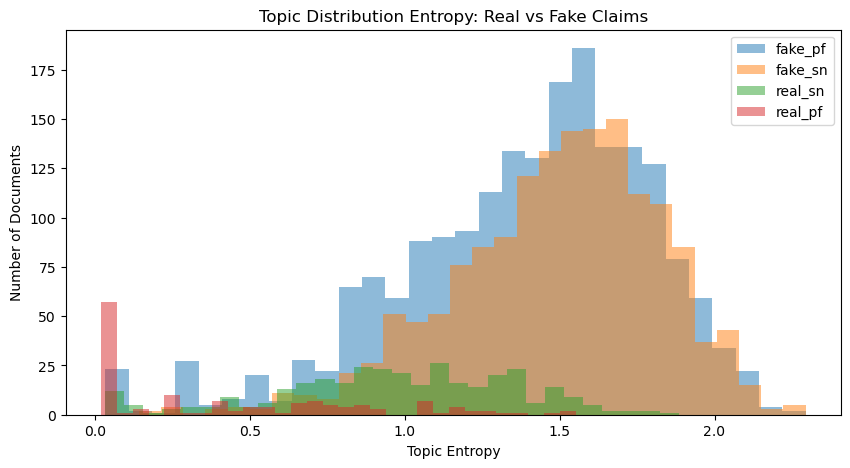

In [98]:
def calculate_topic_entropy(model, corpus):
    """Higher entropy = more distributed across topics (fake claims?)
       Lower entropy = concentrated in few topics (real claims?)"""
    from scipy.stats import entropy
    
    entropies = []
    
    for doc_bow in corpus:
        topic_dist = dict(model.get_document_topics(doc_bow, minimum_probability=0.0))
        probs = [topic_dist.get(i, 0.0) for i in range(model.num_topics)]
        
        # Calculate entropy
        ent = entropy(probs) if sum(probs) > 0 else 0
        entropies.append(ent)
    
    return np.array(entropies)

plt.figure(figsize=(10, 5))

desired_order = ['fake_pf', 'fake_sn', 'real_sn', 'real_pf']
reodered_k_map_lda = {k: best_k_map_lda[k] for k in desired_order}

# Compare entropy between real and fake
for name, k in reodered_k_map_lda.items():
    entropy = calculate_topic_entropy(models[f'{name}_{k}'], corpora_bow[name])
    print(f"{name} - Mean entropy: {entropy.mean():.3f} (±{entropy.std():.3f})")
    plt.hist(entropy, alpha=0.5, bins=30, label=name)

# Visualize
plt.xlabel('Topic Entropy')
plt.ylabel('Number of Documents')
plt.title('Topic Distribution Entropy: Real vs Fake Claims')
plt.legend()
plt.show()

### 7.3.5. Topic Similarity Between Organizations

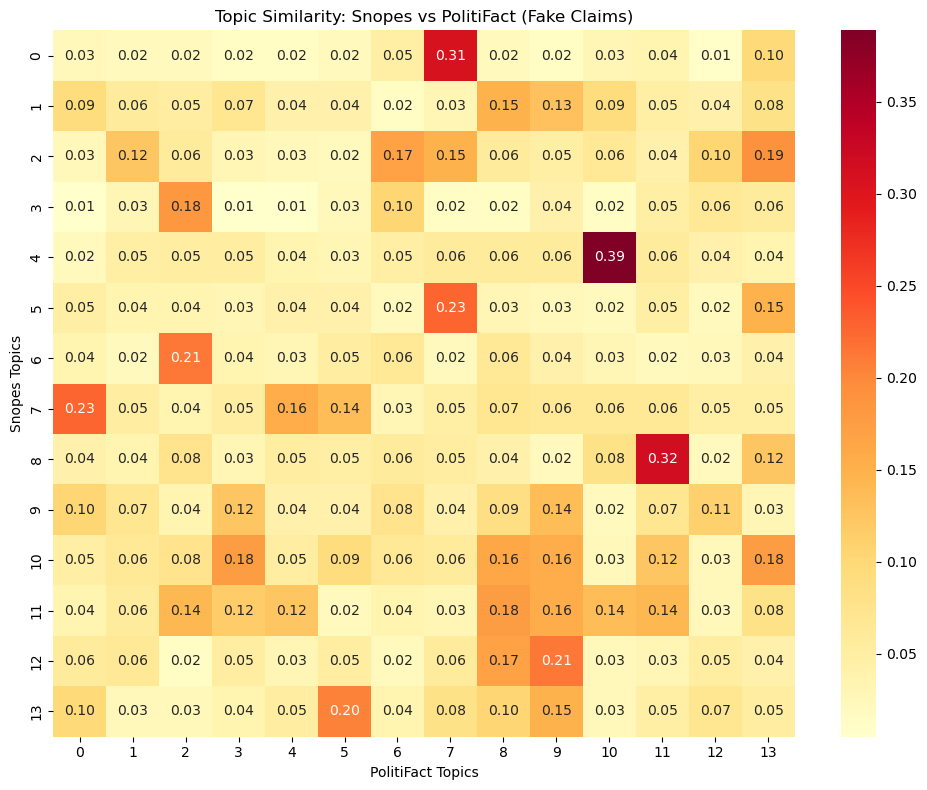

In [ ]:
def calculate_topic_similarity(model1, model2, n_words=100):
    """Calculate similarity between topics from two models using word overlap"""
    from itertools import product
    
    similarities = []
    
    for t1 in range(model1.num_topics):
        for t2 in range(model2.num_topics):
            # Get top words
            words1 = set([w for w, p in model1.show_topic(t1, topn=n_words)])
            words2 = set([w for w, p in model2.show_topic(t2, topn=n_words)])
            
            # Jaccard similarity
            intersection = len(words1 & words2)
            union = len(words1 | words2)
            similarity = intersection / union if union > 0 else 0
            
            similarities.append({
                'sn_topic': t1,
                'pf_topic': t2,
                'similarity': similarity
            })
    
    return pd.DataFrame(similarities)

# Usage - compare Snopes fake vs PolitiFact fake
sim_df = calculate_topic_similarity(
    models['fake_sn_14'], 
    models['fake_pf_14']
)

# Find best matches
pivot = sim_df.pivot(index='sn_topic', columns='pf_topic', values='similarity')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Topic Similarity: Snopes vs PolitiFact (Fake Claims)')
plt.xlabel('PolitiFact Topics')
plt.ylabel('Snopes Topics')
plt.tight_layout()
plt.show()

### 7.3.6. Topic Prevalence Over Time

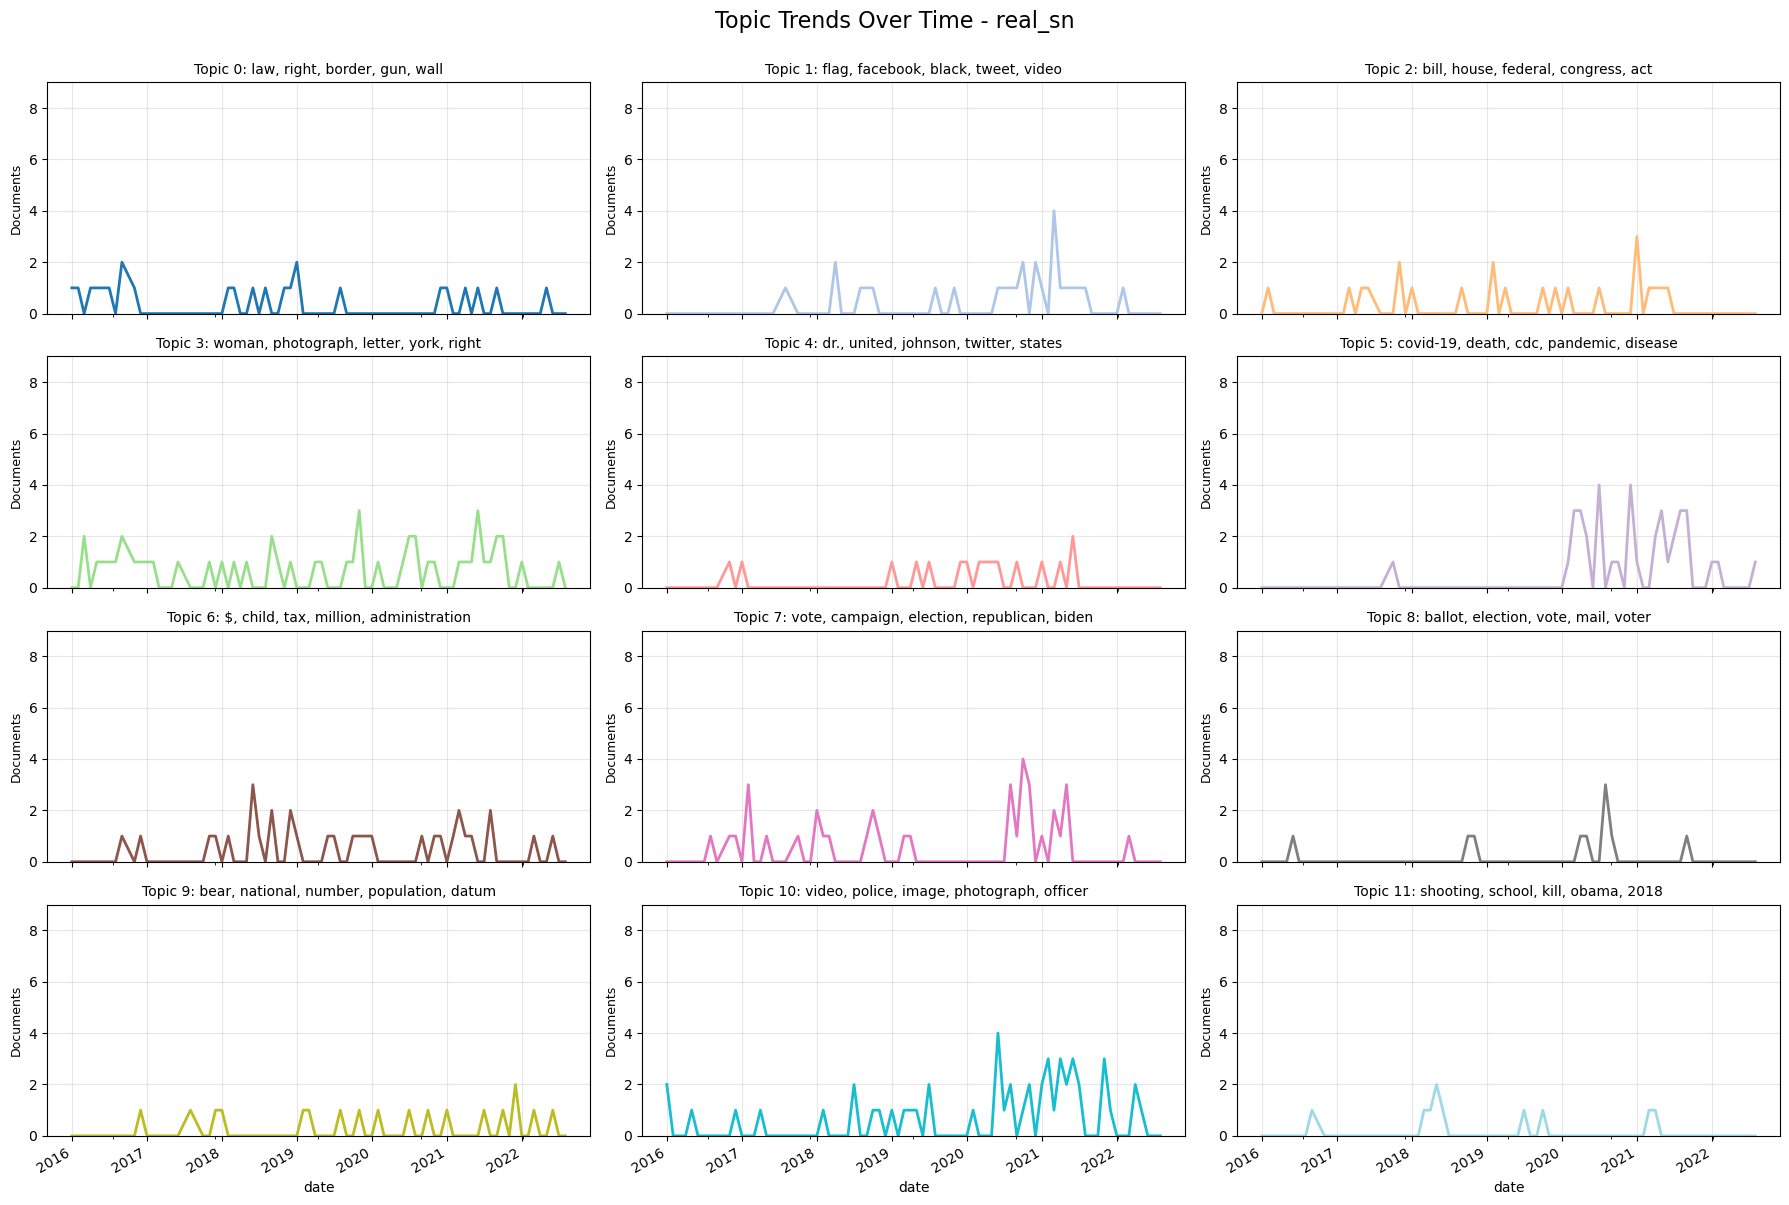

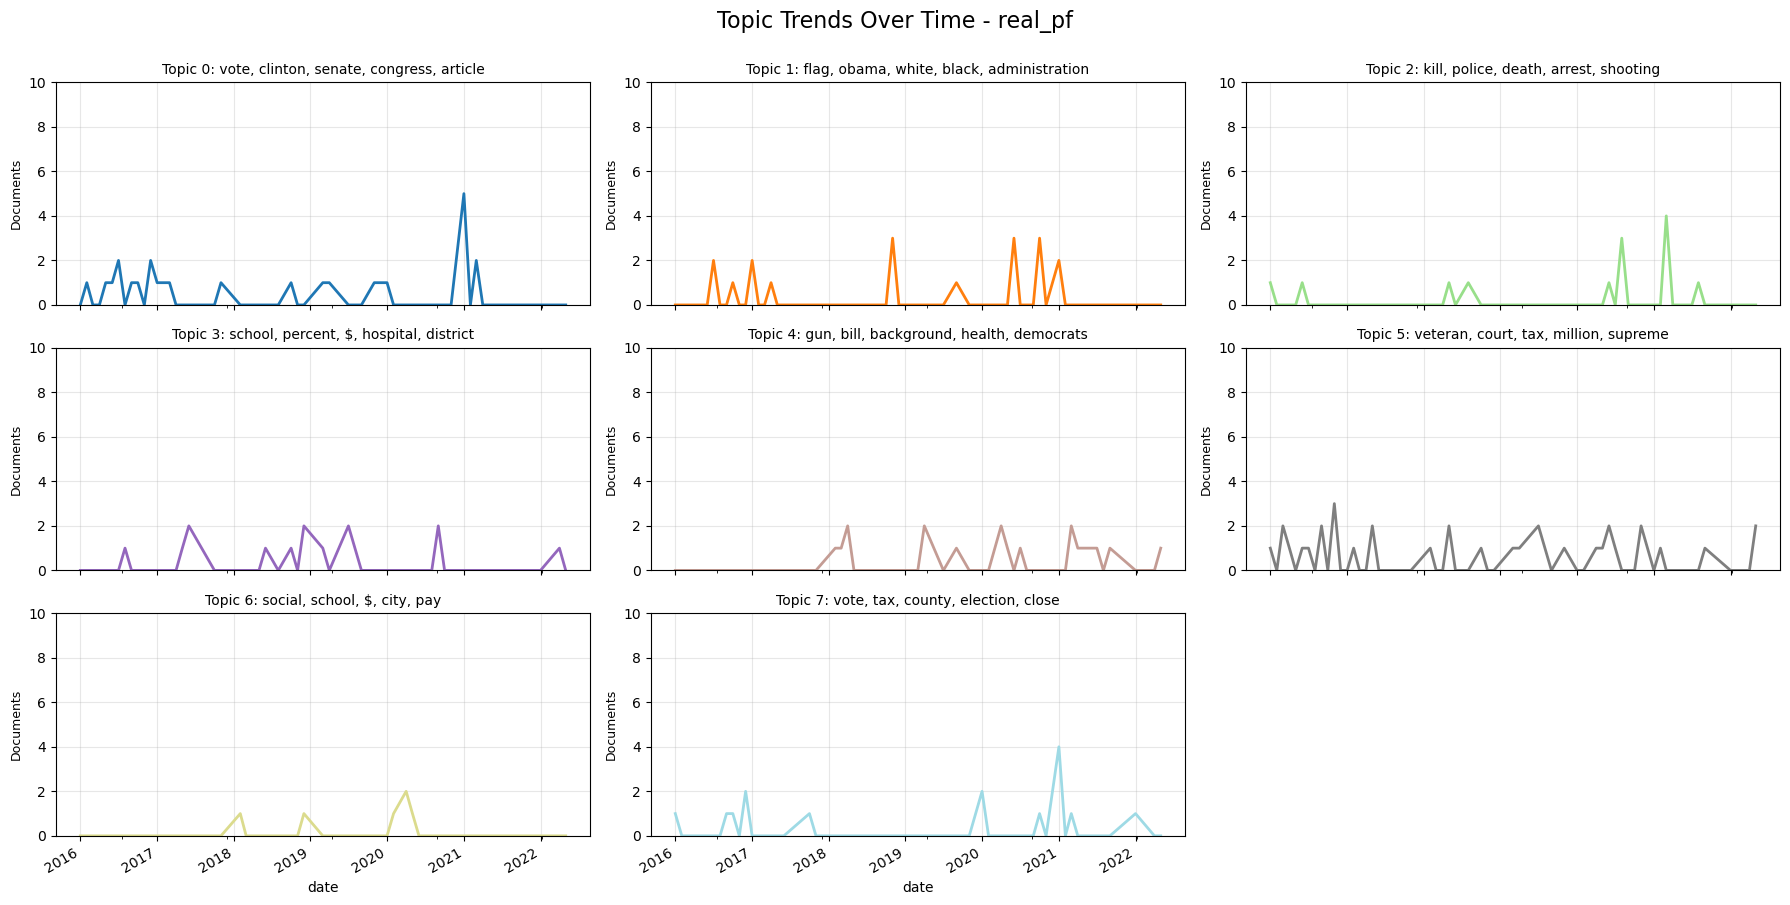

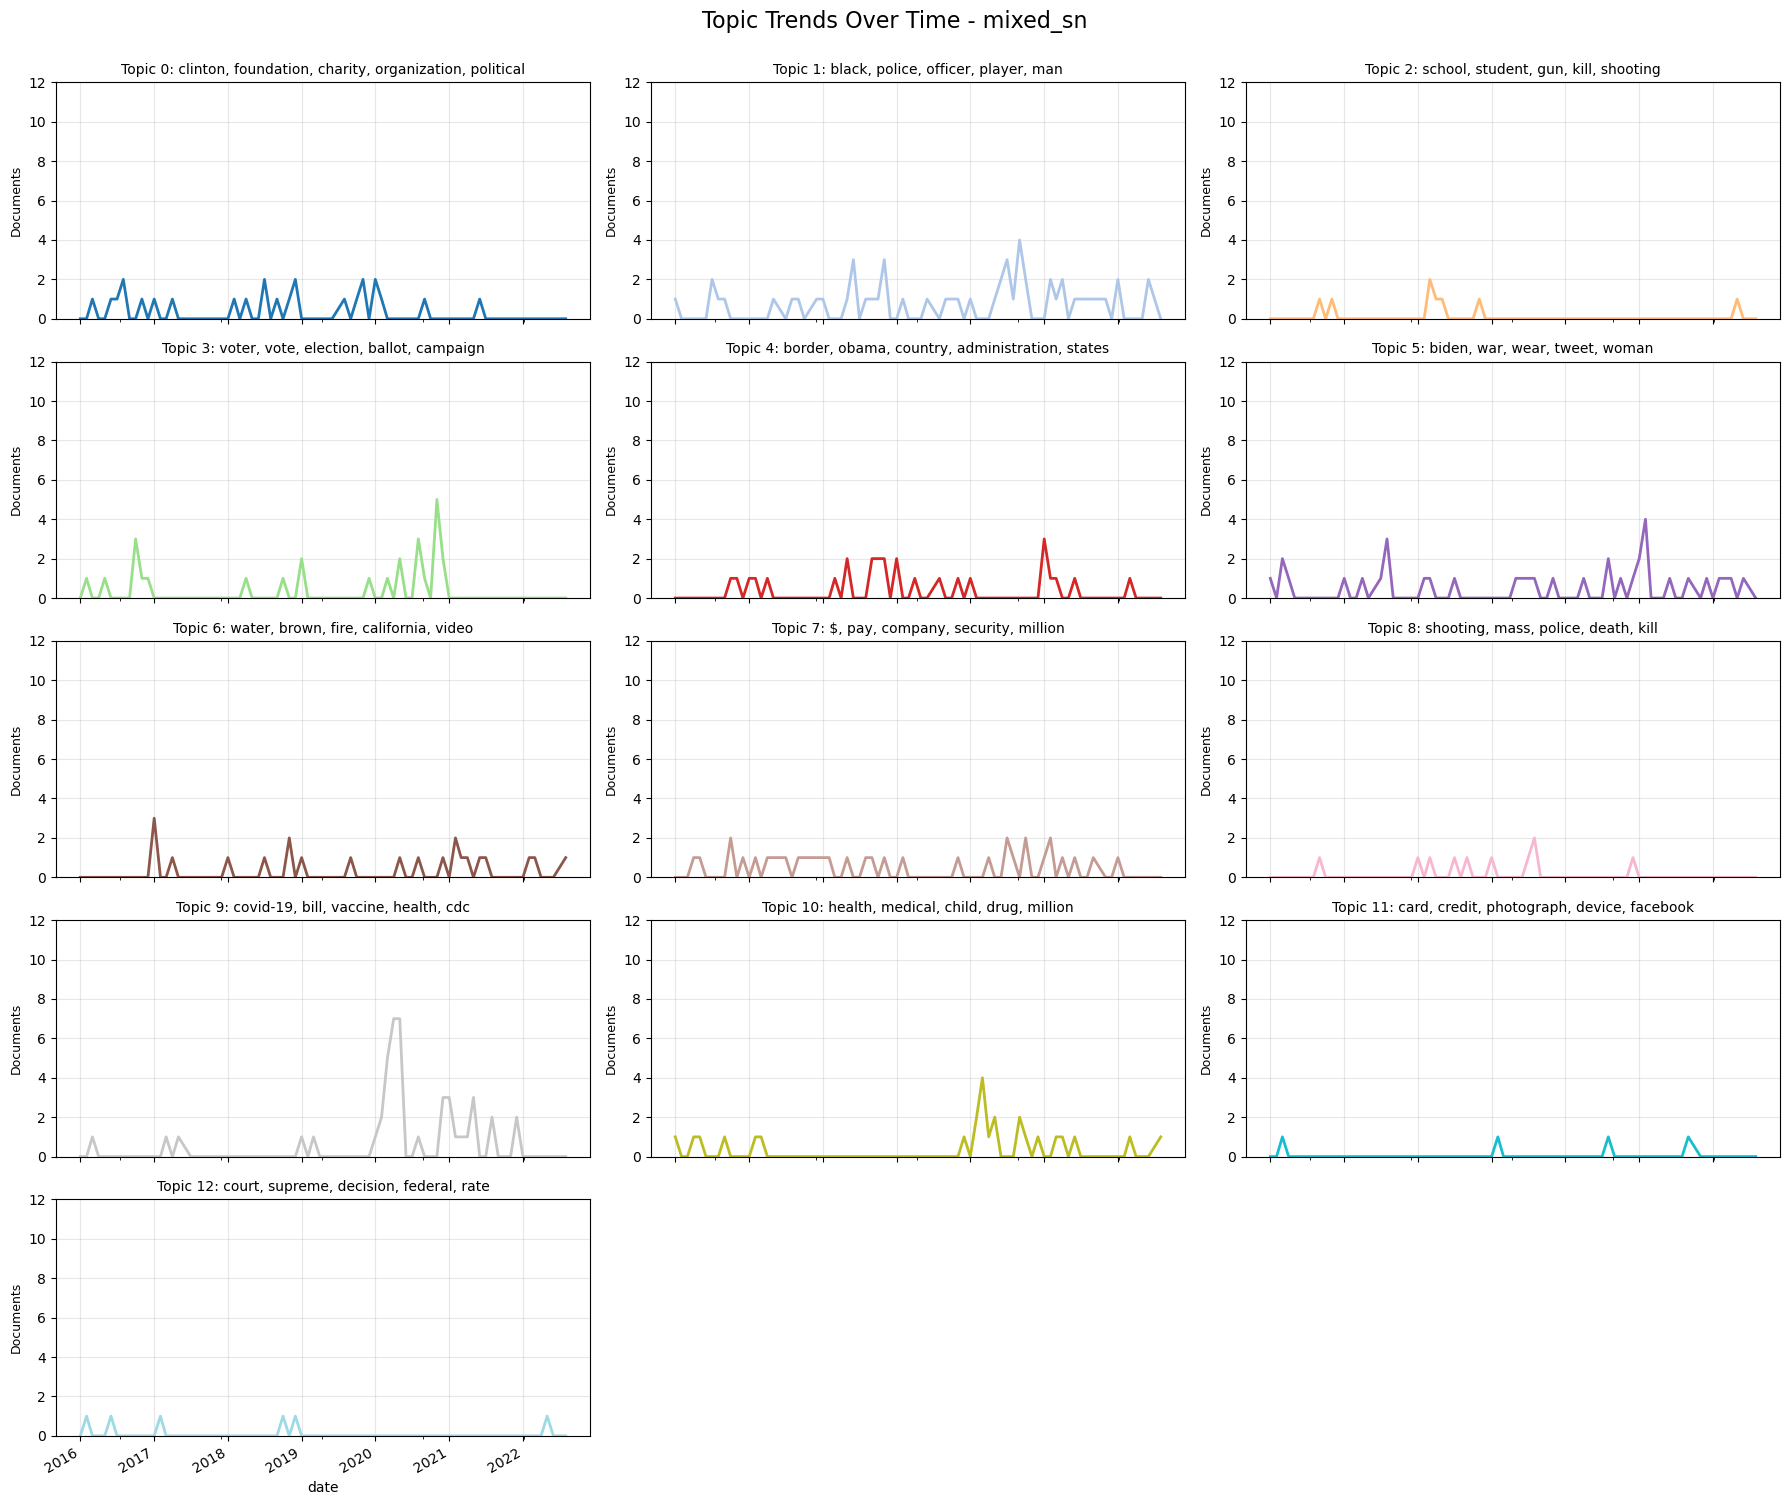

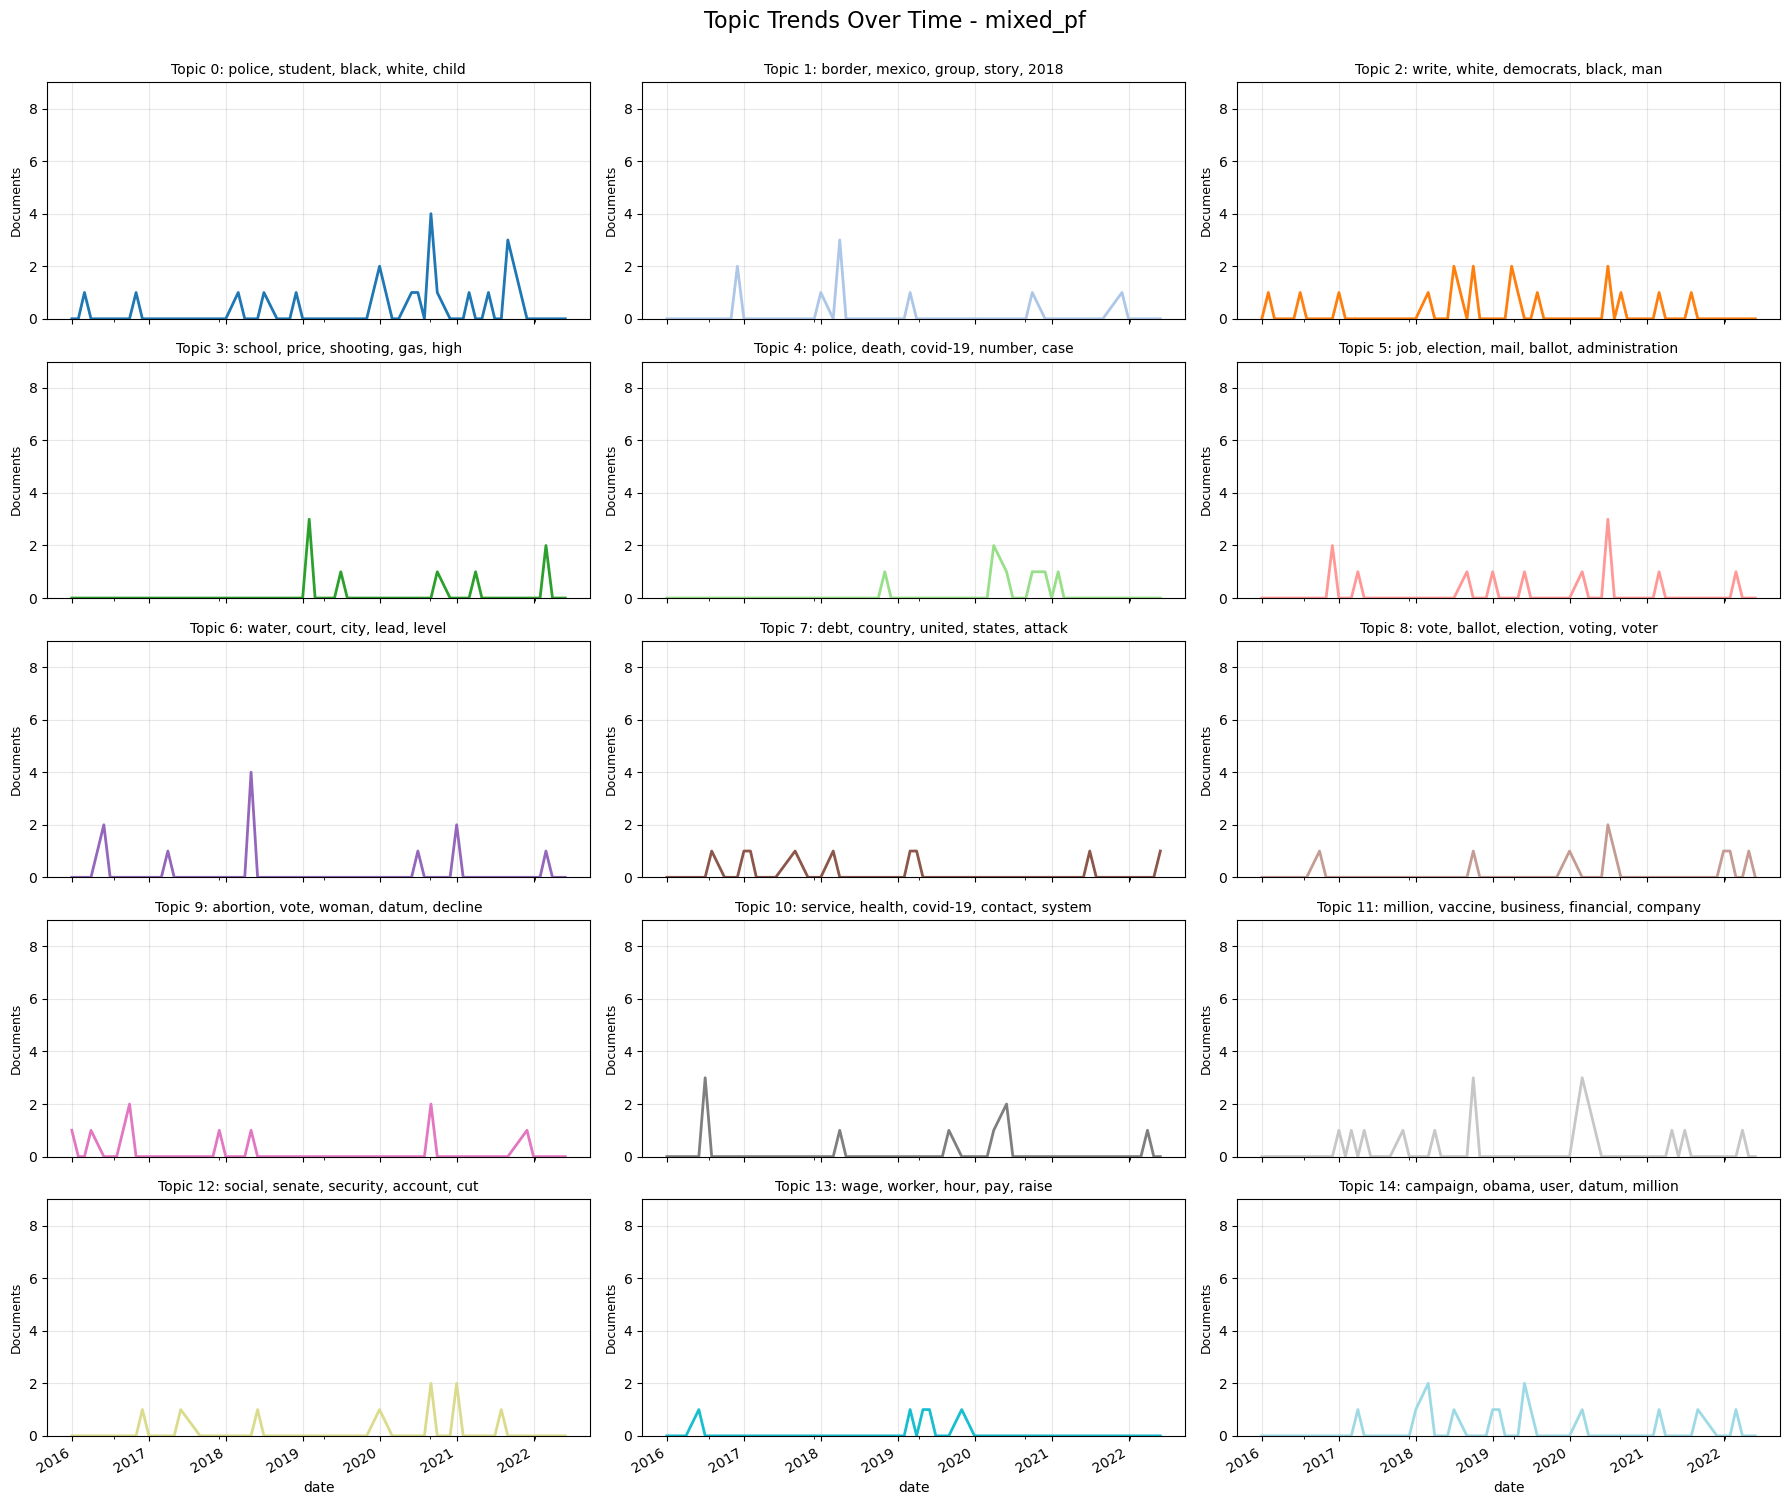

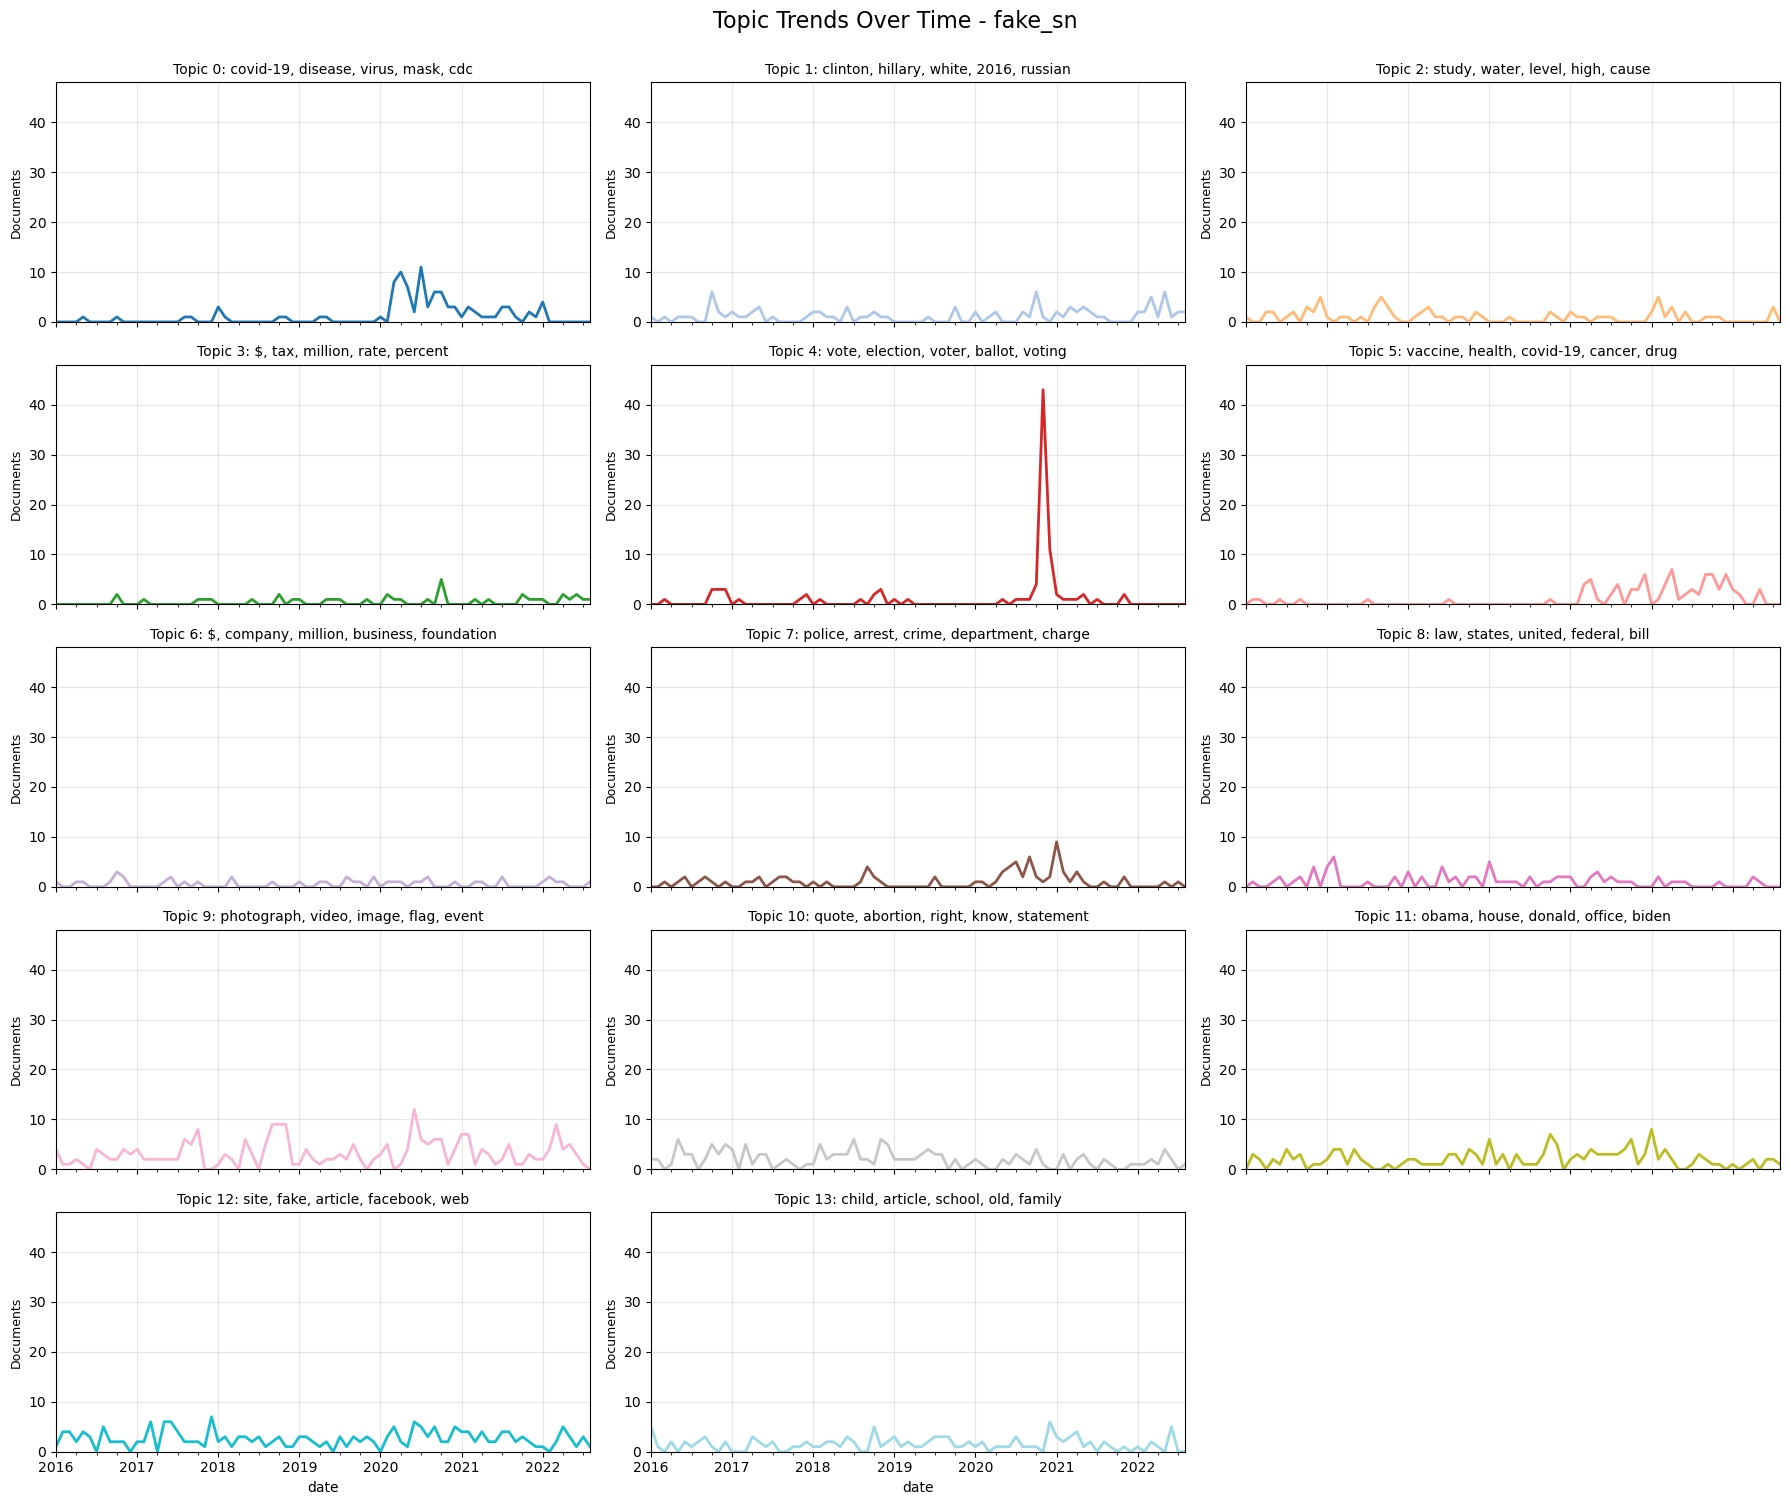

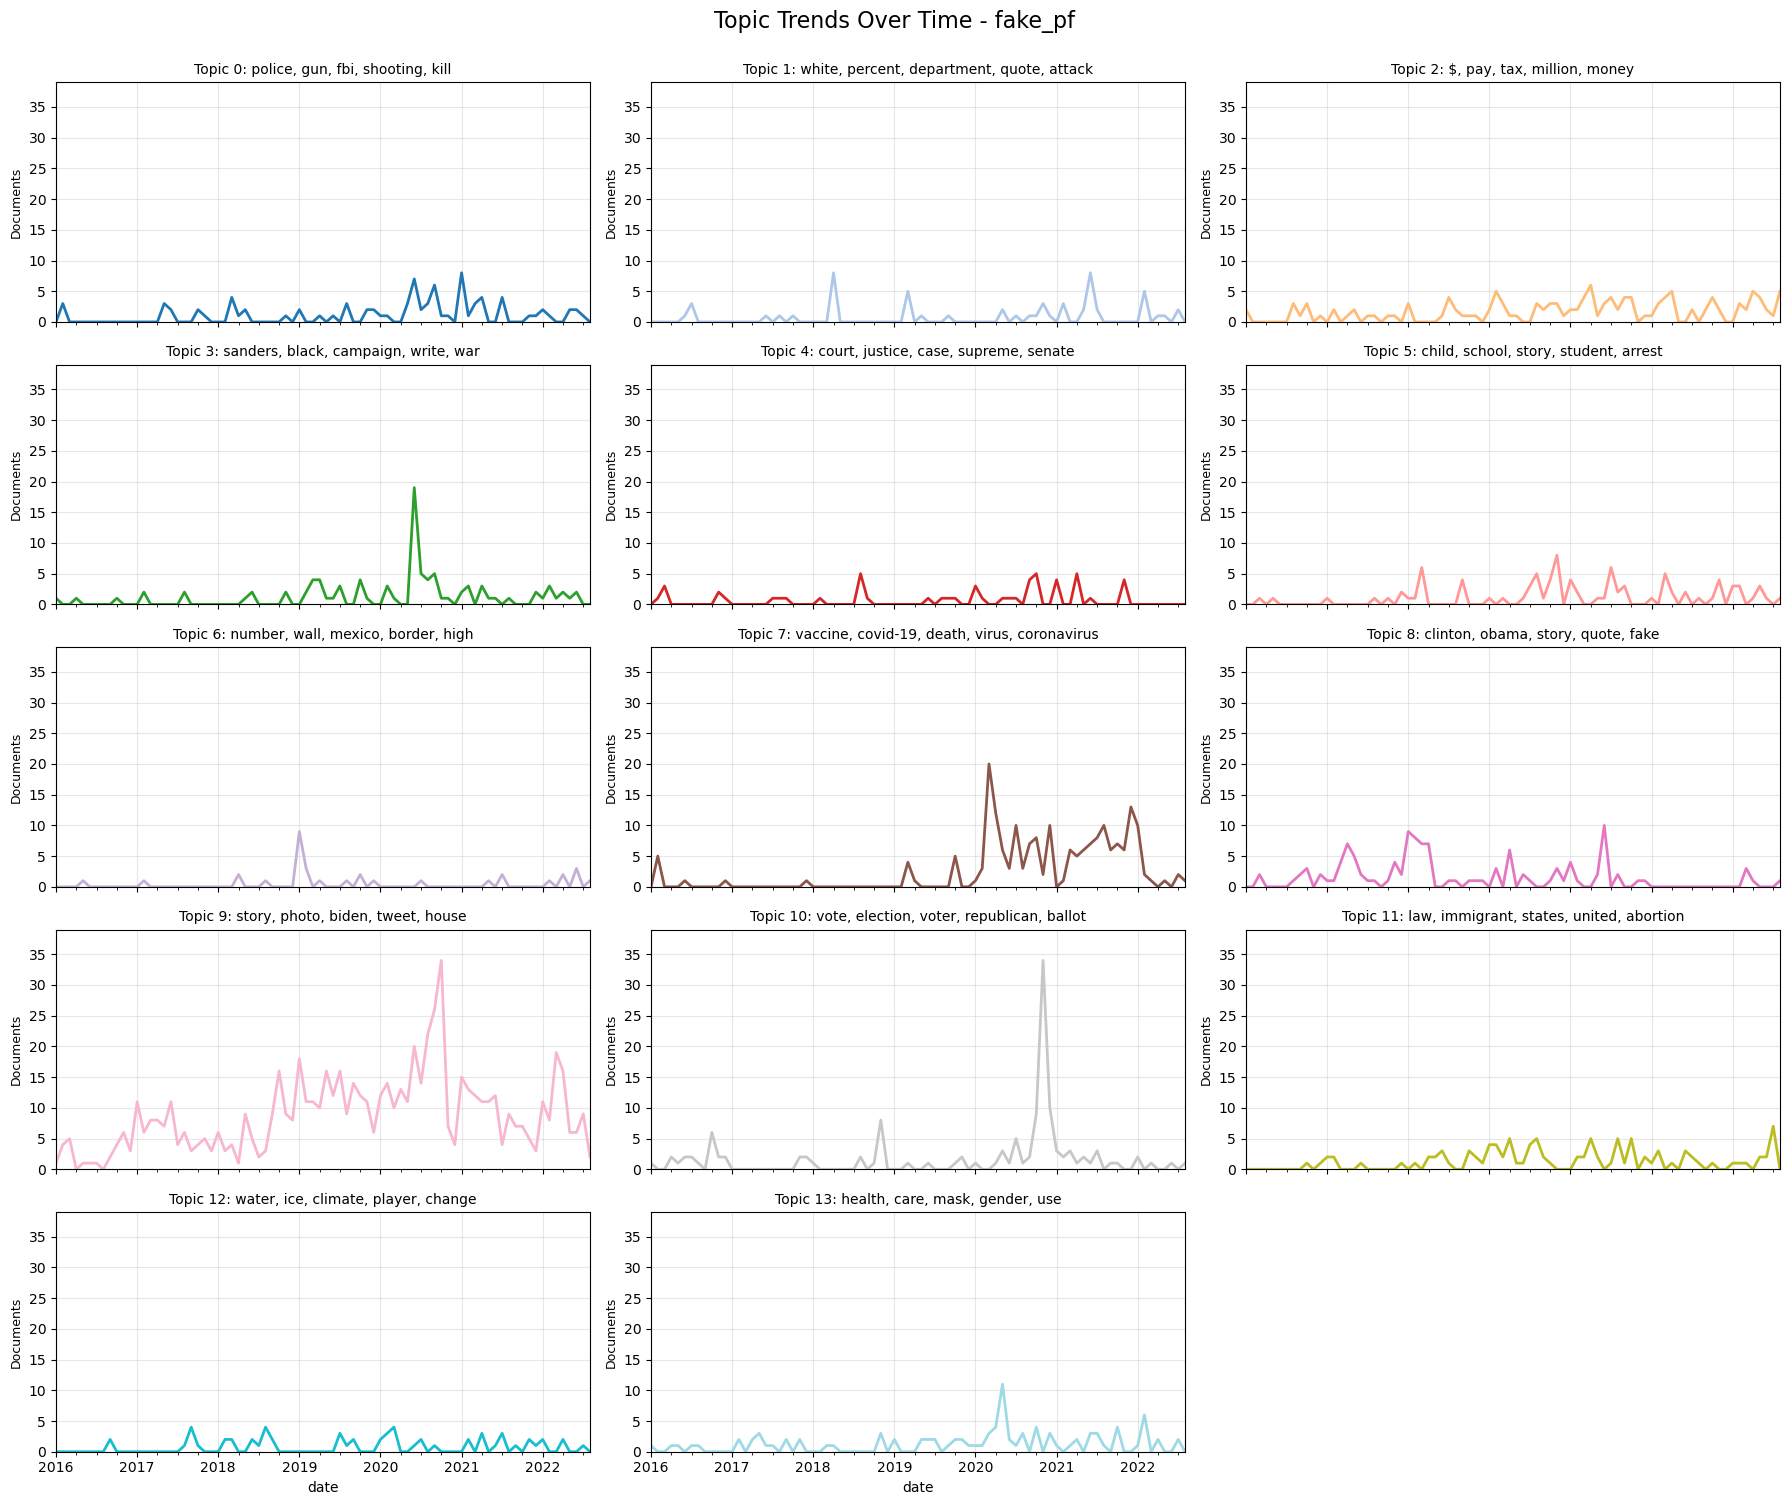

In [90]:
def plot_topics_over_time(model, corpus, dates, dataset_name, topics_to_show=None):
    """See how topic prevalence changes over time"""
    topic_by_date = []
    
    for doc_bow, date in zip(corpus, dates):
        topic_dist = dict(model.get_document_topics(doc_bow, minimum_probability=0))
        dominant = max(topic_dist.items(), key=lambda x: x[1])[0]
        
        topic_by_date.append({
            'date': date,
            'topic': dominant
        })
    
    df = pd.DataFrame(topic_by_date)
    df['date'] = pd.to_datetime(df['date'])
    
    # Group by month and topic
    monthly = df.groupby([df['date'].dt.to_period('M'), 'topic']).size().unstack(fill_value=0)
    monthly.index = monthly.index.to_timestamp()
    
    max_value = 0
    for i in monthly.columns:
        if max_value <= monthly[i].max():
            max_value = monthly[i].max()

    # Select topics to show
    if topics_to_show is None:
        topics_to_show = list(range(model.num_topics))
    
    # Create subplots
    n_topics = len(topics_to_show)
    n_cols = 3
    n_rows = (n_topics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 3*n_rows), sharex=True)
    axes = axes.flatten()
    
    colors = plt.cm.tab20(np.linspace(0, 1, model.num_topics))
    
    for idx, topic_id in enumerate(topics_to_show):
        ax = axes[idx]
        if topic_id in monthly.columns:
            monthly[topic_id].plot(ax=ax, color=colors[topic_id], linewidth=2)
            
            # Add topic label
            top_words = [w for w, p in model.show_topic(topic_id, topn=5)]
            ax.set_title(f'Topic {topic_id}: {", ".join(top_words[:5])}', fontsize=10)
            ax.set_ylabel('Documents', fontsize=9)
            ax.set_ylim(0, max_value+5)
            ax.grid(alpha=0.3)
    
    # Hide extra subplots
    for idx in range(len(topics_to_show), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'Topic Trends Over Time - {dataset_name}', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.show()


for name, k in best_k_map_lda.items():
    plot_topics_over_time(models[f'{name}_{k}'], corpora_bow[name], 
                        cleaned_data[name]['date'], name)

# Archive

### 7.3.3. Topic Proportions

In [ ]:
topic_proportions = {}  # dataset → DataFrame of topic proportions
best_models_lda = {}

for name, k in best_k_map_lda.items():
    model_name = f'{name}_{k}'
    best_models_lda[name] = models[model_name]


for name, model in best_models_lda.items():
    corpus = corpora_bow[name]
    num_topics = model.num_topics

    # list of length n_docs, each is list of (topic_id, prob)
    all_doc_topics = model.get_document_topics(corpus, minimum_probability=0)

    # convert to dense matrix
    gamma = []
    for doc in all_doc_topics:
        # doc is something like [(0, 0.1), (1, 0.4), ...]
        probs = [0.0] * num_topics
        for topic_id, p in doc:
            probs[topic_id] = p
        gamma.append(probs)

    topic_df = pd.DataFrame(
        gamma,
        columns=[f"topic_{i}" for i in range(num_topics)]
    )
    topic_proportions[name] = topic_df

    print(f"{name}: topic_proportions.shape = {topic_proportions[name].shape}")

real_sn: topic_proportions.shape = (334, 12)
real_pf: topic_proportions.shape = (142, 8)
mixed_sn: topic_proportions.shape = (317, 13)
mixed_pf: topic_proportions.shape = (163, 15)
fake_sn: topic_proportions.shape = (1593, 14)
fake_pf: topic_proportions.shape = (1939, 14)


#### Visualize Coherence

In [ ]:
#Visualise the coherence scores in a plot
x = range(start, limit, step)
plt.figure(figsize=(10,7))

plt.subplot(2, 2, 1)
plt.plot(x, coherence_values_sn_real)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title('Snopes - Real')

plt.subplot(2, 2, 2)
plt.plot(x, coherence_values_sn_fake)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title('Snopes - Fake')

plt.subplot(2, 2, 3)
plt.plot(x, coherence_values_pf_real)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title('Politifact - Real')

plt.subplot(2, 2, 4)
plt.plot(x, coherence_values_pf_fake)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title('Politifact - Fake')

plt.tight_layout()
plt.show()

#### Number of Topics with Highest Coherence

In [ ]:
#list the coherence scores
max_coherence_sn_real = max(coherence_values_sn_real)
num_topics_sn_real = x[coherence_values_sn_real.index(max_coherence_sn_real)]

max_coherence_sn_fake = max(coherence_values_sn_fake)
num_topics_sn_fake = x[coherence_values_sn_fake.index(max_coherence_sn_fake)]

max_coherence_pf_real = max(coherence_values_pf_real)
num_topics_pf_real = x[coherence_values_pf_real.index(max_coherence_pf_real)]

max_coherence_pf_fake = max(coherence_values_pf_fake)
num_topics_pf_fake = x[coherence_values_pf_fake.index(max_coherence_pf_fake)]

for m, cv in zip(x, coherence_values_sn_real):
    print("Num Topics SN =", m, " has Coherence Value of", round(cv, 4))

print('\n')
print(f'Max Coherence SN: {max_coherence_sn_real} at {num_topics_sn_real} topics')
print('\n')

print('=============================================================')

for m, cv in zip(x, coherence_values_sn_fake):
    print("Num Topics SN =", m, " has Coherence Value of", round(cv, 4))

print('\n')
print(f'Max Coherence SN: {max_coherence_sn_fake} at {num_topics_sn_fake} topics.')
print('\n')

print('=============================================================')

for m, cv in zip(x, coherence_values_pf_real):
    print("Num Topics PF =", m, " has Coherence Value of", round(cv, 4))

print('\n')
print(f'Max Coherence PF: {max_coherence_pf_real} at {num_topics_pf_real} topics.')
print('\n')

print('=============================================================')

for m, cv in zip(x, coherence_values_pf_fake):
    print("Num Topics PF =", m, " has Coherence Value of", round(cv, 4))

print('\n')
print(f'Max Coherence PF: {max_coherence_pf_fake} at {num_topics_pf_fake} topics.')
print('\n')


#### Topic Proportions

In [ ]:
model_sn_real = LdaModel(corpus=corpus_sn_real, num_topics=num_topics_sn_real, id2word=id2word_sn_real, random_state=42, passes=10, iterations=100)
model_sn_fake = LdaModel(corpus=corpus_sn_fake, num_topics=num_topics_sn_fake, id2word=id2word_sn_fake, random_state=42, passes=10, iterations=100)
model_pf_real = LdaModel(corpus=corpus_pf_real, num_topics=num_topics_pf_real, id2word=id2word_pf_real, random_state=42, passes=10, iterations=100)
model_pf_fake = LdaModel(corpus=corpus_pf_fake, num_topics=num_topics_pf_fake, id2word=id2word_pf_fake, random_state=42, passes=10, iterations=100)

In [ ]:
# Extract topic proportions
topic_proportions_sn_real = []
topic_proportions_sn_fake = []
topic_proportions_pf_real = []
topic_proportions_pf_fake = []

for doc in corpus_sn_real:
    proportions = model_sn_real.get_document_topics(doc, minimum_probability=0.0)
    topic_proportions_sn_real.append([p[1] for p in proportions])  # Extract only the probabilities

for doc in corpus_sn_fake:
    proportions = model_sn_fake.get_document_topics(doc, minimum_probability=0.0)
    topic_proportions_sn_fake.append([p[1] for p in proportions])  # Extract only the probabilities

for doc in corpus_pf_real:
    proportions = model_pf_real.get_document_topics(doc, minimum_probability=0.0)
    topic_proportions_pf_real.append([p[1] for p in proportions])  # Extract only the probabilities

for doc in corpus_pf_fake:
    proportions = model_pf_fake.get_document_topics(doc, minimum_probability=0.0)
    topic_proportions_pf_fake.append([p[1] for p in proportions])  # Extract only the probabilities

# Convert to a DataFrame for better readability
df_topic_proportions_sn_real = pd.DataFrame(topic_proportions_sn_real, columns=[f"Topic {i}" for i in range(model_sn_real.num_topics)])
df_topic_proportions_sn_fake = pd.DataFrame(topic_proportions_sn_fake, columns=[f"Topic {i}" for i in range(model_sn_fake.num_topics)])
df_topic_proportions_pf_real = pd.DataFrame(topic_proportions_pf_real, columns=[f"Topic {i}" for i in range(model_pf_real.num_topics)])
df_topic_proportions_pf_fake = pd.DataFrame(topic_proportions_pf_fake, columns=[f"Topic {i}" for i in range(model_pf_fake.num_topics)])

# Display the first few rows
display(df_topic_proportions_sn_real.head())
print('\n')
display(df_topic_proportions_sn_fake.head())
print('\n')
display(df_topic_proportions_pf_real.head())
print('\n')
display(df_topic_proportions_pf_fake.head())

In [ ]:
df_topic_proportions_pf_real[['Topic 3', 'Topic 4']]

#### Visualize Top Words Per Topic - Real Claims

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to extract top words for each topic
def extract_top_words_per_topic(model, num_words=10):
    topics = model.show_topics(num_topics=model.num_topics, num_words=num_words, formatted=False)
    topic_words = {}
    for topic_id, words in topics:
        topic_words[topic_id] = {word: weight for word, weight in words}
    return topic_words

# Extract top words for Snopes and Politifact
top_words_sn_real = extract_top_words_per_topic(model_sn_real, num_words=10)
top_words_pf_real = extract_top_words_per_topic(model_pf_real, num_words=10)

# Plot frequency plot for most common words in each topic using subplots
def plot_word_frequencies_in_subplots(topic_words, title_prefix):
    num_topics = len(topic_words)
    cols = 3  # Number of columns in the subplot grid
    rows = -(-num_topics // cols)  # Calculate the number of rows (ceiling division)

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))  # Adjust height based on rows
    axes = axes.flatten()  # Flatten the axes for easy indexing

    for idx, (topic_id, words) in enumerate(topic_words.items()):
        word_df = pd.DataFrame(words.items(), columns=["Word", "Weight"]).sort_values(by="Weight", ascending=False)
        axes[idx].barh(word_df["Word"], word_df["Weight"], color="skyblue")
        axes[idx].set_xlabel("Weight", fontsize=12)
        axes[idx].set_ylabel("Words", fontsize=12)
        axes[idx].set_title(f"{title_prefix} - Topic {topic_id}", fontsize=14)
        axes[idx].invert_yaxis()  # Invert y-axis to show the highest weight at the top

    # Hide any unused subplots
    for i in range(len(topic_words), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot for Snopes and Politifact topics
plot_word_frequencies_in_subplots(top_words_sn_real, title_prefix="Snopes (Real)")
print('\n')
plot_word_frequencies_in_subplots(top_words_pf_real, title_prefix="Politifact (Real)")


#### Visualize Top Words Per Topic - Fake Claims

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to extract top words for each topic
def extract_top_words_per_topic(model, num_words=10):
    topics = model.show_topics(num_topics=model.num_topics, num_words=num_words, formatted=False)
    topic_words = {}
    for topic_id, words in topics:
        topic_words[topic_id] = {word: weight for word, weight in words}
    return topic_words

# Extract top words for Snopes and Politifact
top_words_sn_fake = extract_top_words_per_topic(model_sn_fake, num_words=10)
top_words_pf_fake = extract_top_words_per_topic(model_pf_fake, num_words=10)

# Plot frequency plots for most common words in each topic using subplots
def plot_word_frequencies_in_subplots(topic_words, title_prefix):
    num_topics = len(topic_words)
    cols = 3  # Number of columns in the subplot grid
    rows = -(-num_topics // cols)  # Calculate the number of rows (ceiling division)

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))  # Adjust height based on rows
    axes = axes.flatten()  # Flatten the axes for easy indexing

    for idx, (topic_id, words) in enumerate(topic_words.items()):
        word_df = pd.DataFrame(words.items(), columns=["Word", "Weight"]).sort_values(by="Weight", ascending=False)
        axes[idx].barh(word_df["Word"], word_df["Weight"], color="skyblue")
        axes[idx].set_xlabel("Weight", fontsize=12)
        axes[idx].set_ylabel("Words", fontsize=12)
        axes[idx].set_title(f"{title_prefix} - Topic {topic_id}", fontsize=14)
        axes[idx].invert_yaxis()  # Invert y-axis to show the highest weight at the top

    # Hide any unused subplots
    for i in range(len(topic_words), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot for Snopes and Politifact topics (Fake topics)
plot_word_frequencies_in_subplots(top_words_sn_fake, title_prefix="Snopes (Fake)")
print('\n')
plot_word_frequencies_in_subplots(top_words_pf_fake, title_prefix="Politifact (Fake)")

#### Assign Topic Numbers to Documents

In [ ]:
# Assign the dominant topic for each document in `cleaned_text_real`
def assign_topics_to_documents(model, corpus):
    """
    Assigns the most dominant topic to each document based on the LDA model.

    Parameters:
        model: Trained LDA model.
        corpus: Bag-of-words representation of the documents.

    Returns:
        A list of dominant topic numbers for each document.
    """
    topic_assignments = []
    for doc in corpus:
        # Get topic probabilities for the document
        topic_probs = model.get_document_topics(doc, minimum_probability=0.0)
        # Extract the topic with the highest probability
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
        topic_assignments.append(dominant_topic)
    return topic_assignments

# Add topic numbers to the claims
cleaned_text_real['topic_sn_real'] = assign_topics_to_documents(model_sn_real, corpus_sn_real)
cleaned_text_fake['topic_sn_fake'] = assign_topics_to_documents(model_sn_fake, corpus_sn_fake)
cleaned_text_real['topic_pf_real'] = assign_topics_to_documents(model_pf_real, corpus_pf_real)
cleaned_text_fake['topic_pf_fake'] = assign_topics_to_documents(model_pf_fake, corpus_pf_fake)

# Verify the result
display(cleaned_text_real[['clean_sn', 'topic_sn_real']].head())


#### Save Documents with Topic Number

In [ ]:
# Add source and veracity columns for `cleaned_text_real` and `cleaned_text_fake`

# Snopes - Real
cleaned_text_real_snopes = cleaned_text_real[['claim_sn', 'body_sn', 'clean_sn', 'topic_sn_real']].copy()
cleaned_text_real_snopes['source'] = 'Snopes'
cleaned_text_real_snopes['veracity'] = 'Real'
cleaned_text_real_snopes.rename(columns={'claim_sn': 'claim', 'body_sn': 'body', 'clean_sn': 'clean_text', 'topic_sn_real': 'topic'}, inplace=True)

# Snopes - Fake
cleaned_text_fake_snopes = cleaned_text_fake[['claim_sn', 'body_sn', 'clean_sn', 'topic_sn_fake']].copy()
cleaned_text_fake_snopes['source'] = 'Snopes'
cleaned_text_fake_snopes['veracity'] = 'Fake'
cleaned_text_fake_snopes.rename(columns={'claim_sn': 'claim', 'body_sn': 'body', 'clean_sn': 'clean_text', 'topic_sn_fake': 'topic'}, inplace=True)

# Politifact - Real
cleaned_text_real_politifact = cleaned_text_real[['claim_pf', 'body_pf', 'clean_pf', 'topic_pf_real']].copy()
cleaned_text_real_politifact['source'] = 'Politifact'
cleaned_text_real_politifact['veracity'] = 'Real'
cleaned_text_real_politifact.rename(columns={'claim_pf': 'claim', 'body_pf': 'body', 'clean_pf': 'clean_text', 'topic_pf_real': 'topic'}, inplace=True)

# Politifact - Fake
cleaned_text_fake_politifact = cleaned_text_fake[['claim_pf', 'body_pf', 'clean_pf', 'topic_pf_fake']].copy()
cleaned_text_fake_politifact['source'] = 'Politifact'
cleaned_text_fake_politifact['veracity'] = 'Fake'
cleaned_text_fake_politifact.rename(columns={'claim_pf': 'claim', 'body_pf': 'body', 'clean_pf': 'clean_text', 'topic_pf_fake': 'topic'}, inplace=True)

# Combine all DataFrames
combined_df = pd.concat([
    cleaned_text_real_snopes,
    cleaned_text_fake_snopes,
    cleaned_text_real_politifact,
    cleaned_text_fake_politifact
], ignore_index=True)

# Verify the result
display(combined_df.head())

combined_df.to_excel('topics.xlsx')

#### Document Count Per Topic

In [ ]:
topic_count_sn_real = combined_df[(combined_df['source'] == 'Snopes') & (combined_df['veracity'] == 'Real')]['topic'].value_counts()
topic_count_sn_fake = combined_df[(combined_df['source'] == 'Snopes') & (combined_df['veracity'] == 'Fake')]['topic'].value_counts()
topic_count_pf_real = combined_df[(combined_df['source'] == 'Politifact') & (combined_df['veracity'] == 'Real')]['topic'].value_counts()
topic_count_pf_fake = combined_df[(combined_df['source'] == 'Politifact') & (combined_df['veracity'] == 'Fake')]['topic'].value_counts()

display(topic_count_sn_real)
display(topic_count_sn_fake)
display(topic_count_pf_real)
display(topic_count_pf_fake)

### 5.2.2. Veracity - Find All Possible Matches

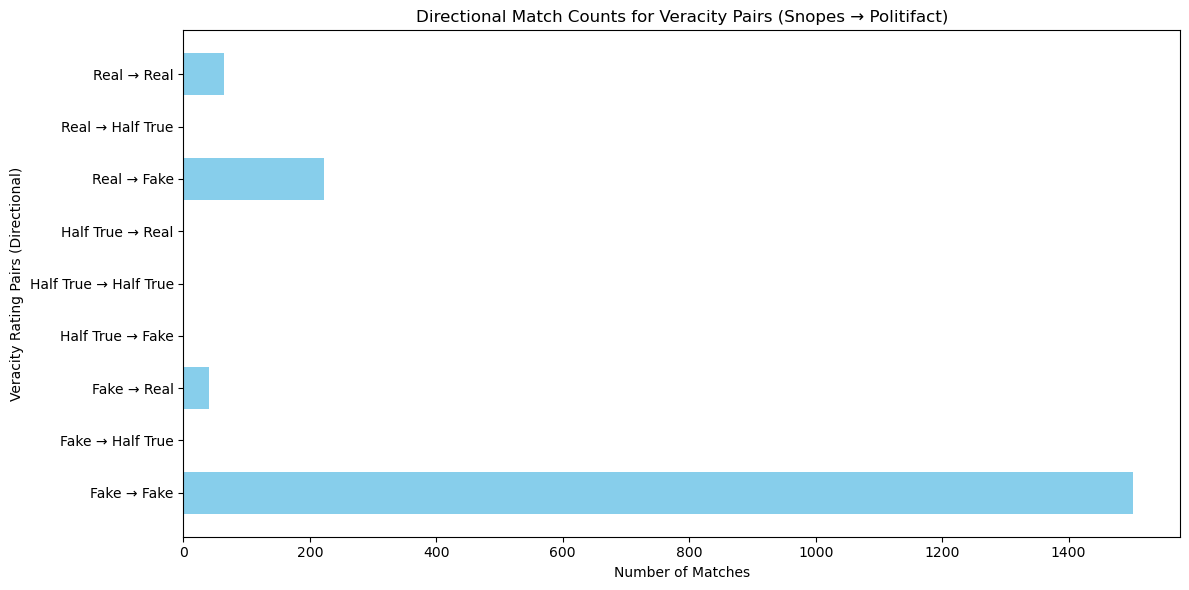

In [ ]:
# from collections import defaultdict
# import matplotlib.pyplot as plt

# # Define the possible veracity ratings
# veracity_ratings = ['Real', 'Half True', 'Fake']

# # Generate all possible matches
# veracity_combinations = [(v1, v2) for v1 in veracity_ratings for v2 in veracity_ratings]

# # Create a dictionary to store matches
# veracity_matches = {}

# # Iterate over all combinations and find matches
# for combo in veracity_combinations:
#     v1, v2 = combo
#     # Find indices where the matches occur
#     match_indices = match_df_final[
#         (match_df_final['veracity_sn'] == v1) & (match_df_final['veracity_pf'] == v2)
#     ].index.tolist()
#     # Store the indices
#     veracity_matches[combo] = match_indices

# # Prepare data for plotting
# veracity_labels = [f"{v1} → {v2}" for v1, v2 in veracity_matches.keys()]
# veracity_counts = [len(indices) for indices in veracity_matches.values()]

# # Plot the results
# plt.figure(figsize=(12, 6))
# plt.barh(veracity_labels, veracity_counts, color='skyblue')

# # Add labels and title
# plt.xlabel('Number of Matches')
# plt.ylabel('Veracity Rating Pairs (Directional)')
# plt.title('Directional Match Counts for Veracity Pairs (Snopes → Politifact)')
# plt.gca().invert_yaxis()  # Largest matches on top

# # Show the plot
# plt.tight_layout()
# plt.show()


## Checking Distribution of Ratings Before and After Normalization

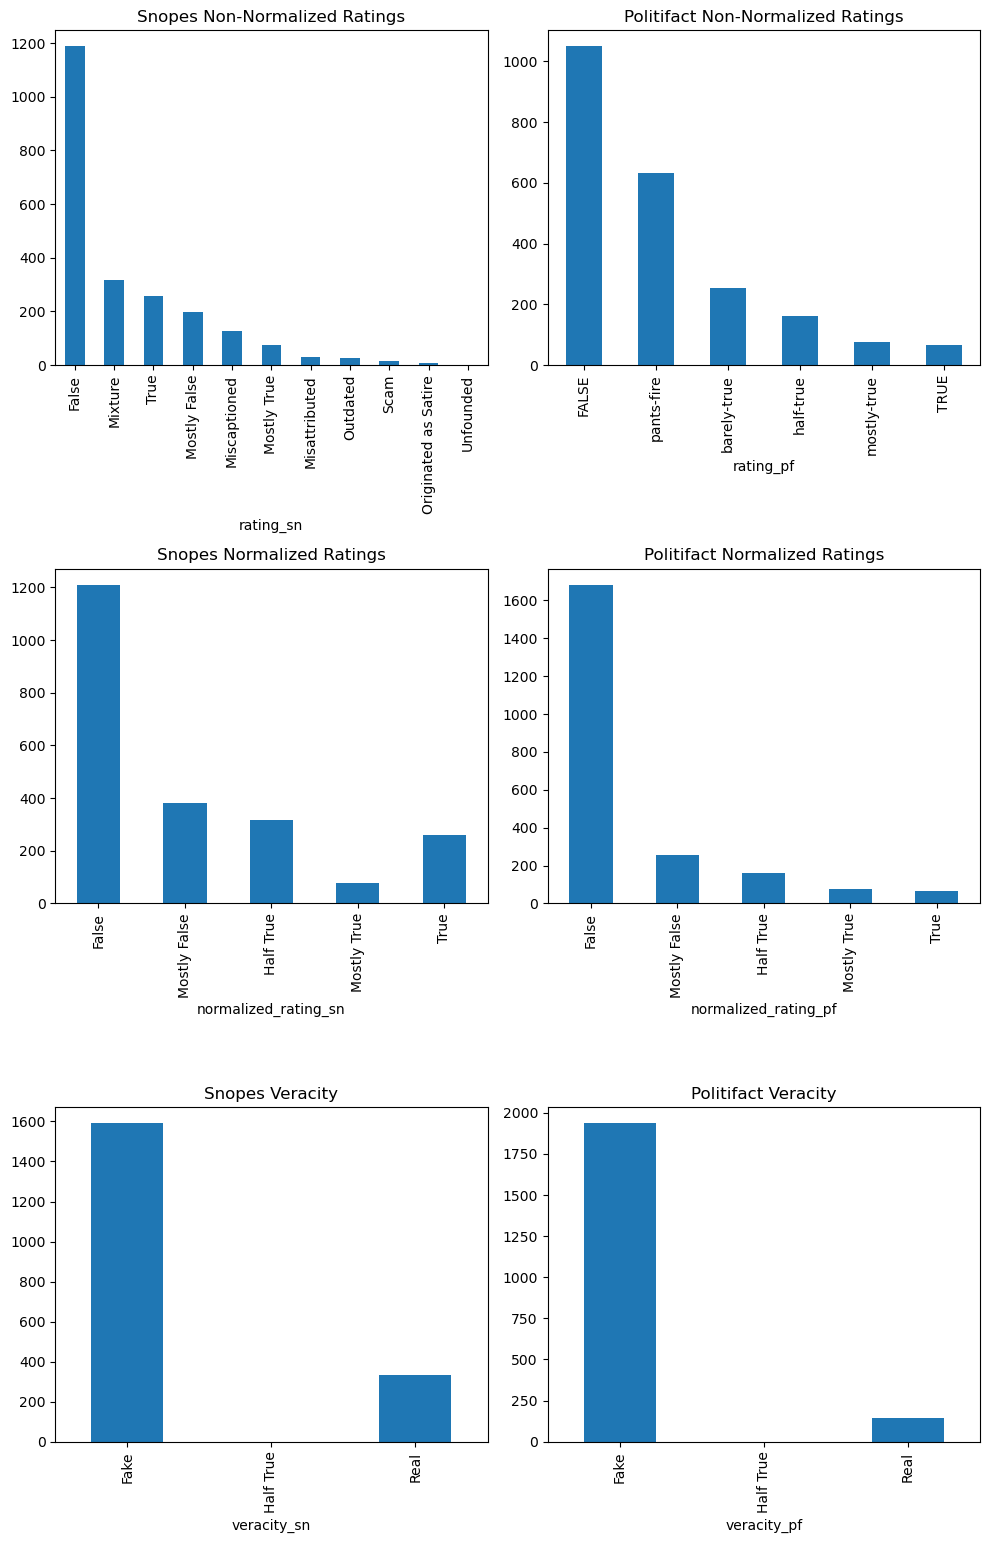

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 20))

rotation = 90

# Define the manual order for the bars
custom_order_veracity = ['Fake', 'Half True', 'Real']
custom_order_rating = ['False', 'Mostly False', 'Half True', 'Mostly True', 'True']

# Snopes Non-Normalized Ratings
plt.subplot(4, 2, 1)
match_df_final['rating_sn'].value_counts().plot(kind='bar', title='Snopes Non-Normalized Ratings')
plt.xticks(rotation=rotation)

# Politifact Non-Normalized Ratings
plt.subplot(4, 2, 2)
match_df_final['rating_pf'].value_counts().plot(kind='bar', title='Politifact Non-Normalized Ratings')
plt.xticks(rotation=rotation)

# Snopes Normalized Ratings
plt.subplot(4, 2, 3)
match_df_final['normalized_rating_sn'].value_counts().reindex(custom_order_rating).plot(kind='bar', title='Snopes Normalized Ratings')
plt.xticks(rotation=rotation)

# Politifact Normalized Ratings
plt.subplot(4, 2, 4)
match_df_final['normalized_rating_pf'].value_counts().reindex(custom_order_rating).plot(kind='bar', title='Politifact Normalized Ratings')
plt.xticks(rotation=rotation)

# Snopes Veracity
plt.subplot(4, 2, 5)
match_df_final['veracity_sn'].value_counts().reindex(custom_order_veracity).plot(kind='bar', title='Snopes Veracity')
plt.xticks(rotation=rotation)

# Politifact Veracity
plt.subplot(4, 2, 6)
match_df_final['veracity_pf'].value_counts().reindex(custom_order_veracity).plot(kind='bar', title='Politifact Veracity')
plt.xticks(rotation=rotation)

plt.tight_layout()
plt.show()


In [ ]:
# Calculate the percentage of each normalized rating for snopes and politifact
normalized_rating_counts_sn = match_df_final['normalized_rating_sn'].value_counts(normalize=True) * 100
normalized_rating_counts_pf = match_df_final['normalized_rating_pf'].value_counts(normalize=True) * 100

print("Normalized Ratings for Snopes:")
print(normalized_rating_counts_sn)

print("\nNormalized Ratings for Politifact:")
print(normalized_rating_counts_pf)

Normalized Ratings for Snopes:
normalized_rating_sn
False          53.966
Mostly False   17.023
Half True      14.127
True           11.497
Mostly True     3.387
Name: proportion, dtype: float64

Normalized Ratings for Politifact:
normalized_rating_pf
False          75.045
Mostly False   11.364
Half True       7.264
Mostly True     3.342
True            2.986
Name: proportion, dtype: float64


### Copy of code

In [ ]:
sn = pd.read_csv("snopes.csv")
pf = pd.read_csv("politifact.csv")

sn['date_published'] = pd.to_datetime(sn['date_published'])
pf['fc_date'] = pd.to_datetime(pf['fc_date'])
len(sn) # 11639
len(pf) # 10710

statements = pd.concat([pf['body'],sn['body']],ignore_index=True)
len(statements) == len(pf) + len(sn)
statements.isnull().sum()

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(statements)
arr = X.toarray()
arr_pf = arr[:len(pf)]
arr_sn = arr[len(pf):]

len(arr_pf)==len(pf)
len(arr_sn)==len(sn)


''' Evaluation'''
def sim(arr1,arr2,cri):
    tfidf_sim = cosine_similarity(arr1,arr2)
    x = cri
    y1 = [any(y>x for y in tf) for tf in tfidf_sim]
    y2 = [any(y>x for y in tf) for tf in tfidf_sim.T]
    return tfidf_sim, y1, y2, sum(y1), sum(y2), (sum(y1)/len(arr1))*100, (sum(y2)/len(arr2))*100

tfidf_sim, y1, y2, sumy1, sumy2, y1p, y2p = sim(arr_sn,arr_pf,0.5)

pf['content_owner'] = "PolitiFact"

sn['overlap'] = y1
pf['overlap'] = y2

len(sn[sn['overlap']==1])

sim_result = {}
sim_result['sim_score'] = []
sim_result['website'] = []
sim_result['claim'] = []
sim_result['rating'] = []
sim_result['link'] = []
sim_result['date'] = []
sim_result['website2'] = []
sim_result['claim2'] = []
sim_result['rating2'] = []
sim_result['link2'] = []
sim_result['date2'] = []

tfidf_sim[0][tfidf_sim[0].argmax()]
# SN based similarity
for i in range(len(sn)):
    if tfidf_sim[i].max() >= 0.5:
        sim_result['sim_score'].append(round(tfidf_sim[i].max(),3))
        sim_result['website'].append(sn['content_owner'][i])
        sim_result['claim'].append(sn['claim'][i])
        sim_result['rating'].append(sn['rating'][i])
        sim_result['link'].append(sn['link'][i])
        sim_result['date'].append(sn['date_published'][i])
        sim_result['website2'].append(pf['content_owner'][tfidf_sim[i].argmax()])
        sim_result['claim2'].append(pf['claim'][tfidf_sim[i].argmax()])
        sim_result['rating2'].append(pf['rating'][tfidf_sim[i].argmax()])
        sim_result['link2'].append(pf['link'][tfidf_sim[i].argmax()])
        sim_result['date2'].append(pf['fc_date'][tfidf_sim[i].argmax()])

In [ ]:
match_df_copy = pd.DataFrame(sim_result)

# Add columns for claim veracity from both Snopes and PolitiFact
match_df_copy["veracity"] = match_df_copy["rating"]    # Veracity from Snopes
match_df_copy["veracity2"] = match_df_copy["rating2"]  # Veracity from PolitiFact

# Normalize veracity ratings: map truth ratings to 'real' and false ratings to 'fake'
match_df_copy.loc[match_df_copy["veracity"] == 'True', "veracity"] = 'real'
match_df_copy.loc[match_df_copy["veracity"] == 'Mostly True', "veracity"] = 'real'
match_df_copy.loc[match_df_copy["veracity"] == 'Mostly False', "veracity"] = 'fake'
match_df_copy.loc[match_df_copy["veracity"] == 'False', "veracity"] = 'fake'

match_df_copy.loc[match_df_copy["veracity2"] == 'True', "veracity2"] = 'real'
match_df_copy.loc[match_df_copy["veracity2"] == 'Mostly True', "veracity2"] = 'real'
match_df_copy.loc[match_df_copy["veracity2"] == 'Mostly False', "veracity2"] = 'fake'
match_df_copy.loc[match_df_copy["veracity2"] == 'False', "veracity2"] = 'fake'

# Store all indexs of rows with mismatching rating and veracity scores
mismatch_index = match_df_copy[match_df_copy['veracity'] != match_df_copy['veracity2']].index
mismatched_df_copy = match_df_copy.iloc[mismatch_index]
mismatched_df_copy.to_excel('copy_mismatched_df.xlsx')
match_df_copy.to_excel('copy_match_df.xlsx')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Features and target
X = match_df_final[['sentiment_score', 'toxicity_score']]
y = match_df_final['veracity']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
print(classification_report(y_test, y_pred))

### Visualization and Results

In [ ]:
# Plot the normalized ratings for the rows with positive and negative sentiment
plt.figure(figsize=(10, 20))

custom_order_rating = ['False', 'Mostly False', 'Half True', 'Mostly True', 'True']

plt.subplot(6, 2, 1)
negative_sentiment['normalized_rating_sn'].value_counts().reindex(custom_order_rating).plot(kind='bar', title='Ratings for Negative Sentiment - Snopes')
plt.xticks(rotation=90)

plt.subplot(6, 2, 2)
negative_sentiment['normalized_rating_pf'].value_counts().reindex(custom_order_rating).plot(kind='bar', title='Ratings for Negative Sentiment - Politifact')
plt.xticks(rotation=90)

plt.subplot(6, 2, 3)
positive_sentiment['normalized_rating_sn'].value_counts().reindex(custom_order_rating).plot(kind='bar', title='Ratings for Positive Sentiment - Snopes')
plt.xticks(rotation=90)

plt.subplot(6, 2, 4)
positive_sentiment['normalized_rating_pf'].value_counts().reindex(custom_order_rating).plot(kind='bar', title='Ratings for Positive Sentiment - Politifacts')
plt.xticks(rotation=90)

plt.subplot(6, 2, 5)
neutral_sentiment['normalized_rating_sn'].value_counts().reindex(custom_order_rating).plot(kind='bar', title='Ratings for Neutral Sentiment - Snopes')
plt.xticks(rotation=90)

plt.subplot(6, 2, 6)
neutral_sentiment['normalized_rating_pf'].value_counts().reindex(custom_order_rating).plot(kind='bar', title='Ratings for Neutral Sentiment - Politifact')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(match_df_final[['sentiment_score', 'toxicity_score', 'sentiment_score2', 'toxicity_score2']])

# Add PCA results to dataframe
match_df_final['pca1'] = pca_result[:, 0]
match_df_final['pca2'] = pca_result[:, 1]

# Scatter plot for clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='pca1', y='pca2', hue='veracity', data=match_df_final, palette='viridis')
plt.title('Cluster Visualization of Sentiment and Toxicity')
plt.show()

In [ ]:
# Convert date columns to datetime
match_df_final['date'] = pd.to_datetime(match_df_final['date'])
match_df_final['date2'] = pd.to_datetime(match_df_final['date2'])

# Group by date and count false claims
df_snopes_false = match_df_final[match_df_final['veracity'] == 'fake'].groupby(match_df_final['date'].dt.to_period('M')).size()
df_politifact_false = match_df_final[match_df_final['veracity2'] == 'fake'].groupby(match_df_final['date2'].dt.to_period('M')).size()

# Plot time series
plt.figure(figsize=(12, 6))
df_snopes_false.plot(label='Snopes False Claims')
df_politifact_false.plot(label='Politifact False Claims')
plt.title('Trends in False Claims Over Time')
plt.xlabel('Date')
plt.ylabel('Number of False Claims')
plt.legend()
plt.show()

### 1.What is the level of agreement (e.g., Cohen’s Kappa) among different fact-checking organizations for matching claims?

In [ ]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
#map ratings to binary values for simplicity (True=1, False=0)
match_df_final['veracity_binary'] = match_df_final['veracity'].map({'real': 1, 'fake': 0})
match_df_final['veracity2_binary'] = match_df_final['veracity2'].map({'real': 1, 'fake': 0})
match_df_veracity= match_df_final.dropna(subset=['veracity_binary', 'veracity2_binary'])
# Calculate Cohen's Kappa
kappa_score = cohen_kappa_score(match_df_veracity['veracity_binary'], match_df_veracity['veracity2_binary'])
print(f"Cohen's Kappa Score: {kappa_score:.2f}")


# Create confusion matrix
conf_matrix = confusion_matrix(match_df_veracity['veracity_binary'], match_df_veracity['veracity2_binary'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Politifact Veracity')
plt.ylabel('Snopes Veracity')
plt.title('Agreement Heatmap Between Snopes and Politifact')
plt.show()

### 2.Is there a significant correlation between the toxicity level of claims (e.g., inflammatory language) and the agreement among fact-checkers?

In [ ]:
# Calculate the toxicity difference
match_df_veracity['toxicity_diff'] = abs(match_df_veracity['toxicity_score'] - match_df_veracity['toxicity_score2'])

# Create an 'agreement' column
match_df_veracity['agreement'] = match_df_veracity['veracity_binary'] == match_df_veracity['veracity2_binary']

# Group by 'agreement' and calculate the mean toxicity difference
toxicity_diff_by_agreement = match_df_veracity.groupby('agreement')['toxicity_diff'].mean()
print(toxicity_diff_by_agreement)

# Statistical test (t-test)
from scipy.stats import ttest_ind

agree_toxicity = match_df_veracity[match_df_veracity['agreement']]['toxicity_diff']
disagree_toxicity = match_df_veracity[~match_df_veracity['agreement']]['toxicity_diff']
t_stat, p_value = ttest_ind(agree_toxicity, disagree_toxicity)
print(f"T-test p-value: {p_value:.4f}")

# Plot a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='agreement', y='toxicity_diff', data=match_df_veracity, palette='Set2')
plt.xticks([0, 1], ['Disagree', 'Agree'])
plt.xlabel('Agreement')
plt.ylabel('Absolute Toxicity Difference')
plt.title('Toxicity Difference by Agreement')
plt.show()


### 3.Do Snopes and Politifact show higher or lower consistency in rating claims with high toxicity compared to those with lower toxicity?

In [ ]:
from sklearn.metrics import cohen_kappa_score

# Define high toxicity threshold
toxicity_threshold = 0.5

# Split the data into high and low toxicity based on the defined threshold
high_toxicity = match_df_veracity[(match_df_veracity['toxicity_score'] > toxicity_threshold) | (match_df_veracity['toxicity_score2'] > toxicity_threshold)]
low_toxicity = match_df_veracity[(match_df_veracity['toxicity_score'] <= toxicity_threshold) & (match_df_veracity['toxicity_score2'] <= toxicity_threshold)]

# Calculate Cohen's Kappa for high and low toxicity data
kappa_high = cohen_kappa_score(high_toxicity['veracity_binary'], high_toxicity['veracity2_binary'])
kappa_low = cohen_kappa_score(low_toxicity['veracity_binary'], low_toxicity['veracity2_binary'])
print(f"Cohen's Kappa for High Toxicity: {kappa_high:.2f}")
print(f"Cohen's Kappa for Low Toxicity: {kappa_low:.2f}")

# Plot a bar chart of the Kappa scores
plt.figure(figsize=(8, 6))
sns.barplot(x=['High Toxicity', 'Low Toxicity'], y=[kappa_high, kappa_low], palette='viridis')
plt.ylabel("Cohen's Kappa Score")
plt.title("Agreement for High vs. Low Toxicity Claims")
plt.show()

In [ ]:
from sklearn.metrics import cohen_kappa_score

# Define high toxicity threshold
toxicity_threshold = 0.5

# Split the data into high and low toxicity based on the defined threshold
high_toxicity = match_df_veracity[(match_df_veracity['toxicity_score'] > toxicity_threshold) | (match_df_veracity['toxicity_score2'] > toxicity_threshold)]
low_toxicity = match_df_veracity[(match_df_veracity['toxicity_score'] <= toxicity_threshold) & (match_df_veracity['toxicity_score2'] <= toxicity_threshold)]

# Calculate Cohen's Kappa for high and low toxicity data
kappa_high = cohen_kappa_score(high_toxicity['veracity_binary'], high_toxicity['veracity2_binary'])
kappa_low = cohen_kappa_score(low_toxicity['veracity_binary'], low_toxicity['veracity2_binary'])
print(f"Cohen's Kappa for High Toxicity: {kappa_high:.2f}")
print(f"Cohen's Kappa for Low Toxicity: {kappa_low:.2f}")

# Plot a bar chart of the Kappa scores
plt.figure(figsize=(8, 6))
sns.barplot(x=['High Toxicity', 'Low Toxicity'], y=[kappa_high, kappa_low], palette='viridis')
plt.ylabel("Cohen's Kappa Score")
plt.title("Agreement for High vs. Low Toxicity Claims")
plt.show()